## loading data

In [10]:
!pip install transformers datasets scikit-learn matplotlib

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_recall_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Now, you can access your files using the path to your Drive
# Example: If your files are in "My Drive/data", use the following path:
data_file_1 = '/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/EmoTrain.csv'
data_file_2 = '/content/drive/MyDrive/ML-Project-NLP-TrVal-Datasets/EmoVal.csv'

In [14]:
# Load data
data1 = pd.read_csv(data_file_1)
data2 = pd.read_csv(data_file_2)
data = pd.concat([data1, data2], ignore_index=True)

# Sample 0.1% of the data
data_sampled = data.sample(frac=1, random_state=42)

In [15]:
print(len(data_sampled))

200664


## how does the data structures? applying simple preprocessings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

### printing head

In [ ]:
# Show the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
   Unnamed: 0                                               text  praise  \
0           0  Is there some scripture you could quote me? I'...       1   
1           1  Good. Now we just need people to dislike commi...       1   
2           2                          This was driving me NUTS!       0   
3           3                         Thank you for your advice!       0   
4           4  Some do. Some don't. Blanket generalizations a...       0   

   amusement  anger  disapproval  confusion  interest  sadness  fear  joy  \
0          0      0            0          0         1        0     0    0   
1          0      0            0          0         0        0     0    0   
2          1      0            0          0         0        0     0    0   
3          0      0            0          0         0        0     0    0   
4          0      1            1          0         0        0     0    0   

   love  
0     0  
1     0  
2     0  
3     1  

### removing useless columns

the unnamed column is showing the row number as we stored the data in a df we do not need this coulmn

In [16]:
# Drop all columns with "Unnamed" in their names
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data_sampled = data_sampled.loc[:, ~data_sampled.columns.str.contains('^Unnamed')]

# Confirm the column is dropped
print("Columns in data_sampled after dropping 'Unnamed':")
print(data_sampled.columns)
# Confirm the column is dropped
print("Columns after dropping 'Unnamed':")
print(data.columns)

Columns in data_sampled after dropping 'Unnamed':
Index(['text', 'praise', 'amusement', 'anger', 'disapproval', 'confusion',
       'interest', 'sadness', 'fear', 'joy', 'love'],
      dtype='object')
Columns after dropping 'Unnamed':
Index(['text', 'praise', 'amusement', 'anger', 'disapproval', 'confusion',
       'interest', 'sadness', 'fear', 'joy', 'love'],
      dtype='object')


### printing texts' len distribution

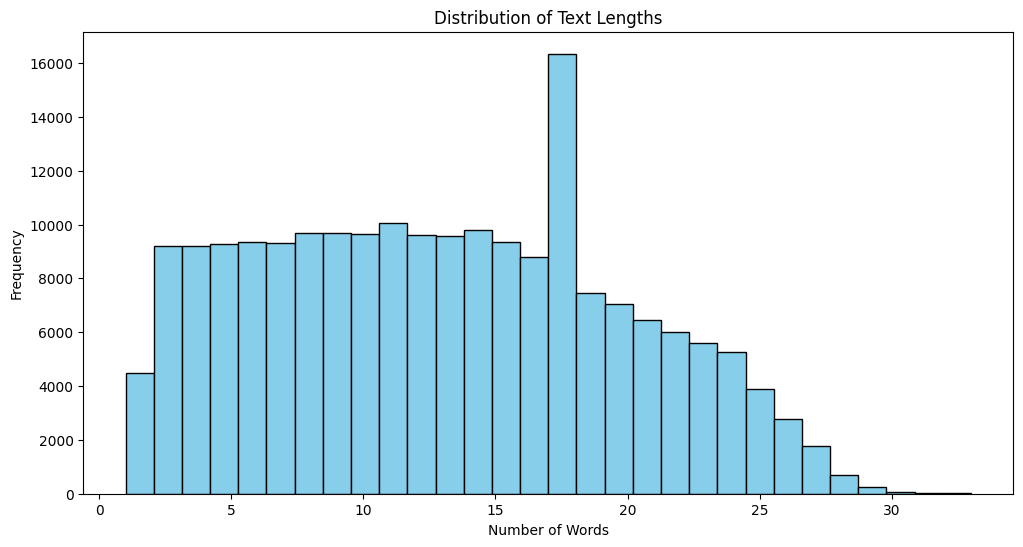


Text Length Statistics:
Mean Length: 13.00
Median Length: 13.00
Max Length: 33
Min Length: 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the length of each text (in words)
text_lengths = data["text"].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Show basic statistics about text lengths
print("\nText Length Statistics:")
print(f"Mean Length: {np.mean(text_lengths):.2f}")
print(f"Median Length: {np.median(text_lengths):.2f}")
print(f"Max Length: {np.max(text_lengths)}")
print(f"Min Length: {np.min(text_lengths)}")


we dont have null and text are small in lenght

### number of tokens in text column

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

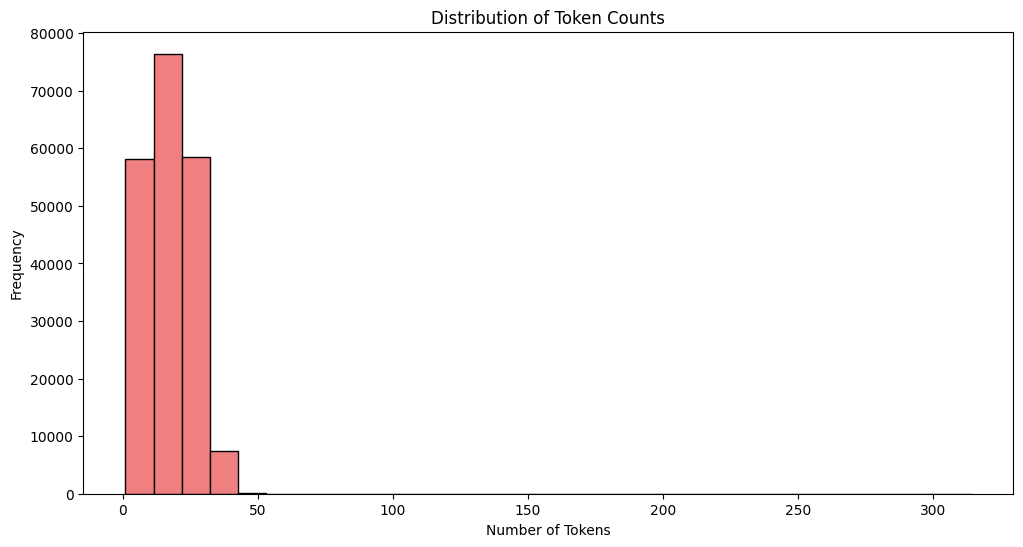


Token Count Statistics:
Mean Tokens: 17.40
Median Tokens: 17.00
Max Tokens: 314
Min Tokens: 1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the number of tokens in each text
token_lengths = data["text"].apply(lambda x: len(tokenizer.tokenize(x)))

# Plot the distribution of token counts
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=30, color="lightcoral", edgecolor="black")
plt.title("Distribution of Token Counts")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

# Show basic statistics about token counts
print("\nToken Count Statistics:")
print(f"Mean Tokens: {np.mean(token_lengths):.2f}")
print(f"Median Tokens: {np.median(token_lengths):.2f}")
print(f"Max Tokens: {np.max(token_lengths)}")
print(f"Min Tokens: {np.min(token_lengths)}")


#### finding the best value for padding the texts

In [ ]:
# Calculate the 95th percentile of token counts
padding_length = int(np.percentile(approx_token_lengths, 95))

print(f"Recommended Padding Length (95th Percentile): {padding_length}")


Recommended Padding Length (95th Percentile): 24


### check for null value

In [ ]:
# Check dataset information (columns, types, missing values)
print("\nDataset Info:")
print(data.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200664 entries, 0 to 200663
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   200664 non-null  int64 
 1   text         200664 non-null  object
 2   praise       200664 non-null  int64 
 3   amusement    200664 non-null  int64 
 4   anger        200664 non-null  int64 
 5   disapproval  200664 non-null  int64 
 6   confusion    200664 non-null  int64 
 7   interest     200664 non-null  int64 
 8   sadness      200664 non-null  int64 
 9   fear         200664 non-null  int64 
 10  joy          200664 non-null  int64 
 11  love         200664 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 18.4+ MB
None


In [ ]:
# Check for NaN values in the text column
nan_count = data["text"].isna().sum()

print(f"Number of NaN values in the 'text' column: {nan_count}")

# Display rows where the text is NaN
if nan_count > 0:
    print("\nRows with NaN in 'text':")
    print(data[data["text"].isna()])


Number of NaN values in the 'text' column: 0


no NaN in texts

### Check class distribution

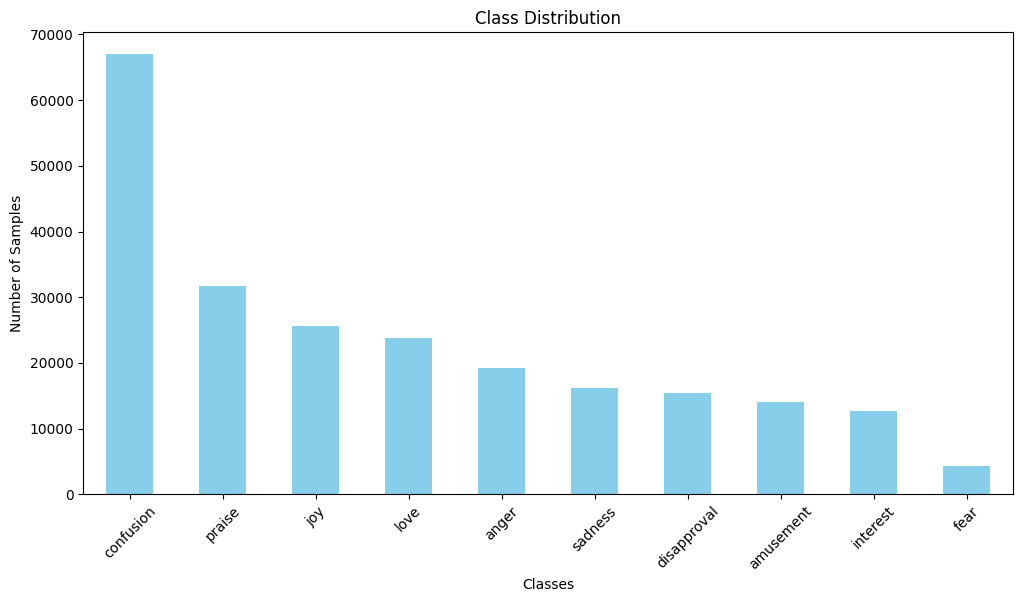

In [ ]:
# Check class distribution
label_columns = data.columns[1:]  # Assuming the first column is "text"
label_distribution = data[label_columns].sum()
# Plot the distribution of classes
plt.figure(figsize=(12, 6))
label_distribution.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()


as the classes are imbalance and data set is large we should consider undersampling for training

### number of different words

In [ ]:
import pandas as pd
import re
import string

# Assuming 'data' is your DataFrame and 'text' is the column containing the text data

# Function to preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", " ", text)  # Remove punctuation
    text = re.sub(r"\d+", " ", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply preprocessing to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Tokenize the cleaned text and get all words
all_words = ' '.join(data['cleaned_text']).split()

# Get the unique words using a set
unique_words = set(all_words)

# Print the number of unique words
print(f"Number of unique words: {len(unique_words)}")

# Remove the 'cleaned_text' column
data.drop(columns=['cleaned_text'], inplace=True)


Number of unique words: 31399


## preprocessing


The code snippet defines a PyTorch Dataset class for handling text data, preparing it for training with a DistilBERT model.
Converts the raw text into numerical IDs using the DistilBERT tokenizer.

padding="max_length": Pads shorter inputs to the maximum length.

truncation=True: Truncates inputs longer than max_len (default: 128 tokens).

return_tensors="pt": Returns PyTorch tensors for numerical IDs and attention masks.

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        """
        A PyTorch Dataset class to preprocess and tokenize text for DistilBERT.

        Args:
            texts (list of str): List of text samples.
            labels (array-like): Corresponding labels (e.g., multi-label format).
            tokenizer: Tokenizer instance (e.g., DistilBertTokenizer).
            max_len (int): Maximum token length for padding/truncation.
        """
        self.texts = texts
        self.labels = np.array(labels, dtype=np.float32)  # Ensure numeric labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.texts)

    def __getitem__(self, index):
        """
        Processes and tokenizes a single sample.

        Args:
            index (int): Index of the sample.

        Returns:
            dict: Tokenized input IDs, attention masks, labels, and raw text.
        """
        text = str(self.texts[index])  # Ensure the input is a string
        label = self.labels[index]

        # Tokenize and encode the text
        encoding = self.tokenizer(
            text,
            padding="max_length",  # Pads to max_len
            truncation=True,       # Truncates to max_len
            max_length=self.max_len,
            return_tensors="pt"    # Returns PyTorch tensors
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),  # Squeeze to remove batch dimension
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.float32),  # Explicitly ensure float32 type
            "text": text  # Include raw text for visualization
        }


### train-test split and under sample

all tests are using 1% of the actual data without any changes in them

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.utils import resample
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
# ================================
# Sampled Dataset
# ================================

# Step 1: Prepare sampled texts and labels
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for sampled data
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
# sampled_train_texts = sampled_train_texts.ravel()
# sampled_test_texts = sampled_test_texts.ravel()

# Step 4: Create Dataset and DataLoader for the sampled dataset
# sampled_train_dataset = TextDataset(sampled_train_texts, sampled_train_labels, tokenizer, max_len=24)
# sampled_test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)

# train_loader = DataLoader(sampled_train_dataset, batch_size=16, shuffle=True)
# sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)

In [ ]:
print(len(sampled_train_texts))

18059


#### method 1 undersampling

using scikit-multilearn for iterative stratified train-test splitting, which is specifically designed for multi-label datasets. This method ensures that the label distributions are preserved in both the training and test sets.

apply under sampling to reduce train data size

Handles Multi-Label Overlaps:

Instead of relying on indices, this approach works directly with the DataFrame to ensure samples that belong to multiple classes are only included once.
Drop Duplicates After Sampling:

Drops duplicates to prevent samples shared across classes from being overrepresented.

Readability:

Uses explicit filtering and sampling for each class, making the logic easier to follow.

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.utils import resample
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# ================================
# Function to Undersample Majority Classes
# ================================

def undersample_data(texts, labels):
    """
    Undersamples the majority classes in the training data for multi-label classification.

    Args:
        texts (list): List of text samples.
        labels (np.ndarray): Corresponding labels (multi-label format).

    Returns:
        tuple: Undersampled texts and labels.
    """
    # Combine texts and labels into a DataFrame
    data = pd.DataFrame({
        'text': texts,
        'labels': [",".join(map(str, label)) for label in labels]  # Convert labels to strings for grouping
    })

    # Group by unique label combinations and count occurrences
    label_combinations = data.groupby('labels').size()

    # Find the minimum count among all unique label combinations
    min_count = label_combinations.min()

    # Undersample each label combination to the minimum count
    undersampled_data = data.groupby('labels').apply(
        lambda group: group.sample(n=min_count, random_state=42)
    ).reset_index(drop=True)

    # Convert label strings back to NumPy array format
    undersampled_data['labels'] = undersampled_data['labels'].apply(
        lambda x: np.array(list(map(int, x.split(","))))
    )

    # Extract the undersampled texts and labels
    undersampled_texts = undersampled_data['text'].tolist()
    undersampled_labels = np.stack(undersampled_data['labels'])

    return undersampled_texts, undersampled_labels



# ================================
# Full Dataset
# ================================

# Ensure the correct format for iterative_train_test_split
texts = np.array(data["text"].tolist())
labels = data.iloc[:, 1:].values  # Multi-label format

# Perform stratified train-test split
# Note: Reshape texts for splitting and ensure proper alignment
full_train_texts, full_train_labels, full_test_texts, full_test_labels = iterative_train_test_split(
    texts.reshape(-1, 1), labels, test_size=0.1
)

# Reshape back to 1D for texts
full_train_texts = full_train_texts.ravel()  # Flatten the array back to 1D
full_test_texts = full_test_texts.ravel()


# Step 3: Undersample training data
full_train_texts_balanced, full_train_labels_balanced = undersample_data(full_train_texts, full_train_labels)

# Step 4: Create Dataset and DataLoader for the full dataset
full_train_dataset = TextDataset(full_train_texts_balanced, full_train_labels_balanced, tokenizer, max_len=24)
full_test_dataset = TextDataset(full_test_texts, full_test_labels, tokenizer, max_len=24)

full_train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True)
full_test_loader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)

# ================================
# Sampled Dataset
# ================================

# Step 1: Prepare sampled texts and labels
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for sampled data
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()
sampled_test_texts = sampled_test_texts.ravel()

# Step 3: Undersample training data for sampled dataset
sampled_train_texts_balanced, sampled_train_labels_balanced = undersample_data(sampled_train_texts, sampled_train_labels)

# Step 4: Create Dataset and DataLoader for the sampled dataset
sampled_train_dataset = TextDataset(sampled_train_texts_balanced, sampled_train_labels_balanced, tokenizer, max_len=24)
sampled_test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)

sampled_train_loader = DataLoader(sampled_train_dataset, batch_size=16, shuffle=True)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)



<ipython-input-27-902c77b631d7>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_data = data.groupby('labels').apply(
<ipython-input-27-902c77b631d7>:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_data = data.groupby('labels').apply(



Class distribution for Full Train Dataset (Balanced):
Class 0: 101 samples
Class 1: 72 samples
Class 2: 84 samples
Class 3: 87 samples
Class 4: 121 samples
Class 5: 86 samples
Class 6: 107 samples
Class 7: 84 samples
Class 8: 112 samples
Class 9: 100 samples


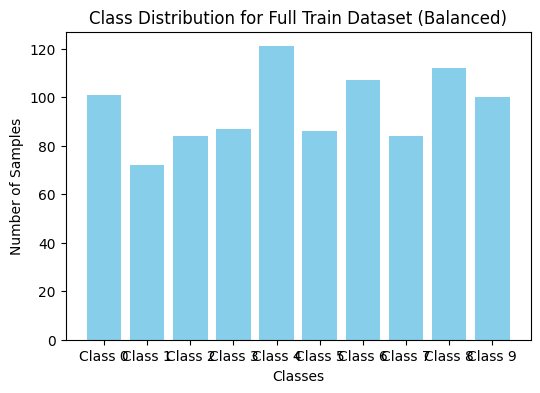


Class distribution for Full Test Dataset (Balanced):
Class 0: 3169 samples
Class 1: 1400 samples
Class 2: 1930 samples
Class 3: 1544 samples
Class 4: 6698 samples
Class 5: 1264 samples
Class 6: 1621 samples
Class 7: 430 samples
Class 8: 2560 samples
Class 9: 2375 samples


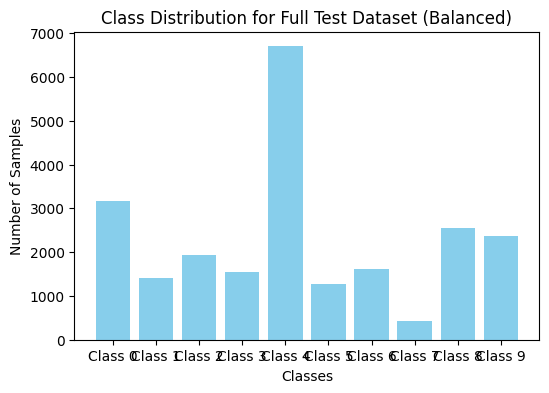


Class distribution for Sampled Train Dataset (Balanced):
Class 0: 43 samples
Class 1: 41 samples
Class 2: 35 samples
Class 3: 41 samples
Class 4: 44 samples
Class 5: 43 samples
Class 6: 50 samples
Class 7: 28 samples
Class 8: 52 samples
Class 9: 49 samples


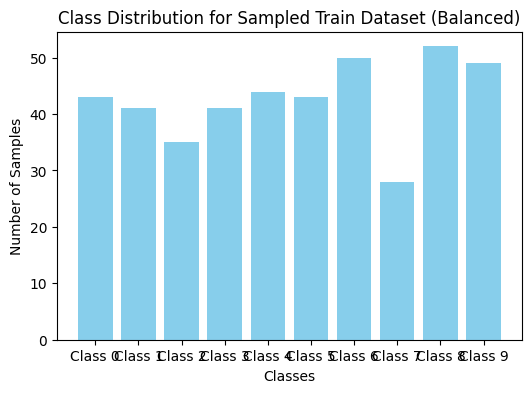


Class distribution for Sampled Test Dataset (Balanced):
Class 0: 43 samples
Class 1: 41 samples
Class 2: 35 samples
Class 3: 41 samples
Class 4: 44 samples
Class 5: 43 samples
Class 6: 50 samples
Class 7: 28 samples
Class 8: 52 samples
Class 9: 49 samples


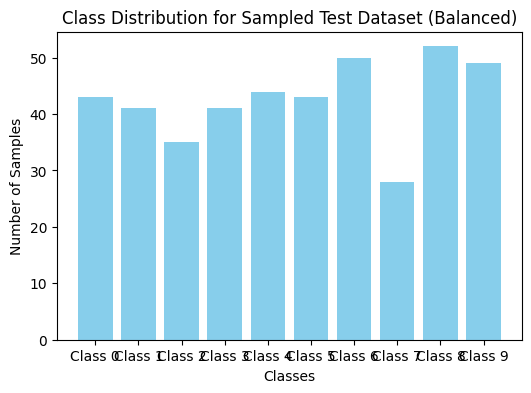

In [ ]:
# Function to print and plot class distributions for balanced datasets
def print_and_plot_balanced_class_distribution(labels, dataset_name):
    # Print class distribution
    label_sums = np.sum(labels, axis=0)  # Sum each column (class-wise counts)
    print(f"\nClass distribution for {dataset_name} (Balanced):")
    for i, count in enumerate(label_sums):
        print(f"Class {i}: {count} samples")

    # Plot class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(label_sums)), label_sums, color='skyblue')
    plt.title(f"Class Distribution for {dataset_name} (Balanced)")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(range(len(label_sums)), [f"Class {i}" for i in range(len(label_sums))])
    plt.show()


# Assuming `balanced_full_train_labels` and other balanced label datasets are available
# Replace with actual balanced labels
balanced_full_train_labels = full_train_labels_balanced  # Adjust with actual variable names
balanced_full_test_labels = full_test_labels  # Assuming test data wasn't undersampled
balanced_sampled_train_labels = sampled_train_labels_balanced  # Adjust with actual variable names
balanced_sampled_test_labels = sampled_train_labels_balanced  # Adjust with actual variable names

# Plot and print class distributions for the balanced datasets
print_and_plot_balanced_class_distribution(balanced_full_train_labels, "Full Train Dataset")
print_and_plot_balanced_class_distribution(balanced_full_test_labels, "Full Test Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_train_labels, "Sampled Train Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_test_labels, "Sampled Test Dataset")


#### methhod 2 Balance loader

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
from skmultilearn.model_selection import iterative_train_test_split

# ================================
# Function to Compute Sample Weights
# ================================

def compute_sample_weights(labels):
    """
    Computes sample weights for each instance based on the frequency of labels.
    The higher the frequency of a label, the lower the weight of that sample.
    This helps in balancing the dataset during training.

    Args:
        labels (np.ndarray): Array of labels (multi-label format).

    Returns:
        np.ndarray: Sample weights.
    """
    # Sum each label across all samples to compute its frequency
    label_counts = np.sum(labels, axis=0)
    class_weights = 1.0 / (label_counts + 1e-10)  # Inverse frequency, add small epsilon to avoid division by zero

    # Compute the sample weights by applying class weights for each label in each sample
    sample_weights = np.dot(labels, class_weights)  # Multiply labels with class weights for each sample

    return sample_weights

# ================================
# Full Dataset
# ================================

# Ensure the correct format for iterative_train_test_split
texts = np.array(data["text"].tolist())
labels = data.iloc[:, 1:].values  # Multi-label format

# Perform stratified train-test split
full_train_texts, full_train_labels, full_test_texts, full_test_labels = iterative_train_test_split(
    texts.reshape(-1, 1), labels, test_size=0.1
)

# Reshape back to 1D for texts
full_train_texts = full_train_texts.ravel()  # Flatten the array back to 1D
full_test_texts = full_test_texts.ravel()

# Compute sample weights for the full training set
full_train_sample_weights = compute_sample_weights(full_train_labels)

# Step 3: Create Dataset and DataLoader for the full dataset
full_train_dataset = TextDataset(full_train_texts, full_train_labels, tokenizer, max_len=24)
full_test_dataset = TextDataset(full_test_texts, full_test_labels, tokenizer, max_len=24)

# Create a WeightedRandomSampler based on the sample weights
full_train_sampler = WeightedRandomSampler(weights=full_train_sample_weights, num_samples=len(full_train_sample_weights), replacement=True)

# Create DataLoader with the sampler
full_train_loader = DataLoader(full_train_dataset, batch_size=16, sampler=full_train_sampler)
full_test_loader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)

# ================================
# Sampled Dataset
# ================================

# Step 1: Prepare sampled texts and labels
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for sampled data
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()
sampled_test_texts = sampled_test_texts.ravel()

# Compute sample weights for the sampled training set
sampled_train_sample_weights = compute_sample_weights(sampled_train_labels)

# Step 3: Create Dataset and DataLoader for the sampled dataset
sampled_train_dataset = TextDataset(sampled_train_texts, sampled_train_labels, tokenizer, max_len=24)
sampled_test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)

# Create a WeightedRandomSampler based on the sample weights
sampled_train_sampler = WeightedRandomSampler(weights=sampled_train_sample_weights, num_samples=len(sampled_train_sample_weights), replacement=True)

# Create DataLoader with the sampler
sampled_train_loader = DataLoader(sampled_train_dataset, batch_size=16, sampler=sampled_train_sampler)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)




Class distribution for Full Train Dataset (Balanced):
Class 0: 101 samples
Class 1: 72 samples
Class 2: 84 samples
Class 3: 87 samples
Class 4: 121 samples
Class 5: 86 samples
Class 6: 107 samples
Class 7: 84 samples
Class 8: 112 samples
Class 9: 100 samples


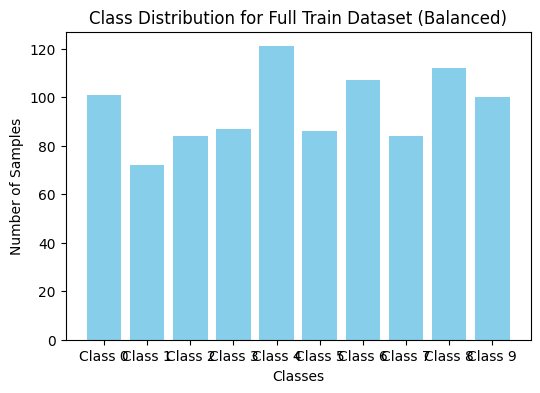


Class distribution for Full Test Dataset (Balanced):
Class 0: 3169 samples
Class 1: 1400 samples
Class 2: 1930 samples
Class 3: 1543 samples
Class 4: 6698 samples
Class 5: 1264 samples
Class 6: 1621 samples
Class 7: 430 samples
Class 8: 2560 samples
Class 9: 2375 samples


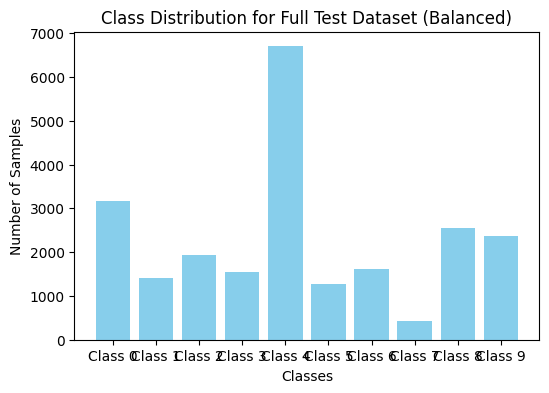


Class distribution for Sampled Train Dataset (Balanced):
Class 0: 43 samples
Class 1: 41 samples
Class 2: 35 samples
Class 3: 41 samples
Class 4: 44 samples
Class 5: 43 samples
Class 6: 50 samples
Class 7: 28 samples
Class 8: 52 samples
Class 9: 49 samples


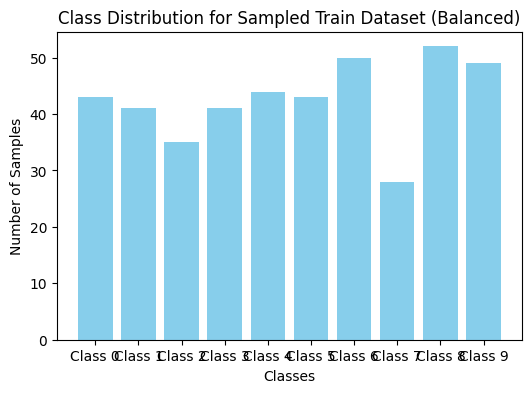


Class distribution for Sampled Test Dataset (Balanced):
Class 0: 43 samples
Class 1: 41 samples
Class 2: 35 samples
Class 3: 41 samples
Class 4: 44 samples
Class 5: 43 samples
Class 6: 50 samples
Class 7: 28 samples
Class 8: 52 samples
Class 9: 49 samples


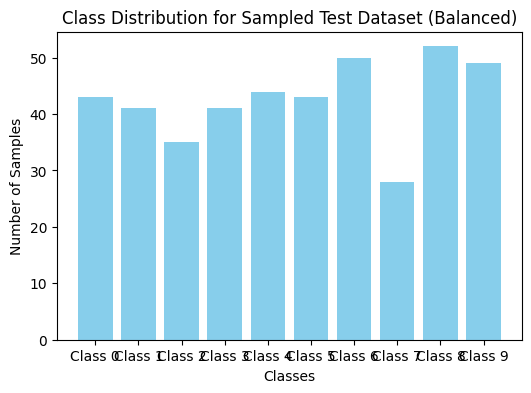

In [ ]:
# Function to print and plot class distributions for balanced datasets
def print_and_plot_balanced_class_distribution(labels, dataset_name):
    # Print class distribution
    label_sums = np.sum(labels, axis=0)  # Sum each column (class-wise counts)
    print(f"\nClass distribution for {dataset_name} (Balanced):")
    for i, count in enumerate(label_sums):
        print(f"Class {i}: {count} samples")

    # Plot class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(range(len(label_sums)), label_sums, color='skyblue')
    plt.title(f"Class Distribution for {dataset_name} (Balanced)")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(range(len(label_sums)), [f"Class {i}" for i in range(len(label_sums))])
    plt.show()


# Assuming `balanced_full_train_labels` and other balanced label datasets are available
# Replace with actual balanced labels
balanced_full_train_labels = full_train_labels_balanced  # Adjust with actual variable names
balanced_full_test_labels = full_test_labels  # Assuming test data wasn't undersampled
balanced_sampled_train_labels = sampled_train_labels_balanced  # Adjust with actual variable names
balanced_sampled_test_labels = sampled_train_labels_balanced  # Adjust with actual variable names

# Plot and print class distributions for the balanced datasets
print_and_plot_balanced_class_distribution(balanced_full_train_labels, "Full Train Dataset")
print_and_plot_balanced_class_distribution(balanced_full_test_labels, "Full Test Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_train_labels, "Sampled Train Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_test_labels, "Sampled Test Dataset")


#### method 3 oversampling

In [ ]:
from sklearn.utils import resample
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd

def balance_classes_to_target_size(texts, labels, target_size):
    """
    Balances the dataset to a target size while ensuring each class distribution is equal.
    Ensures the total size is `target_size`.

    Args:
        texts (list): List of text samples.
        labels (np.ndarray): Corresponding labels (multi-label format).
        target_size (int): The target size for balancing.

    Returns:
        tuple: Balanced texts and labels.
    """
    # Combine texts and labels into a DataFrame
    data = pd.DataFrame({
        'text': texts,
        'labels': [",".join(map(str, label)) for label in labels]  # Convert labels to strings for grouping
    })

    # Group by unique label combinations and count occurrences
    label_combinations = data.groupby('labels').size()

    # Find the maximum count among all unique label combinations
    max_count = label_combinations.max()

    # Calculate how many samples per class should be present in the final dataset
    class_count = target_size // len(label_combinations)
    remaining_samples = target_size % len(label_combinations)

    print(f"Max count of label combinations: {max_count}")
    print(f"Target samples per class: {class_count} (with {remaining_samples} remaining samples)")

    # Sample each class to ensure equal size
    balanced_data = data.groupby('labels').apply(
        lambda group: group.sample(n=class_count, random_state=42, replace=True)  # Oversample each class to the same size
    ).reset_index(drop=True)

    # If there are remaining samples, add them randomly to balance the total size
    if remaining_samples > 0:
        remaining_data = data.sample(n=remaining_samples, random_state=42, replace=True)
        balanced_data = pd.concat([balanced_data, remaining_data])

    # Convert label strings back to NumPy array format
    balanced_data['labels'] = balanced_data['labels'].apply(
        lambda x: np.array(list(map(int, x.split(","))))  # Convert labels back to arrays
    )

    # Extract the balanced texts and labels
    balanced_texts = balanced_data['text'].tolist()
    balanced_labels = np.stack(balanced_data['labels'])

    return balanced_texts, balanced_labels



# ================================
# Full Dataset
# ================================

# Prepare texts and labels from the original dataset
texts = np.array(data["text"].tolist())
labels = data.iloc[:, 1:].values  # Multi-label format

# Perform stratified train-test split for the full dataset
full_train_texts, full_train_labels, full_test_texts, full_test_labels = iterative_train_test_split(
    texts.reshape(-1, 1), labels, test_size=0.1
)

# Reshape back to 1D for texts
full_train_texts = full_train_texts.ravel()  # Flatten the array back to 1D
full_test_texts = full_test_texts.ravel()

# Step 3: Balance the training data to ensure equal class distribution (target size 50k)
balanced_full_train_texts, balanced_full_train_labels = balance_classes_to_target_size(full_train_texts, full_train_labels, target_size=50000)
balanced_full_test_texts, balanced_full_test_labels = balance_classes_to_target_size(full_test_texts, full_test_labels, target_size=50000)

# Step 4: Create Dataset and DataLoader for the full dataset
full_train_dataset = TextDataset(balanced_full_train_texts, balanced_full_train_labels, tokenizer, max_len=24)
full_test_dataset = TextDataset(balanced_full_test_texts, balanced_full_test_labels, tokenizer, max_len=24)

full_train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True)
full_test_loader = DataLoader(full_test_dataset, batch_size=16, shuffle=False)

# ================================
# Sampled Dataset
# ================================

# Prepare texts and labels from the sampled dataset
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for the sampled dataset
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()
sampled_test_texts = sampled_test_texts.ravel()

# Step 3: Balance the training data for the sampled dataset to ensure equal class distribution (target size 50k)
balanced_sampled_train_texts, balanced_sampled_train_labels = balance_classes_to_target_size(sampled_train_texts, sampled_train_labels, target_size=8000)
balanced_sampled_test_texts, balanced_sampled_test_labels = balance_classes_to_target_size(sampled_test_texts, sampled_test_labels, target_size=1600)

# Step 4: Create Dataset and DataLoader for the sampled dataset
sampled_train_dataset = TextDataset(balanced_sampled_train_texts, balanced_sampled_train_labels, tokenizer, max_len=24)
sampled_test_dataset = TextDataset(balanced_sampled_test_texts, balanced_sampled_test_labels, tokenizer, max_len=24)

sampled_train_loader = DataLoader(sampled_train_dataset, batch_size=16, shuffle=True)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)



Max count of label combinations: 55859
Target samples per class: 176 (with 192 remaining samples)


<ipython-input-43-6280aaed0e36>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('labels').apply(


Max count of label combinations: 6200
Target samples per class: 303 (with 5 remaining samples)


<ipython-input-43-6280aaed0e36>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('labels').apply(


Max count of label combinations: 5613
Target samples per class: 51 (with 44 remaining samples)
Max count of label combinations: 623
Target samples per class: 20 (with 60 remaining samples)


<ipython-input-43-6280aaed0e36>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('labels').apply(
<ipython-input-43-6280aaed0e36>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('labels').apply(



Class distribution for Full Train Dataset:
Class 0: 17808 samples
Class 1: 12685 samples
Class 2: 14803 samples
Class 3: 15326 samples
Class 4: 21351 samples
Class 5: 15152 samples
Class 6: 18846 samples
Class 7: 14787 samples
Class 8: 19745 samples
Class 9: 17619 samples


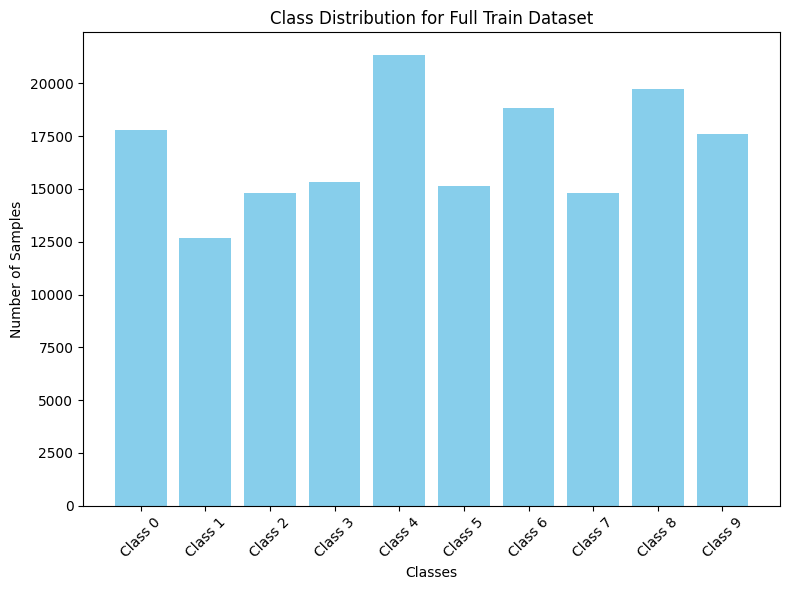


Class distribution for Full Test Dataset:
Class 0: 13938 samples
Class 1: 12726 samples
Class 2: 13332 samples
Class 3: 13332 samples
Class 4: 13940 samples
Class 5: 14847 samples
Class 6: 15151 samples
Class 7: 9696 samples
Class 8: 15453 samples
Class 9: 13940 samples


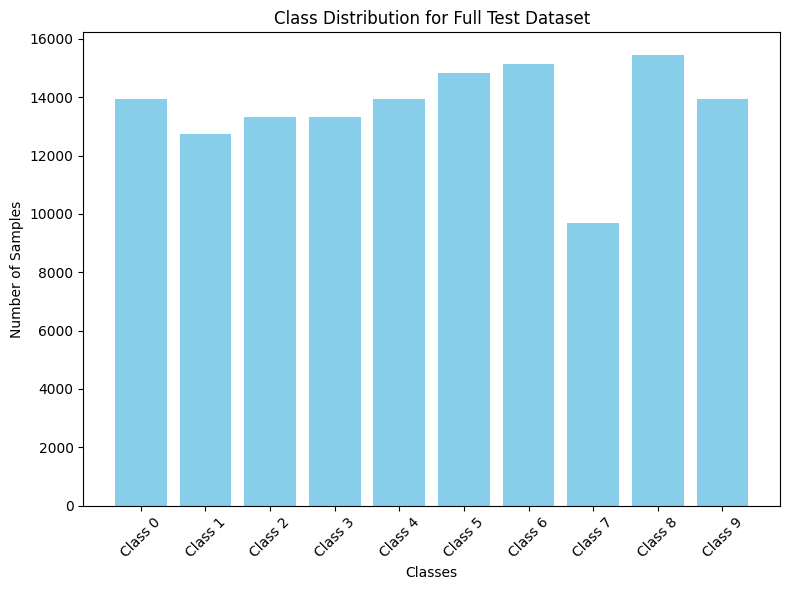


Class distribution for Sampled Train Dataset:
Class 0: 2253 samples
Class 1: 2096 samples
Class 2: 1789 samples
Class 3: 2094 samples
Class 4: 2261 samples
Class 5: 2247 samples
Class 6: 2605 samples
Class 7: 1428 samples
Class 8: 2705 samples
Class 9: 2551 samples


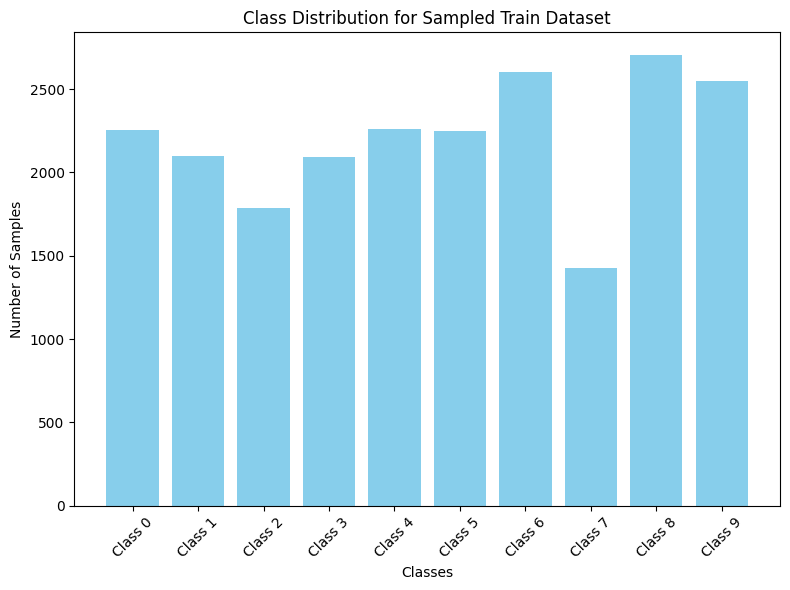


Class distribution for Sampled Test Dataset:
Class 0: 431 samples
Class 1: 263 samples
Class 2: 267 samples
Class 3: 345 samples
Class 4: 360 samples
Class 5: 384 samples
Class 6: 344 samples
Class 7: 202 samples
Class 8: 388 samples
Class 9: 384 samples


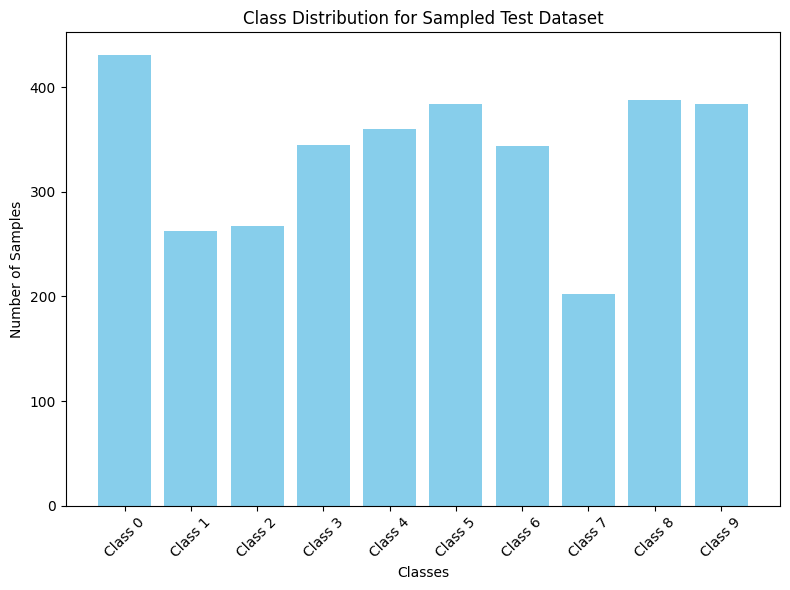

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def print_and_plot_balanced_class_distribution(labels, dataset_name):
    """
    Prints and plots the class distribution for the given labels.
    It assumes the labels are in multi-label format (binary matrix).

    Args:
        labels (np.ndarray): Multi-label format labels (num_samples x num_classes).
        dataset_name (str): Name of the dataset to display.
    """
    # Calculate the sum for each class (number of samples per class)
    label_sums = np.sum(labels, axis=0)  # Sum across rows (samples) for each column (class)

    # Print class distribution
    print(f"\nClass distribution for {dataset_name}:")
    for i, count in enumerate(label_sums):
        print(f"Class {i}: {count} samples")

    # Plot the class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(label_sums)), label_sums, color='skyblue')
    plt.title(f"Class Distribution for {dataset_name}")
    plt.xlabel("Classes")
    plt.ylabel("Number of Samples")
    plt.xticks(range(len(label_sums)), [f"Class {i}" for i in range(len(label_sums))], rotation=45)
    plt.tight_layout()
    plt.show()


# Plot and print class distributions for the balanced datasets

# Assuming the labels are in the correct shape (num_samples x num_classes)
print_and_plot_balanced_class_distribution(balanced_full_train_labels, "Full Train Dataset")
print_and_plot_balanced_class_distribution(balanced_full_test_labels, "Full Test Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_train_labels, "Sampled Train Dataset")
print_and_plot_balanced_class_distribution(balanced_sampled_test_labels, "Sampled Test Dataset")


#### method 4 oversampling using most frequent words

##### pre processing the text(removing stop words)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF Vectorization per Class
def get_top_tfidf_words_per_class(texts, labels, label_names, top_percent=0.1):
    top_words_per_class = {}

    for i, label in enumerate(label_names):
        # Get texts belonging to the current class (i.e., texts that have the current class label)
        class_texts = [text for text, label_vector in zip(texts, labels) if label_vector[i] == 1]

        # Perform TF-IDF on texts belonging to the current class
        vectorizer = TfidfVectorizer(max_features=1000)
        X = vectorizer.fit_transform(class_texts)
        feature_names = np.array(vectorizer.get_feature_names_out())
        tfidf_scores = np.array(X.sum(axis=0)).flatten()

        # Get the indices of the top words (top_percent of the total words)
        top_n = int(len(tfidf_scores) * top_percent)
        top_indices = tfidf_scores.argsort()[-top_n:][::-1]

        # Get the top words for this class
        top_words_per_class[label] = feature_names[top_indices]

    return top_words_per_class

# Get top 10% words per class
top_words_per_class = get_top_tfidf_words_per_class(sampled_train_cleaned_texts, sampled_train_labels, label_names, top_percent=0.1)

# Display the top words for each class
for label, words in top_words_per_class.items():
    print(f"Top words for class '{label}':")
    print(words)
    print("-" * 50)


Top words for class 'praise':
['name' 'thats' 'good' 'awesome' 'one' 'like' 'im' 'great' 'love'
 'amazing' 'looks' 'best' 'know' 'pretty' 'hes' 'actually' 'nice' 'well'
 'guy' 'people' 'way' 'also' 'right' 'never' 'ive' 'want' 'say' 'comment'
 'dont' 'even' 'done' 'still' 'weird' 'already' 'post' 'thought' 'ever'
 'welcome' 'yes' 'would' 'lmao' 'something' 'exactly' 'though' 'thank'
 'think' 'really' 'wish' 'better' 'make' 'maybe' 'come' 'man' 'seen' 'get'
 'cause' 'didnt' 'point' 'need' 'religion' 'yeah' 'going' 'lol' 'agree'
 'always' 'fix' 'brave' 'oh' 'hate' 'totally' 'favorite' 'got' 'hope'
 'greatest' 'us' 'wow' 'makes' 'cool' 'ok' 'completely' 'neat' 'worth'
 'games' 'game' 'friend' 'appreciate' 'subreddit' 'reddit' 'left' 'cant'
 'okay' 'glad' 'see' 'read' 'time' 'price' 'thing' 'dog' 'play'
 'highlight']
--------------------------------------------------
Top words for class 'amusement':
['lol' 'name' 'haha' 'good' 'one' 'like' 'im' 'funny' 'man' 'lmao' 'thats'
 'joke' 'look' '

In [ ]:
from sklearn.utils import resample
import random
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

label_names = data.columns[1:-1].tolist()  # Extract label names

# Ensure class_counts is of integer type
class_counts = np.sum(sampled_labels, axis=0).astype(int)

# Function to generate new samples for underrepresented classes
def generate_samples_for_underrepresented_classes(sampled_texts, sampled_labels, label_names, top_words_per_class, target_count=None):
    new_samples_texts = []
    new_samples_labels = []

    for i, label in enumerate(label_names):
        current_count = class_counts[i]

        if current_count < target_count:  # If this class is underrepresented
            # Calculate how many more samples we need
            samples_needed = target_count - current_count

            for _ in range(samples_needed):
                # Randomly select words from the top frequent words for this class
                random_words = random.sample(list(top_words_per_class[label]), 10)  # Choose a random subset of top words for this class
                new_text = " ".join(random_words)

                # Generate the new label (setting this class as 1)
                new_label = np.zeros_like(sampled_labels[0])
                new_label[i] = 1  # Set the current class to 1

                new_samples_texts.append(new_text)
                new_samples_labels.append(new_label)

    return new_samples_texts, new_samples_labels

# Generate samples for underrepresented classes (e.g., balance to 2000 samples per class)
target_count = 2000  # Target number of samples per class (adjust as needed)

new_texts, new_labels = generate_samples_for_underrepresented_classes(
   sampled_train_cleaned_texts, sampled_train_labels, label_names, top_words_per_class, target_count=target_count
)

# Add the newly generated samples to the training set
sampled_train_texts = np.concatenate([sampled_train_texts, new_texts])
sampled_train_labels = np.concatenate([sampled_train_labels, np.array(new_labels)])

print(f"Original training set size: {len(sampled_train_texts)}")
print(f"New training set size: {len(sampled_train_texts) + len(new_texts)}")


Original training set size: 17725
New training set size: 33644


In [ ]:

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()

# Step 4: Create Dataset and DataLoader for the sampled dataset
sampled_train_dataset = TextDataset(sampled_train_texts, sampled_train_labels, tokenizer, max_len=24)
sampled_test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)

sampled_train_loader = DataLoader(sampled_train_dataset, batch_size=16, shuffle=True)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)


<ipython-input-77-4d3b31039d8b>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=class_counts, palette="coolwarm")


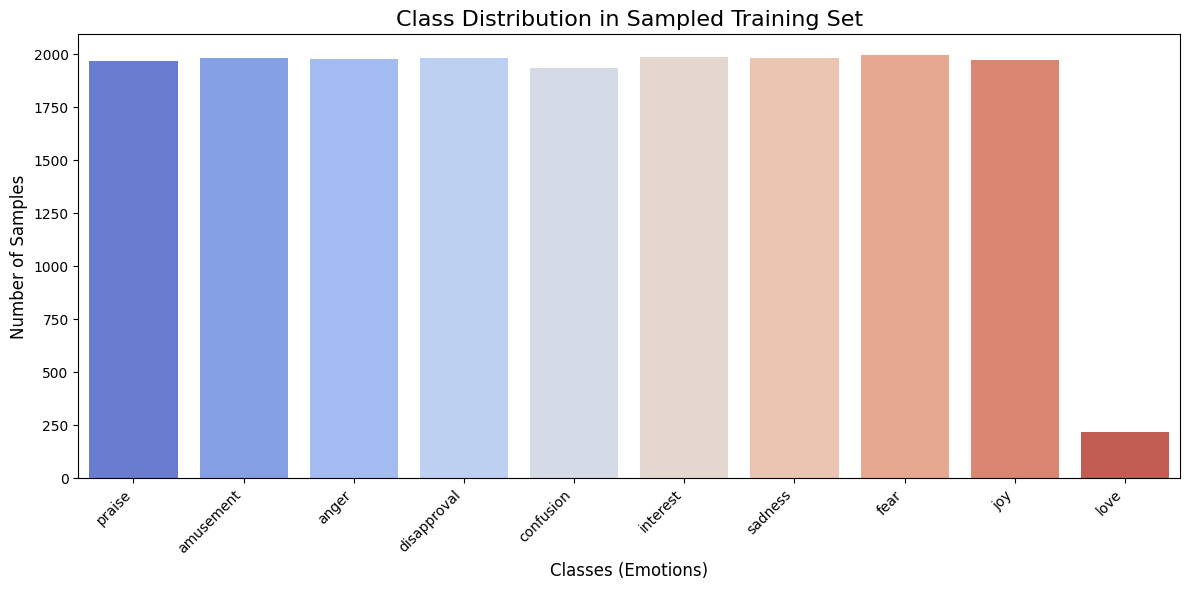

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure label_names has the correct number of classes based on the shape of sampled_train_labels
label_names = data.columns[1:].tolist()  # Assuming the first column is 'text', adjust as needed

# Calculate the number of samples for each class (sum along axis 0 to count occurrences per class)
class_counts = np.sum(sampled_train_labels, axis=0)

# Make sure label_names has the same length as class_counts
assert len(label_names) == len(class_counts), "Mismatch between label names and class counts"

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_names, y=class_counts, palette="coolwarm")

# Adding titles and labels
plt.title('Class Distribution in Sampled Training Set', fontsize=16)
plt.xlabel('Classes (Emotions)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


####

#### method 5 SMOTE

In [ ]:
%pip install scikit-multilearn

In [ ]:
%pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.0
    Uninstalling scikit-learn-1.3.0:
      Successfully uninstalled scikit-learn-1.3.0


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from skmultilearn.model_selection import iterative_train_test_split

# ================================
# Sampled Dataset
# ================================

# Step 1: Prepare sampled texts and labels
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for sampled data
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()
sampled_test_texts = sampled_test_texts.ravel()

# ================================
# Vectorize Texts Using TF-IDF
# ================================

# Convert text data to numeric format using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features based on dataset size
tfidf_train = tfidf_vectorizer.fit_transform(sampled_train_texts).toarray()

# ================================
# SMOTE for Uniform Class Distribution
# ================================

def smote_uniform_distribution(tfidf_data, labels, max_difference=1000):
    """
    Apply SMOTE for each class independently to ensure uniform class distribution
    with a maximum difference between classes.

    Args:
        tfidf_data: Numeric TF-IDF representation of the training texts.
        labels: Multi-label array for the training set.
        max_difference: Maximum allowed difference in sample count between classes.

    Returns:
        Oversampled TF-IDF data and labels.
    """
    smote = SMOTE(random_state=42)
    oversampled_data = []
    oversampled_labels = []

    # Calculate the target count for oversampling
    class_counts = np.sum(labels, axis=0)
    target_count = np.min(class_counts) + max_difference

    for class_idx in range(labels.shape[1]):  # Iterate over each class (column)
        # Get indices for the current class
        binary_labels = labels[:, class_idx]  # One-vs-rest: Treat this class as binary
        current_data = tfidf_data

        # Check if SMOTE is needed for this class
        if class_counts[class_idx] < target_count:
            # SMOTE requires at least two samples for the minority class
            if np.sum(binary_labels) < 2:
                print(f"Skipping class {class_idx} due to insufficient samples for SMOTE.")
                continue

            # Calculate the number of samples needed to reach the target count
            num_samples_to_generate = target_count - np.sum(binary_labels)

            # Apply SMOTE
            resampled_data, resampled_labels = smote.fit_resample(current_data, binary_labels)

            # Truncate to the required number of samples if SMOTE over-generates
            if len(resampled_data) > num_samples_to_generate:
                resampled_data = resampled_data[:num_samples_to_generate]
                resampled_labels = resampled_labels[:num_samples_to_generate]

            # Store the resampled data
            oversampled_data.extend(resampled_data)
            resampled_multi_labels = np.repeat(
                labels[binary_labels == 1][0].reshape(1, -1), len(resampled_data), axis=0
            )
            oversampled_labels.extend(resampled_multi_labels)

    return np.array(oversampled_data), np.array(oversampled_labels)

# Apply SMOTE for uniform class distribution
max_difference = 1000  # Maximum difference in sample counts between classes
oversampled_tfidf, oversampled_labels = smote_uniform_distribution(tfidf_train, sampled_train_labels, max_difference)

# Combine with the original dataset
combined_tfidf = np.vstack([tfidf_train, oversampled_tfidf])
combined_labels = np.vstack([sampled_train_labels, oversampled_labels])

# ================================
# Prepare Oversampled Text Dataset
# ================================

# Reverse TF-IDF into text form for dataset preparation (optional step)
reverse_tfidf = tfidf_vectorizer.inverse_transform(combined_tfidf)
oversampled_texts = [" ".join(words) for words in reverse_tfidf]

oversampled_train_dataset = TextDataset(oversampled_texts, combined_labels, tokenizer, max_len=24)
sampled_test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)

sampled_train_loader = DataLoader(oversampled_train_dataset, batch_size=16, shuffle=True)
sampled_test_loader = DataLoader(sampled_test_dataset, batch_size=16, shuffle=False)

# Debugging Information
print(f"Original training set size: {len(sampled_train_texts)}")
print(f"Oversampled training set size: {len(oversampled_texts)}")


Original training set size: 18059
Oversampled training set size: 19407


<ipython-input-19-6f7fd5602cf4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=class_counts, palette="viridis")


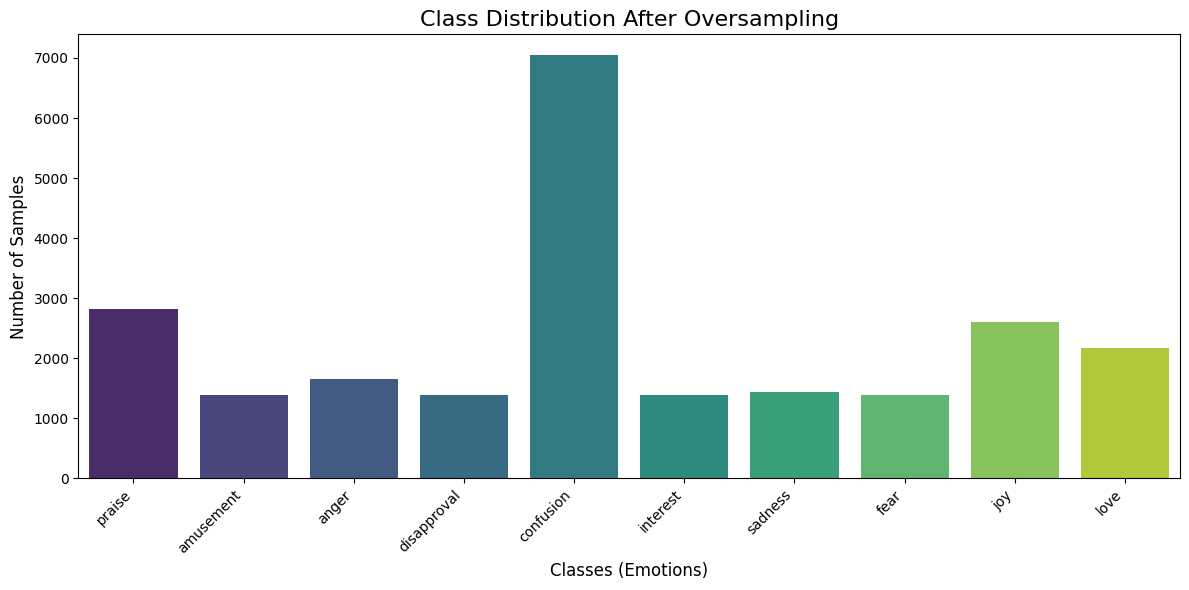

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the number of samples for each class
class_counts = np.sum(combined_labels, axis=0)  # Sum along columns to get counts per class

# Define the class names (labels)
label_names = data.columns[1:].tolist()  # Assuming the first column is 'text' and others are class labels

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_names, y=class_counts, palette="viridis")

# Adding titles and labels
plt.title('Class Distribution After Oversampling', fontsize=16)
plt.xlabel('Classes (Emotions)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


### method 6 just cutting out  extera samples on classes

In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np
import pandas as pd
from sklearn.utils import resample

# ================================
# Data Preprocessing & Splitting
# ================================

# Step 1: Prepare sampled texts and labels
sampled_texts = np.array(data_sampled["text"].tolist())
sampled_labels = data_sampled.iloc[:, 1:].values

# Step 2: Stratified train-test split for sampled data
sampled_train_texts, sampled_train_labels, sampled_test_texts, sampled_test_labels = iterative_train_test_split(
    sampled_texts.reshape(-1, 1), sampled_labels, test_size=0.1
)

# Reshape back to 1D for texts
sampled_train_texts = sampled_train_texts.ravel()
sampled_test_texts = sampled_test_texts.ravel()

# ================================
# Downsample All Classes to Target Size (10k)
# ================================

def downsample_to_target_size(texts, labels, target_size=10000):
    """
    Downsample all classes to the target size (10,000), prioritizing downsampling for overrepresented classes.

    Args:
        texts (np.array): Array of text samples.
        labels (np.array): Multi-label array.
        target_size (int): Target number of samples for each class.

    Returns:
        balanced_texts (np.array): The texts of the balanced dataset.
        balanced_labels (np.array): The labels of the balanced dataset.
    """
    # Convert texts to numpy array (if not already)
    texts = np.array(texts)

    # Calculate the total count for each class (label column)
    class_counts = np.sum(labels, axis=0)

    # Initialize lists to store downsampled data
    balanced_texts = []
    balanced_labels = []

    # Iterate over each class and apply downsampling to reach target size
    for class_idx in range(labels.shape[1]):  # Iterate over each label (class)
        # Get indices for the current class (whether it is 1 or not)
        class_indices = labels[:, class_idx] == 1
        class_texts = texts[class_indices]
        class_labels = labels[class_indices]

        # If the class has more than the target size, we downsample
        if len(class_texts) > target_size:
            class_data = pd.DataFrame({
                "text": class_texts,
                "labels": [tuple(row) for row in class_labels]
            })

            # Downsample the class to the target size
            class_data_downsampled = resample(
                class_data,
                replace=False,
                n_samples=target_size,
                random_state=42
            )

            balanced_texts.extend(class_data_downsampled["text"].tolist())
            balanced_labels.extend(list(class_data_downsampled["labels"]))
        else:
            # If the class is underrepresented, keep all samples
            balanced_texts.extend(class_texts)
            balanced_labels.extend(list(class_labels))

    balanced_labels = np.array([list(label) for label in balanced_labels])
    return np.array(balanced_texts), balanced_labels

# ================================
# Apply Downsampling for All Classes
# ================================

balanced_train_texts, balanced_train_labels = downsample_to_target_size(sampled_train_texts, sampled_train_labels, target_size=10000)

# ================================
# Create Dataset and DataLoader for Train and Test
# ================================



# Assuming `tokenizer` is a pre-trained tokenizer such as `BertTokenizer`
max_len = 24  # Define max length for padding/truncation

# Create the datasets and dataloaders for both train and test
train_dataset = TextDataset(balanced_train_texts, balanced_train_labels, tokenizer, max_len)
test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Debugging Information
print(f"Original training set size: {len(sampled_train_texts)}")
print(f"Downsampled training set size: {len(balanced_train_texts)}")


Original training set size: 180597
Downsampled training set size: 93867


In [ ]:
import pandas as pd

# --- For the Training Data ---
# Create a DataFrame for the texts.
sampled_data = pd.DataFrame({
    "text": balanced_train_texts
})

# Create a DataFrame for the labels.
# Here we name the columns as "label_0", "label_1", ..., "label_9".
labels_df = pd.DataFrame(balanced_train_labels, columns=[f"label_{i}" for i in range(10)])

# Concatenate the text DataFrame with the labels DataFrame.
sampled_data = pd.concat([sampled_data, labels_df], axis=1)

# (Optional) Reset the index if needed.
sampled_data = sampled_data.reset_index(drop=True)

# Display the first few rows to verify.
print("Training Data:")
print(sampled_data.head())

# --- For the Test Data ---
# Create a DataFrame for the texts.
sampled_test = pd.DataFrame({
    "text": sampled_test_texts
})

# Create a DataFrame for the test labels with the same column names.
test_labels_df = pd.DataFrame(sampled_test_labels, columns=[f"label_{i}" for i in range(10)])

# Concatenate the text DataFrame with the test labels DataFrame.
sampled_test = pd.concat([sampled_test, test_labels_df], axis=1)

# (Optional) Reset the index if needed.
sampled_test = sampled_test.reset_index(drop=True)

# Display the first few rows to verify.
print("\nTest Data:")
print(sampled_test.head())


Training Data:
                                                text  label_0  label_1  \
0  A good therapist can lead you to talking about...        1        0   
1       Play stupid games stamkos, win stupid prizes        1        0   
2  Damn didn’t know it was for a whole now that’s...        1        0   
3  I do play League of legends and [NAME] is my f...        1        0   
4  Go with her, eat healthy food with her too. It...        1        0   

   label_2  label_3  label_4  label_5  label_6  label_7  label_8  label_9  
0        0        0        0        0        0        0        0        0  
1        0        0        0        0        0        0        0        0  
2        0        0        0        0        0        0        1        0  
3        0        0        0        0        0        0        0        0  
4        0        0        0        0        0        0        0        0  

Test Data:
                                                text  label_0  label_1  

<ipython-input-13-a8b325309a15>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=class_counts, palette="viridis")


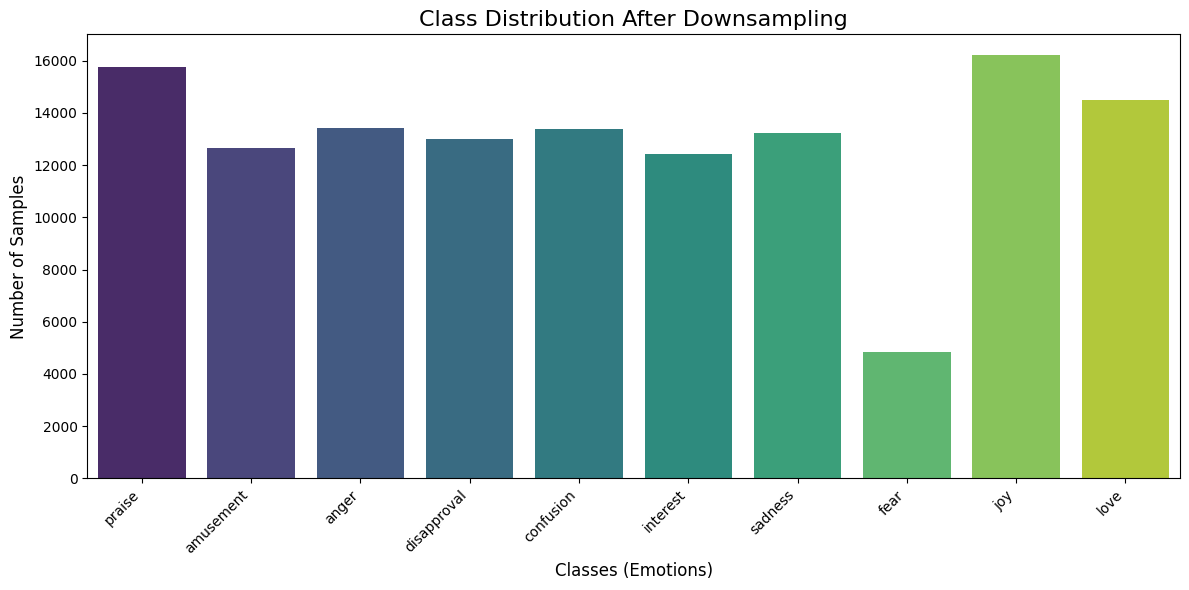

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================================
# Calculate Class Distributions
# ================================

# Calculate the number of samples for each class (sum of labels across all samples)
class_counts = np.sum(balanced_train_labels, axis=0)

# Define the class names (labels)
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and others are the labels

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=label_names, y=class_counts, palette="viridis")

# Adding titles and labels
plt.title('Class Distribution After Downsampling', fontsize=16)
plt.xlabel('Classes (Emotions)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


## base model defining

### distil bert

In [ ]:
# ================================
# 3. Define Model
# ================================
labels = data.iloc[:, 1:].values  # Multi-label format
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=labels.shape[1],
    problem_type="multi_label_classification"
)
model.to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### bert

In [ ]:
from transformers import BertForSequenceClassification

# ================================
# 3. Define Model
# ================================
labels = data.iloc[:, 1:].values  # Multi-label format

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Replace DistilBERT with BERT
    num_labels=labels.shape[1],  # Set the number of labels for multi-label classification
    problem_type="multi_label_classification"  # Ensure the model is set up for multi-label classification
)

model.to(device)  # Move the model to the specified device (GPU or CPU)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## train 1 with 1% of data(withouut under sampling)

In [ ]:
# ================================
# 4. Training with Accuracy
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for batch in sampled_train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds = (preds > 0.7).float()  # Convert probabilities to binary predictions
        correct_predictions += (preds == labels).all(dim=1).sum().item()  # Count correctly predicted samples
        total_samples += labels.size(0)  # Total samples in the batch

    # Calculate and print average loss and accuracy for the epoch
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 0.2857, Accuracy: 5.22%
Epoch 2, Loss: 0.2453, Accuracy: 13.45%
Epoch 3, Loss: 0.2094, Accuracy: 27.89%
Epoch 4, Loss: 0.1683, Accuracy: 45.53%
Epoch 5, Loss: 0.1327, Accuracy: 59.31%
Epoch 6, Loss: 0.1075, Accuracy: 67.46%
Epoch 7, Loss: 0.0911, Accuracy: 71.88%
Epoch 8, Loss: 0.0782, Accuracy: 74.62%
Epoch 9, Loss: 0.0683, Accuracy: 76.48%
Epoch 10, Loss: 0.0607, Accuracy: 77.91%
Epoch 11, Loss: 0.0560, Accuracy: 78.64%
Epoch 12, Loss: 0.0518, Accuracy: 79.48%
Epoch 13, Loss: 0.0491, Accuracy: 80.29%
Epoch 14, Loss: 0.0468, Accuracy: 80.61%
Epoch 15, Loss: 0.0452, Accuracy: 81.06%
Epoch 16, Loss: 0.0433, Accuracy: 81.38%
Epoch 17, Loss: 0.0438, Accuracy: 81.19%
Epoch 18, Loss: 0.0420, Accuracy: 81.80%
Epoch 19, Loss: 0.0413, Accuracy: 81.94%
Epoch 20, Loss: 0.0397, Accuracy: 82.04%


precision_recall_curve Function:
This function computes the precision-recall curve for binary classification tasks. It requires the true binary labels (y_true) and the predicted probabilities (y_probs). For each threshold in the range [0, 1], it calculates precision and recall values.

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Threshold Fine-Tuning with Loss Calculation
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Convert to NumPy arrays
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Fine-tune thresholds for each label
optimal_thresholds = []
for i in range(len(label_names)):  # Iterate over all labels
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_probs[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero
    best_threshold = thresholds[np.argmax(f1_scores)]
    optimal_thresholds.append(best_threshold)
    print(f"Best threshold for {label_names[i]}: {best_threshold}")

# Apply optimized thresholds
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class
    y_pred_optimized[:, i] = (y_probs[:, i] > optimal_thresholds[i]).astype(int)

# Classification Report
print("\nClassification Report (Optimized Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    print(f"True Labels: {[label_names[j] for j in np.where(y_true[i] == 1)[0]]}")
    print(f"Predicted Labels: {[label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]}")
    print("-" * 50)



Average Loss on Test Set: 0.7623
Best threshold for praise: 0.42603936791419983
Best threshold for amusement: 0.025113416835665703
Best threshold for anger: 0.635205090045929
Best threshold for disapproval: 0.026239585131406784
Best threshold for confusion: 0.0037548020482063293
Best threshold for interest: 0.5196812152862549
Best threshold for sadness: 0.11131349205970764
Best threshold for fear: 0.9937723278999329
Best threshold for joy: 0.145309180021286
Best threshold for love: 0.8948039412498474

Classification Report (Optimized Thresholds):
              precision    recall  f1-score   support

      praise       0.42      0.44      0.43       314
   amusement       0.31      0.37      0.34       142
       anger       0.31      0.33      0.32       184
 disapproval       0.23      0.41      0.30       153
   confusion       0.45      0.73      0.56       671
    interest       0.40      0.41      0.40       128
     sadness       0.31      0.38      0.34       160
        fear 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## model 2 with finded treshholds and early stopping

In [ ]:
pip install tqdm


In [ ]:
import torch
from tqdm import tqdm

# ================================
# 4. Training with Custom Thresholds, Progress Bars, and Early Stopping
# ================================

# Define thresholds for each emotion based on your results
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Create a progress bar for the training batches
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            correct_batch_predictions = 0

            for i, emotion in enumerate(thresholds):
                threshold = thresholds[emotion]
                preds_i = preds[:, i]  # Get the predicted probabilities for the current emotion
                preds_binary = (preds_i > threshold).float()  # Apply threshold to get binary predictions
                correct_batch_predictions += (preds_binary == labels[:, i]).sum().item()

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0) * len(thresholds)  # Multiply by the number of emotions being predicted

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")


Epoch 1: 100%|██████████| 1129/1129 [01:14<00:00, 15.09batch/s, accuracy=69.3, loss=0.288]


Epoch 1, Loss: 0.2878, Accuracy: 69.31%


Epoch 2: 100%|██████████| 1129/1129 [01:13<00:00, 15.45batch/s, accuracy=76.1, loss=0.244]


Epoch 2, Loss: 0.2442, Accuracy: 76.14%


Epoch 3: 100%|██████████| 1129/1129 [01:11<00:00, 15.84batch/s, accuracy=79.6, loss=0.209]


Epoch 3, Loss: 0.2092, Accuracy: 79.59%


Epoch 4: 100%|██████████| 1129/1129 [01:14<00:00, 15.08batch/s, accuracy=83.2, loss=0.167]


Epoch 4, Loss: 0.1669, Accuracy: 83.20%


Epoch 5: 100%|██████████| 1129/1129 [01:11<00:00, 15.74batch/s, accuracy=85.7, loss=0.131]


Epoch 5, Loss: 0.1312, Accuracy: 85.69%


Epoch 6: 100%|██████████| 1129/1129 [01:11<00:00, 15.76batch/s, accuracy=87.6, loss=0.107]


Epoch 6, Loss: 0.1068, Accuracy: 87.59%


Epoch 7: 100%|██████████| 1129/1129 [01:11<00:00, 15.81batch/s, accuracy=89, loss=0.0912]


Epoch 7, Loss: 0.0912, Accuracy: 88.97%


Epoch 8: 100%|██████████| 1129/1129 [01:19<00:00, 14.22batch/s, accuracy=90.3, loss=0.0791]


Epoch 8, Loss: 0.0791, Accuracy: 90.33%


Epoch 9: 100%|██████████| 1129/1129 [01:12<00:00, 15.61batch/s, accuracy=91.6, loss=0.0693]


Epoch 9, Loss: 0.0693, Accuracy: 91.59%


Epoch 10: 100%|██████████| 1129/1129 [01:13<00:00, 15.41batch/s, accuracy=93.1, loss=0.0603]


Epoch 10, Loss: 0.0603, Accuracy: 93.14%


Epoch 11: 100%|██████████| 1129/1129 [01:12<00:00, 15.56batch/s, accuracy=94, loss=0.056]


Epoch 11, Loss: 0.0560, Accuracy: 93.95%


Epoch 12: 100%|██████████| 1129/1129 [01:11<00:00, 15.79batch/s, accuracy=94.6, loss=0.0513]


Epoch 12, Loss: 0.0513, Accuracy: 94.62%


Epoch 13: 100%|██████████| 1129/1129 [01:15<00:00, 15.01batch/s, accuracy=94.8, loss=0.0494]


Epoch 13, Loss: 0.0494, Accuracy: 94.83%


Epoch 14: 100%|██████████| 1129/1129 [01:12<00:00, 15.64batch/s, accuracy=95.3, loss=0.0466]


Epoch 14, Loss: 0.0466, Accuracy: 95.33%


Epoch 15: 100%|██████████| 1129/1129 [01:11<00:00, 15.80batch/s, accuracy=95.6, loss=0.0449]


Epoch 15, Loss: 0.0449, Accuracy: 95.58%


Epoch 16: 100%|██████████| 1129/1129 [01:15<00:00, 14.93batch/s, accuracy=95.8, loss=0.0436]


Epoch 16, Loss: 0.0435, Accuracy: 95.78%


Epoch 17: 100%|██████████| 1129/1129 [01:11<00:00, 15.79batch/s, accuracy=95.8, loss=0.0423]


Epoch 17, Loss: 0.0423, Accuracy: 95.80%


Epoch 18: 100%|██████████| 1129/1129 [01:21<00:00, 13.93batch/s, accuracy=96, loss=0.0414]


Epoch 18, Loss: 0.0413, Accuracy: 96.04%


Epoch 19: 100%|██████████| 1129/1129 [01:20<00:00, 14.03batch/s, accuracy=96.1, loss=0.0409]


Epoch 19, Loss: 0.0409, Accuracy: 96.06%


Epoch 20: 100%|██████████| 1129/1129 [01:19<00:00, 14.25batch/s, accuracy=96.4, loss=0.0386]

Epoch 20, Loss: 0.0385, Accuracy: 96.42%
Loaded the best model based on training loss.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names

# Define the fixed thresholds for each emotion (you can replace these with your specific values)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Calculate accuracy (Check if all labels match for the sample)
        preds = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        correct_predictions += np.sum(np.all(preds == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

# Convert to NumPy arrays
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds (using the thresholds you provided earlier)
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    print(f"True Labels: {[label_names[j] for j in np.where(y_true[i] == 1)[0]]}")
    print(f"Predicted Labels: {[label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]}")
    print("-" * 50)



Average Loss on Test Set: 0.6903
Accuracy on Test Set: 32.49%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.44      0.45      0.44       314
   amusement       0.39      0.51      0.44       142
       anger       0.32      0.32      0.32       184
 disapproval       0.27      0.48      0.34       153
   confusion       0.46      0.70      0.56       671
    interest       0.47      0.42      0.44       128
     sadness       0.39      0.66      0.49       160
        fear       0.67      0.14      0.23        43
         joy       0.49      0.54      0.51       262
        love       0.77      0.54      0.63       240

   micro avg       0.44      0.54      0.49      2297
   macro avg       0.47      0.47      0.44      2297
weighted avg       0.46      0.54      0.49      2297
 samples avg       0.46      0.54      0.48      2297

Text: I’d give this comment a gold if I could!! Yes, as a husband her

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### using validation set


In [ ]:

# Define thresholds for each emotion based on your results
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and the rest are the emotions

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ================================
# Training Phase
# ================================
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

    # Calculate and print validation accuracy
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Accuracy after Epoch {epoch + 1}: {val_accuracy:.2f}%")


    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")

Epoch 1: 100%|██████████| 1129/1129 [01:13<00:00, 15.39batch/s, accuracy=0.703, loss=0.291]


Epoch 1, Loss: 0.2907, Accuracy: 0.70%
Validation Accuracy after Epoch 1: 2.04%


Epoch 2: 100%|██████████| 1129/1129 [01:15<00:00, 14.92batch/s, accuracy=4.87, loss=0.246]


Epoch 2, Loss: 0.2459, Accuracy: 4.87%
Validation Accuracy after Epoch 2: 2.09%


Epoch 3: 100%|██████████| 1129/1129 [01:10<00:00, 15.97batch/s, accuracy=11, loss=0.209]


Epoch 3, Loss: 0.2094, Accuracy: 11.02%
Validation Accuracy after Epoch 3: 7.47%


Epoch 4: 100%|██████████| 1129/1129 [01:10<00:00, 16.01batch/s, accuracy=18, loss=0.167]


Epoch 4, Loss: 0.1673, Accuracy: 17.97%
Validation Accuracy after Epoch 4: 7.62%


Epoch 5: 100%|██████████| 1129/1129 [01:10<00:00, 16.05batch/s, accuracy=22.6, loss=0.131]


Epoch 5, Loss: 0.1310, Accuracy: 22.62%
Validation Accuracy after Epoch 5: 9.52%


Epoch 6: 100%|██████████| 1129/1129 [01:09<00:00, 16.14batch/s, accuracy=25.8, loss=0.106]


Epoch 6, Loss: 0.1064, Accuracy: 25.80%
Validation Accuracy after Epoch 6: 13.30%


Epoch 7: 100%|██████████| 1129/1129 [01:10<00:00, 16.12batch/s, accuracy=30.8, loss=0.0894]


Epoch 7, Loss: 0.0894, Accuracy: 30.82%
Validation Accuracy after Epoch 7: 13.35%


Epoch 8: 100%|██████████| 1129/1129 [01:09<00:00, 16.14batch/s, accuracy=39.2, loss=0.0769]


Epoch 8, Loss: 0.0769, Accuracy: 39.20%
Validation Accuracy after Epoch 8: 16.99%


Epoch 9: 100%|██████████| 1129/1129 [01:09<00:00, 16.19batch/s, accuracy=48, loss=0.0671]


Epoch 9, Loss: 0.0671, Accuracy: 48.05%
Validation Accuracy after Epoch 9: 21.77%


Epoch 10: 100%|██████████| 1129/1129 [01:10<00:00, 16.12batch/s, accuracy=55.9, loss=0.0594]


Epoch 10, Loss: 0.0594, Accuracy: 55.95%
Validation Accuracy after Epoch 10: 21.18%


Epoch 11: 100%|██████████| 1129/1129 [01:10<00:00, 15.98batch/s, accuracy=60.8, loss=0.0549]


Epoch 11, Loss: 0.0549, Accuracy: 60.75%
Validation Accuracy after Epoch 11: 21.72%


Epoch 12: 100%|██████████| 1129/1129 [01:10<00:00, 15.99batch/s, accuracy=64.7, loss=0.0514]


Epoch 12, Loss: 0.0514, Accuracy: 64.71%
Validation Accuracy after Epoch 12: 24.27%


Epoch 13: 100%|██████████| 1129/1129 [01:10<00:00, 16.00batch/s, accuracy=67.2, loss=0.0479]


Epoch 13, Loss: 0.0479, Accuracy: 67.17%
Validation Accuracy after Epoch 13: 24.71%


Epoch 14: 100%|██████████| 1129/1129 [01:10<00:00, 16.06batch/s, accuracy=68.4, loss=0.0464]


Epoch 14, Loss: 0.0464, Accuracy: 68.45%
Validation Accuracy after Epoch 14: 22.92%


Epoch 15: 100%|██████████| 1129/1129 [01:10<00:00, 15.97batch/s, accuracy=70.8, loss=0.0432]


Epoch 15, Loss: 0.0432, Accuracy: 70.83%
Validation Accuracy after Epoch 15: 27.30%


Epoch 16: 100%|██████████| 1129/1129 [01:10<00:00, 16.03batch/s, accuracy=70.3, loss=0.044]


Epoch 16, Loss: 0.0440, Accuracy: 70.28%
Validation Accuracy after Epoch 16: 25.96%


Epoch 17: 100%|██████████| 1129/1129 [01:10<00:00, 15.99batch/s, accuracy=73.2, loss=0.0411]


Epoch 17, Loss: 0.0411, Accuracy: 73.18%
Validation Accuracy after Epoch 17: 24.12%


Epoch 18: 100%|██████████| 1129/1129 [01:10<00:00, 15.94batch/s, accuracy=72.9, loss=0.0405]


Epoch 18, Loss: 0.0405, Accuracy: 72.89%
Validation Accuracy after Epoch 18: 27.25%


Epoch 19: 100%|██████████| 1129/1129 [01:10<00:00, 15.97batch/s, accuracy=74.4, loss=0.0397]


Epoch 19, Loss: 0.0397, Accuracy: 74.38%
Validation Accuracy after Epoch 19: 28.00%


Epoch 20: 100%|██████████| 1129/1129 [01:10<00:00, 15.99batch/s, accuracy=74, loss=0.0408]


Epoch 20, Loss: 0.0408, Accuracy: 74.02%
Validation Accuracy after Epoch 20: 26.71%
Loaded the best model based on training loss.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names (emotions)

# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Check if all emotions for each text are correctly predicted
        preds_binary = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        # Only count the text as correct if all emotions are predicted correctly
        correct_predictions += np.sum(np.all(preds_binary == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)  # Total number of texts

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set (All Emotions Correct per Text): {accuracy * 100:.2f}%")

# Convert to NumPy arrays for classification report
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds for binary predictions
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization of Example Predictions
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    true_labels = [label_names[j] for j in np.where(y_true[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)



Average Loss on Test Set: 0.7584
Accuracy on Test Set (All Emotions Correct per Text): 26.71%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.42      0.35      0.39       314
   amusement       0.35      0.46      0.39       142
       anger       0.35      0.34      0.35       184
 disapproval       0.20      0.52      0.29       153
   confusion       0.45      0.76      0.56       671
    interest       0.37      0.34      0.35       128
     sadness       0.36      0.41      0.38       160
        fear       0.67      0.19      0.29        43
         joy       0.36      0.23      0.28       262
        love       0.71      0.55      0.62       240

   micro avg       0.40      0.49      0.44      2297
   macro avg       0.42      0.41      0.39      2297
weighted avg       0.42      0.49      0.44      2297
 samples avg       0.42      0.50      0.44      2297

Text: I’d give this comment a gold if

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## finding best treshholds on sample

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import torch

# ================================
# 1. Find the Best Threshold for Each Emotion (Class)
# ================================

# Define the range of thresholds you want to evaluate
threshold_range = np.arange(0.0, 1.05, 0.05)

# Initialize lists to store the best thresholds and corresponding F1 scores
best_thresholds = {}
best_f1_scores = {}

# Loop through each emotion (class)
for i, emotion in enumerate(label_names):
    y_true = []
    y_probs = []

    # Collect true labels and predicted probabilities for the current emotion
    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)  # True labels for the batch

            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

            # Store true labels and predicted probabilities for the current emotion
            y_true.append(labels[:, i].cpu().numpy())  # Only the true labels for the current emotion
            y_probs.append(probs[:, i])  # Only the predicted probabilities for the current emotion

    # Convert to numpy arrays
    y_true = np.concatenate(y_true)
    y_probs = np.concatenate(y_probs)

    # Initialize variables to track the best F1 score and threshold
    best_f1 = -1
    best_threshold = 0

    # Loop over all possible thresholds and compute F1 score
    for threshold in threshold_range:
        # Convert probabilities to binary predictions
        y_pred = (y_probs > threshold).astype(int)

        # Calculate F1 score for this threshold
        f1 = f1_score(y_true, y_pred)

        # If this F1 score is the best, update the best threshold
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Save the best threshold for the current emotion
    best_thresholds[emotion] = best_threshold
    best_f1_scores[emotion] = best_f1

    print(f"Best threshold for {emotion}: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# ================================
# 2. Apply the Best Thresholds for Evaluation
# ================================

# Now that we have the best thresholds for each emotion, we can use them for evaluation.

# Store predicted probabilities
y_true_all = []
y_pred_all = []

# Loop through the test set to get final evaluation using the best thresholds
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Apply the best threshold for each emotion
        y_true_all.append(labels.cpu().numpy())
        y_pred = np.zeros_like(probs)

        for i, emotion in enumerate(label_names):
            threshold = best_thresholds[emotion]
            y_pred[:, i] = (probs[:, i] > threshold).astype(int)

        y_pred_all.append(y_pred)

# Convert to NumPy arrays
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

# Classification Report
print("\nClassification Report (Using Best Thresholds):")
print(classification_report(y_true_all, y_pred_all, target_names=label_names))


Best threshold for praise: 0.10 with F1-score: 0.4296
Best threshold for amusement: 0.30 with F1-score: 0.4145
Best threshold for anger: 0.20 with F1-score: 0.3710
Best threshold for disapproval: 0.05 with F1-score: 0.3027
Best threshold for confusion: 0.05 with F1-score: 0.5565
Best threshold for interest: 0.20 with F1-score: 0.3891
Best threshold for sadness: 0.50 with F1-score: 0.3880
Best threshold for fear: 0.15 with F1-score: 0.4416
Best threshold for joy: 0.05 with F1-score: 0.2876
Best threshold for love: 0.60 with F1-score: 0.6623

Classification Report (Using Best Thresholds):
              precision    recall  f1-score   support

      praise       0.40      0.46      0.43       314
   amusement       0.43      0.40      0.41       142
       anger       0.32      0.45      0.37       184
 disapproval       0.21      0.52      0.30       153
   confusion       0.48      0.66      0.56       671
    interest       0.35      0.45      0.39       128
     sadness       0.42    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## model 4 using balanced sample data


In [ ]:

# Define thresholds for each emotion based on your results
# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.10,          # Best threshold for praise: 0.10 with F1-score: 0.4296
    "amusement": 0.30,       # Best threshold for amusement: 0.30 with F1-score: 0.4145
    "anger": 0.20,           # Best threshold for anger: 0.20 with F1-score: 0.3710
    "disapproval": 0.05,     # Best threshold for disapproval: 0.05 with F1-score: 0.3027
    "confusion": 0.05,       # Best threshold for confusion: 0.05 with F1-score: 0.5565
    "interest": 0.20,        # Best threshold for interest: 0.20 with F1-score: 0.3891
    "sadness": 0.50,         # Best threshold for sadness: 0.50 with F1-score: 0.3880
    "fear": 0.15,            # Best threshold for fear: 0.15 with F1-score: 0.4416
    "joy": 0.05,             # Best threshold for joy: 0.05 with F1-score: 0.2876
    "love": 0.60             # Best threshold for love: 0.60 with F1-score: 0.6623
}


# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and the rest are the emotions

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ================================
# Training Phase
# ================================
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

    # Calculate and print validation accuracy
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Accuracy after Epoch {epoch + 1}: {val_accuracy:.2f}%")


    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")

Epoch 1: 100%|██████████| 500/500 [00:32<00:00, 15.47batch/s, accuracy=7.84, loss=0.298]


Epoch 1, Loss: 0.2977, Accuracy: 7.84%
Validation Accuracy after Epoch 1: 0.94%


Epoch 2: 100%|██████████| 500/500 [00:31<00:00, 15.95batch/s, accuracy=59.8, loss=0.0842]


Epoch 2, Loss: 0.0840, Accuracy: 59.75%
Validation Accuracy after Epoch 2: 3.94%


Epoch 3: 100%|██████████| 500/500 [00:32<00:00, 15.24batch/s, accuracy=83.2, loss=0.0341]


Epoch 3, Loss: 0.0340, Accuracy: 83.23%
Validation Accuracy after Epoch 3: 4.94%


Epoch 4: 100%|██████████| 500/500 [00:31<00:00, 15.85batch/s, accuracy=90.6, loss=0.0205]


Epoch 4, Loss: 0.0205, Accuracy: 90.60%
Validation Accuracy after Epoch 4: 6.81%


Epoch 5: 100%|██████████| 500/500 [00:31<00:00, 15.87batch/s, accuracy=93.2, loss=0.016]


Epoch 5, Loss: 0.0160, Accuracy: 93.23%
Validation Accuracy after Epoch 5: 8.88%


Epoch 6: 100%|██████████| 500/500 [00:31<00:00, 15.88batch/s, accuracy=94.4, loss=0.0141]


Epoch 6, Loss: 0.0141, Accuracy: 94.41%
Validation Accuracy after Epoch 6: 7.94%


Epoch 7: 100%|██████████| 500/500 [00:31<00:00, 15.89batch/s, accuracy=94, loss=0.0138]


Epoch 7, Loss: 0.0137, Accuracy: 94.04%
Validation Accuracy after Epoch 7: 7.50%


Epoch 8: 100%|██████████| 500/500 [00:31<00:00, 15.87batch/s, accuracy=94.1, loss=0.0137]


Epoch 8, Loss: 0.0137, Accuracy: 94.08%
Validation Accuracy after Epoch 8: 8.88%


Epoch 9: 100%|██████████| 500/500 [00:31<00:00, 15.99batch/s, accuracy=93.5, loss=0.015]


Epoch 9, Loss: 0.0149, Accuracy: 93.49%
Validation Accuracy after Epoch 9: 8.38%


Epoch 10: 100%|██████████| 500/500 [00:31<00:00, 15.89batch/s, accuracy=95.1, loss=0.0116]


Epoch 10, Loss: 0.0115, Accuracy: 95.11%
Validation Accuracy after Epoch 10: 9.62%


Epoch 11: 100%|██████████| 500/500 [00:31<00:00, 15.91batch/s, accuracy=94.7, loss=0.0116]


Epoch 11, Loss: 0.0116, Accuracy: 94.71%
Validation Accuracy after Epoch 11: 6.94%


Epoch 12: 100%|██████████| 500/500 [00:31<00:00, 15.97batch/s, accuracy=95.4, loss=0.0105]


Epoch 12, Loss: 0.0104, Accuracy: 95.40%
Validation Accuracy after Epoch 12: 6.12%


Epoch 13: 100%|██████████| 500/500 [00:31<00:00, 15.94batch/s, accuracy=95.6, loss=0.0098]


Epoch 13, Loss: 0.0098, Accuracy: 95.61%
Validation Accuracy after Epoch 13: 8.25%


Epoch 14: 100%|██████████| 500/500 [00:31<00:00, 16.02batch/s, accuracy=95.5, loss=0.0102]


Epoch 14, Loss: 0.0102, Accuracy: 95.46%
Validation Accuracy after Epoch 14: 6.81%


Epoch 15: 100%|██████████| 500/500 [00:31<00:00, 15.94batch/s, accuracy=95.2, loss=0.0111]


Epoch 15, Loss: 0.0111, Accuracy: 95.23%
Validation Accuracy after Epoch 15: 5.88%


Epoch 16: 100%|██████████| 500/500 [00:31<00:00, 16.02batch/s, accuracy=96.1, loss=0.00876]


Epoch 16, Loss: 0.0087, Accuracy: 96.06%
Validation Accuracy after Epoch 16: 7.38%


Epoch 17: 100%|██████████| 500/500 [00:31<00:00, 16.03batch/s, accuracy=96.4, loss=0.00815]


Epoch 17, Loss: 0.0081, Accuracy: 96.35%
Validation Accuracy after Epoch 17: 9.06%


Epoch 18: 100%|██████████| 500/500 [00:31<00:00, 15.91batch/s, accuracy=97.4, loss=0.00703]


Epoch 18, Loss: 0.0070, Accuracy: 97.44%
Validation Accuracy after Epoch 18: 10.62%


Epoch 19: 100%|██████████| 500/500 [00:31<00:00, 15.93batch/s, accuracy=97.7, loss=0.00625]


Epoch 19, Loss: 0.0062, Accuracy: 97.74%
Validation Accuracy after Epoch 19: 9.06%


Epoch 20: 100%|██████████| 500/500 [00:31<00:00, 16.00batch/s, accuracy=94.5, loss=0.0122]


Epoch 20, Loss: 0.0122, Accuracy: 94.53%
Validation Accuracy after Epoch 20: 10.69%
Loaded the best model based on training loss.


In [ ]:

from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names (emotions)

# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.10,          # Best threshold for praise: 0.10 with F1-score: 0.4296
    "amusement": 0.30,       # Best threshold for amusement: 0.30 with F1-score: 0.4145
    "anger": 0.20,           # Best threshold for anger: 0.20 with F1-score: 0.3710
    "disapproval": 0.05,     # Best threshold for disapproval: 0.05 with F1-score: 0.3027
    "confusion": 0.05,       # Best threshold for confusion: 0.05 with F1-score: 0.5565
    "interest": 0.20,        # Best threshold for interest: 0.20 with F1-score: 0.3891
    "sadness": 0.50,         # Best threshold for sadness: 0.50 with F1-score: 0.3880
    "fear": 0.15,            # Best threshold for fear: 0.15 with F1-score: 0.4416
    "joy": 0.05,             # Best threshold for joy: 0.05 with F1-score: 0.2876
    "love": 0.60             # Best threshold for love: 0.60 with F1-score: 0.6623
}

# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Check if all emotions for each text are correctly predicted
        preds_binary = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        # Only count the text as correct if all emotions are predicted correctly
        correct_predictions += np.sum(np.all(preds_binary == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)  # Total number of texts

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set (All Emotions Correct per Text): {accuracy * 100:.2f}%")

# Convert to NumPy arrays for classification report
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds for binary predictions
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization of Example Predictions
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    true_labels = [label_names[j] for j in np.where(y_true[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)


Average Loss on Test Set: 1.4560
Accuracy on Test Set (All Emotions Correct per Text): 10.69%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.43      0.52      0.47       431
   amusement       0.58      0.41      0.48       263
       anger       0.30      0.26      0.28       267
 disapproval       0.52      0.70      0.60       345
   confusion       0.40      0.40      0.40       360
    interest       0.58      0.40      0.48       384
     sadness       0.41      0.40      0.41       344
        fear       0.72      0.57      0.64       202
         joy       0.47      0.37      0.41       388
        love       0.70      0.54      0.61       384

   micro avg       0.50      0.46      0.48      3368
   macro avg       0.51      0.46      0.48      3368
weighted avg       0.51      0.46      0.48      3368
 samples avg       0.48      0.45      0.44      3368

Text: Aaaaaaaaaaaaand... *BOOP*
True 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


awful:( we get back to actual data set samples

## model 5 new treshhold and raw samples

In [ ]:

# Define thresholds for each emotion based on your results
# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.10,          # Best threshold for praise: 0.10 with F1-score: 0.4296
    "amusement": 0.30,       # Best threshold for amusement: 0.30 with F1-score: 0.4145
    "anger": 0.20,           # Best threshold for anger: 0.20 with F1-score: 0.3710
    "disapproval": 0.05,     # Best threshold for disapproval: 0.05 with F1-score: 0.3027
    "confusion": 0.05,       # Best threshold for confusion: 0.05 with F1-score: 0.5565
    "interest": 0.20,        # Best threshold for interest: 0.20 with F1-score: 0.3891
    "sadness": 0.50,         # Best threshold for sadness: 0.50 with F1-score: 0.3880
    "fear": 0.15,            # Best threshold for fear: 0.15 with F1-score: 0.4416
    "joy": 0.05,             # Best threshold for joy: 0.05 with F1-score: 0.2876
    "love": 0.60             # Best threshold for love: 0.60 with F1-score: 0.6623
}


# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and the rest are the emotions

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ================================
# Training Phase
# ================================
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

    # Calculate and print validation accuracy
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Accuracy after Epoch {epoch + 1}: {val_accuracy:.2f}%")


    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")

Epoch 1: 100%|██████████| 1129/1129 [01:15<00:00, 14.86batch/s, accuracy=0.377, loss=0.288]


Epoch 1, Loss: 0.2879, Accuracy: 0.38%
Validation Accuracy after Epoch 1: 0.65%


Epoch 2: 100%|██████████| 1129/1129 [01:20<00:00, 14.09batch/s, accuracy=3.76, loss=0.244]


Epoch 2, Loss: 0.2439, Accuracy: 3.76%
Validation Accuracy after Epoch 2: 3.19%


Epoch 3: 100%|██████████| 1129/1129 [01:21<00:00, 13.86batch/s, accuracy=11.5, loss=0.208]


Epoch 3, Loss: 0.2083, Accuracy: 11.46%
Validation Accuracy after Epoch 3: 6.38%


Epoch 4: 100%|██████████| 1129/1129 [01:15<00:00, 14.92batch/s, accuracy=23.5, loss=0.166]


Epoch 4, Loss: 0.1665, Accuracy: 23.50%
Validation Accuracy after Epoch 4: 14.35%


Epoch 5: 100%|██████████| 1129/1129 [01:10<00:00, 16.06batch/s, accuracy=35.2, loss=0.131]


Epoch 5, Loss: 0.1313, Accuracy: 35.24%
Validation Accuracy after Epoch 5: 12.36%


Epoch 6: 100%|██████████| 1129/1129 [01:10<00:00, 15.92batch/s, accuracy=44.7, loss=0.107]


Epoch 6, Loss: 0.1070, Accuracy: 44.65%
Validation Accuracy after Epoch 6: 17.89%


Epoch 7: 100%|██████████| 1129/1129 [01:16<00:00, 14.81batch/s, accuracy=52, loss=0.0899]


Epoch 7, Loss: 0.0898, Accuracy: 51.96%
Validation Accuracy after Epoch 7: 18.39%


Epoch 8: 100%|██████████| 1129/1129 [01:10<00:00, 16.04batch/s, accuracy=58.8, loss=0.078]


Epoch 8, Loss: 0.0780, Accuracy: 58.81%
Validation Accuracy after Epoch 8: 21.08%


Epoch 9: 100%|██████████| 1129/1129 [01:10<00:00, 16.07batch/s, accuracy=65.4, loss=0.0675]


Epoch 9, Loss: 0.0675, Accuracy: 65.42%
Validation Accuracy after Epoch 9: 21.77%


Epoch 10: 100%|██████████| 1129/1129 [01:10<00:00, 16.10batch/s, accuracy=68.9, loss=0.0605]


Epoch 10, Loss: 0.0605, Accuracy: 68.94%
Validation Accuracy after Epoch 10: 24.36%


Epoch 11: 100%|██████████| 1129/1129 [01:10<00:00, 15.95batch/s, accuracy=72.1, loss=0.055]


Epoch 11, Loss: 0.0550, Accuracy: 72.07%
Validation Accuracy after Epoch 11: 22.92%


Epoch 12: 100%|██████████| 1129/1129 [01:15<00:00, 14.90batch/s, accuracy=74.2, loss=0.051]


Epoch 12, Loss: 0.0510, Accuracy: 74.17%
Validation Accuracy after Epoch 12: 23.97%


Epoch 13: 100%|██████████| 1129/1129 [01:24<00:00, 13.31batch/s, accuracy=74.7, loss=0.0497]


Epoch 13, Loss: 0.0497, Accuracy: 74.66%
Validation Accuracy after Epoch 13: 25.21%


Epoch 14: 100%|██████████| 1129/1129 [01:14<00:00, 15.07batch/s, accuracy=76.8, loss=0.0462]


Epoch 14, Loss: 0.0461, Accuracy: 76.76%
Validation Accuracy after Epoch 14: 24.27%


Epoch 15: 100%|██████████| 1129/1129 [01:11<00:00, 15.90batch/s, accuracy=77.8, loss=0.0439]


Epoch 15, Loss: 0.0439, Accuracy: 77.77%
Validation Accuracy after Epoch 15: 24.22%


Epoch 16: 100%|██████████| 1129/1129 [01:10<00:00, 16.02batch/s, accuracy=77.6, loss=0.0438]


Epoch 16, Loss: 0.0438, Accuracy: 77.60%
Validation Accuracy after Epoch 16: 28.10%


Epoch 17: 100%|██████████| 1129/1129 [01:10<00:00, 16.03batch/s, accuracy=79.1, loss=0.041]


Epoch 17, Loss: 0.0410, Accuracy: 79.09%
Validation Accuracy after Epoch 17: 25.06%


Epoch 18: 100%|██████████| 1129/1129 [01:11<00:00, 15.74batch/s, accuracy=79.8, loss=0.0397]


Epoch 18, Loss: 0.0397, Accuracy: 79.78%
Validation Accuracy after Epoch 18: 27.60%


Epoch 19: 100%|██████████| 1129/1129 [01:10<00:00, 16.09batch/s, accuracy=79.3, loss=0.0403]


Epoch 19, Loss: 0.0403, Accuracy: 79.32%
Validation Accuracy after Epoch 19: 24.96%


Epoch 20: 100%|██████████| 1129/1129 [01:10<00:00, 16.05batch/s, accuracy=79.6, loss=0.0401]


Epoch 20, Loss: 0.0401, Accuracy: 79.63%
Validation Accuracy after Epoch 20: 26.76%
Loaded the best model based on training loss.


In [ ]:

from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names (emotions)

# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.10,          # Best threshold for praise: 0.10 with F1-score: 0.4296
    "amusement": 0.30,       # Best threshold for amusement: 0.30 with F1-score: 0.4145
    "anger": 0.20,           # Best threshold for anger: 0.20 with F1-score: 0.3710
    "disapproval": 0.05,     # Best threshold for disapproval: 0.05 with F1-score: 0.3027
    "confusion": 0.05,       # Best threshold for confusion: 0.05 with F1-score: 0.5565
    "interest": 0.20,        # Best threshold for interest: 0.20 with F1-score: 0.3891
    "sadness": 0.50,         # Best threshold for sadness: 0.50 with F1-score: 0.3880
    "fear": 0.15,            # Best threshold for fear: 0.15 with F1-score: 0.4416
    "joy": 0.05,             # Best threshold for joy: 0.05 with F1-score: 0.2876
    "love": 0.60             # Best threshold for love: 0.60 with F1-score: 0.6623
}

# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Check if all emotions for each text are correctly predicted
        preds_binary = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        # Only count the text as correct if all emotions are predicted correctly
        correct_predictions += np.sum(np.all(preds_binary == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)  # Total number of texts

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set (All Emotions Correct per Text): {accuracy * 100:.2f}%")

# Convert to NumPy arrays for classification report
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds for binary predictions
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization of Example Predictions
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    true_labels = [label_names[j] for j in np.where(y_true[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)


Average Loss on Test Set: 0.7731
Accuracy on Test Set (All Emotions Correct per Text): 26.76%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.31      0.59      0.41       314
   amusement       0.41      0.28      0.33       142
       anger       0.34      0.34      0.34       184
 disapproval       0.22      0.41      0.29       153
   confusion       0.50      0.55      0.52       671
    interest       0.36      0.40      0.38       128
     sadness       0.37      0.40      0.39       160
        fear       0.36      0.40      0.38        43
         joy       0.29      0.27      0.28       262
        love       0.67      0.61      0.64       240

   micro avg       0.39      0.46      0.42      2297
   macro avg       0.38      0.42      0.40      2297
weighted avg       0.41      0.46      0.43      2297
 samples avg       0.41      0.47      0.42      2297

Text: I’d give this comment a gold if

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## model 6 using top frequency word over sampling

In [ ]:
import torch
from tqdm import tqdm
# Define thresholds for each emotion based on your results
# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}


# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and the rest are the emotions

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ================================
# Training Phase
# ================================
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

    # Calculate and print validation accuracy
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Accuracy after Epoch {epoch + 1}: {val_accuracy:.2f}%")


    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")

Epoch 1: 100%|██████████| 1213/1213 [01:15<00:00, 16.10batch/s, accuracy=61.3, loss=0.0718]


Epoch 1, Loss: 0.0718, Accuracy: 61.34%
Validation Accuracy after Epoch 1: 19.63%


Epoch 2: 100%|██████████| 1213/1213 [01:15<00:00, 16.03batch/s, accuracy=63.2, loss=0.0699]


Epoch 2, Loss: 0.0699, Accuracy: 63.23%
Validation Accuracy after Epoch 2: 18.24%


Epoch 3: 100%|██████████| 1213/1213 [01:15<00:00, 16.08batch/s, accuracy=63.7, loss=0.0688]


Epoch 3, Loss: 0.0688, Accuracy: 63.73%
Validation Accuracy after Epoch 3: 21.03%


Epoch 4: 100%|██████████| 1213/1213 [01:15<00:00, 16.02batch/s, accuracy=64.5, loss=0.0683]


Epoch 4, Loss: 0.0683, Accuracy: 64.50%
Validation Accuracy after Epoch 4: 16.84%


Epoch 5: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=65.5, loss=0.067]


Epoch 5, Loss: 0.0670, Accuracy: 65.49%
Validation Accuracy after Epoch 5: 20.53%


Epoch 6: 100%|██████████| 1213/1213 [01:15<00:00, 16.11batch/s, accuracy=64.5, loss=0.0678]


Epoch 6, Loss: 0.0678, Accuracy: 64.51%
Validation Accuracy after Epoch 6: 18.73%


Epoch 7: 100%|██████████| 1213/1213 [01:15<00:00, 16.09batch/s, accuracy=65.5, loss=0.0667]


Epoch 7, Loss: 0.0667, Accuracy: 65.50%
Validation Accuracy after Epoch 7: 22.87%


Epoch 8: 100%|██████████| 1213/1213 [01:15<00:00, 16.04batch/s, accuracy=66, loss=0.0665]


Epoch 8, Loss: 0.0665, Accuracy: 66.00%
Validation Accuracy after Epoch 8: 20.83%


Epoch 9: 100%|██████████| 1213/1213 [01:15<00:00, 16.14batch/s, accuracy=65.9, loss=0.066]


Epoch 9, Loss: 0.0660, Accuracy: 65.85%
Validation Accuracy after Epoch 9: 23.77%


Epoch 10: 100%|██████████| 1213/1213 [01:15<00:00, 16.10batch/s, accuracy=66.8, loss=0.0647]


Epoch 10, Loss: 0.0647, Accuracy: 66.80%
Validation Accuracy after Epoch 10: 22.67%


Epoch 11: 100%|██████████| 1213/1213 [01:15<00:00, 16.17batch/s, accuracy=66.5, loss=0.0651]


Epoch 11, Loss: 0.0651, Accuracy: 66.49%
Validation Accuracy after Epoch 11: 21.67%


Epoch 12: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=66.5, loss=0.065]


Epoch 12, Loss: 0.0650, Accuracy: 66.47%
Validation Accuracy after Epoch 12: 19.63%


Epoch 13: 100%|██████████| 1213/1213 [01:15<00:00, 16.12batch/s, accuracy=66.1, loss=0.0647]


Epoch 13, Loss: 0.0647, Accuracy: 66.14%
Validation Accuracy after Epoch 13: 23.72%
Early stopping triggered. No improvement in training loss for 3 epochs.
Loaded the best model based on training loss.


In [ ]:

from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names (emotions)

# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}


# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Check if all emotions for each text are correctly predicted
        preds_binary = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        # Only count the text as correct if all emotions are predicted correctly
        correct_predictions += np.sum(np.all(preds_binary == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)  # Total number of texts

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set (All Emotions Correct per Text): {accuracy * 100:.2f}%")

# Convert to NumPy arrays for classification report
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds for binary predictions
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization of Example Predictions
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    true_labels = [label_names[j] for j in np.where(y_true[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)


Average Loss on Test Set: 0.7247
Accuracy on Test Set (All Emotions Correct per Text): 23.72%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.44      0.30      0.35       314
   amusement       0.31      0.49      0.38       142
       anger       0.30      0.26      0.28       184
 disapproval       0.16      0.31      0.22       153
   confusion       0.39      0.81      0.52       671
    interest       0.45      0.20      0.27       128
     sadness       0.29      0.38      0.33       160
        fear       0.80      0.19      0.30        43
         joy       0.29      0.32      0.30       262
        love       0.74      0.48      0.58       240

   micro avg       0.36      0.48      0.41      2297
   macro avg       0.42      0.37      0.35      2297
weighted avg       0.40      0.48      0.40      2297
 samples avg       0.39      0.49      0.42      2297

Text: I’d give this comment a gold if

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


get worst


## model 7 with SMOTE

In [ ]:
import torch
from tqdm import tqdm
# Define thresholds for each emotion based on your results
# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}



# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_train_loss = float('inf')  # Initialize best training loss to a very high value
epochs_without_improvement = 0  # Counter for how many epochs without improvement
best_model_state_dict = None  # To store the best model's state dict
label_names = data_sampled.columns[1:].tolist()  # Assuming the first column is 'text' and the rest are the emotions

# Training loop with progress bars and early stopping
epochs = 20
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # ================================
# Training Phase
# ================================
    with tqdm(sampled_train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

            # Update progress bar description with loss and accuracy information
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch after all batches
    avg_loss = total_loss / len(sampled_train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in sampled_test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits

            # Apply different thresholds for each emotion
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()  # Apply threshold

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()  # Only count if all emotions are correct for each text

            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)  # Only count samples, not multiplied by number of emotions

    # Calculate and print validation accuracy
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Accuracy after Epoch {epoch + 1}: {val_accuracy:.2f}%")


    # Check for early stopping condition based on training loss
    if avg_loss < best_train_loss:
        best_train_loss = avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    # If no improvement in training loss for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in training loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on training loss.")

Epoch 1: 100%|██████████| 1213/1213 [01:15<00:00, 16.12batch/s, accuracy=1.04, loss=0.288]


Epoch 1, Loss: 0.2880, Accuracy: 1.04%
Validation Accuracy after Epoch 1: 1.00%


Epoch 2: 100%|██████████| 1213/1213 [01:15<00:00, 16.04batch/s, accuracy=4.4, loss=0.267]


Epoch 2, Loss: 0.2670, Accuracy: 4.40%
Validation Accuracy after Epoch 2: 1.74%


Epoch 3: 100%|██████████| 1213/1213 [01:15<00:00, 16.11batch/s, accuracy=9.98, loss=0.237]


Epoch 3, Loss: 0.2374, Accuracy: 9.98%
Validation Accuracy after Epoch 3: 6.68%


Epoch 4: 100%|██████████| 1213/1213 [01:15<00:00, 16.06batch/s, accuracy=16.2, loss=0.202]


Epoch 4, Loss: 0.2024, Accuracy: 16.16%
Validation Accuracy after Epoch 4: 5.18%


Epoch 5: 100%|██████████| 1213/1213 [01:15<00:00, 16.11batch/s, accuracy=20.1, loss=0.172]


Epoch 5, Loss: 0.1723, Accuracy: 20.07%
Validation Accuracy after Epoch 5: 8.62%


Epoch 6: 100%|██████████| 1213/1213 [01:15<00:00, 16.11batch/s, accuracy=22.4, loss=0.147]


Epoch 6, Loss: 0.1467, Accuracy: 22.44%
Validation Accuracy after Epoch 6: 10.31%


Epoch 7: 100%|██████████| 1213/1213 [01:15<00:00, 16.15batch/s, accuracy=24.6, loss=0.13]


Epoch 7, Loss: 0.1299, Accuracy: 24.60%
Validation Accuracy after Epoch 7: 9.52%


Epoch 8: 100%|██████████| 1213/1213 [01:15<00:00, 16.09batch/s, accuracy=29, loss=0.116]


Epoch 8, Loss: 0.1161, Accuracy: 28.98%
Validation Accuracy after Epoch 8: 12.61%


Epoch 9: 100%|██████████| 1213/1213 [01:15<00:00, 16.09batch/s, accuracy=35, loss=0.105]


Epoch 9, Loss: 0.1054, Accuracy: 34.96%
Validation Accuracy after Epoch 9: 12.11%


Epoch 10: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=40.8, loss=0.0975]


Epoch 10, Loss: 0.0975, Accuracy: 40.76%
Validation Accuracy after Epoch 10: 14.85%


Epoch 11: 100%|██████████| 1213/1213 [01:15<00:00, 16.05batch/s, accuracy=45.8, loss=0.0922]


Epoch 11, Loss: 0.0922, Accuracy: 45.80%
Validation Accuracy after Epoch 11: 15.35%


Epoch 12: 100%|██████████| 1213/1213 [01:15<00:00, 16.07batch/s, accuracy=48.4, loss=0.0869]


Epoch 12, Loss: 0.0869, Accuracy: 48.43%
Validation Accuracy after Epoch 12: 18.78%


Epoch 13: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=50.9, loss=0.0846]


Epoch 13, Loss: 0.0846, Accuracy: 50.86%
Validation Accuracy after Epoch 13: 17.39%


Epoch 14: 100%|██████████| 1213/1213 [01:15<00:00, 16.09batch/s, accuracy=54, loss=0.0813]


Epoch 14, Loss: 0.0813, Accuracy: 53.98%
Validation Accuracy after Epoch 14: 17.69%


Epoch 15: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=55.3, loss=0.0795]


Epoch 15, Loss: 0.0795, Accuracy: 55.26%
Validation Accuracy after Epoch 15: 20.53%


Epoch 16: 100%|██████████| 1213/1213 [01:15<00:00, 16.04batch/s, accuracy=58.1, loss=0.0766]


Epoch 16, Loss: 0.0766, Accuracy: 58.10%
Validation Accuracy after Epoch 16: 17.94%


Epoch 17: 100%|██████████| 1213/1213 [01:15<00:00, 16.12batch/s, accuracy=57.8, loss=0.0757]


Epoch 17, Loss: 0.0757, Accuracy: 57.81%
Validation Accuracy after Epoch 17: 15.25%


Epoch 18: 100%|██████████| 1213/1213 [01:15<00:00, 16.06batch/s, accuracy=58.2, loss=0.075]


Epoch 18, Loss: 0.0750, Accuracy: 58.24%
Validation Accuracy after Epoch 18: 20.53%


Epoch 19: 100%|██████████| 1213/1213 [01:15<00:00, 16.13batch/s, accuracy=61.3, loss=0.0716]


Epoch 19, Loss: 0.0716, Accuracy: 61.32%
Validation Accuracy after Epoch 19: 19.98%


Epoch 20: 100%|██████████| 1213/1213 [01:15<00:00, 16.04batch/s, accuracy=61.9, loss=0.0709]


Epoch 20, Loss: 0.0709, Accuracy: 61.88%
Validation Accuracy after Epoch 20: 17.64%
Loaded the best model based on training loss.


In [ ]:

from sklearn.metrics import classification_report
import numpy as np
import torch

# Define the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# ================================
# 6. Evaluation with Pre-defined Thresholds
# ================================

# Extract true labels, predicted probabilities, and compute loss
y_true = []
y_probs = []
test_texts = []
total_loss = 0.0
label_names = data.columns[1:].tolist()  # Extract label names (emotions)

# Define the fixed thresholds for each emotion (adjust these as necessary)
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}


# Initialize accuracy variables
correct_predictions = 0
total_samples = 0

# Loop through the test loader
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in sampled_test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)  # True labels as tensors

        # Get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()  # Predicted probabilities

        # Compute the loss for this batch
        loss = criterion(outputs.logits, labels).item()
        total_loss += loss

        # Store true labels and probabilities
        y_true.append(labels.cpu().numpy())
        y_probs.append(probs)

        # Collect texts for visualization later
        test_texts.extend(batch["text"])

        # Check if all emotions for each text are correctly predicted
        preds_binary = (probs > np.array([thresholds[label] for label in label_names])).astype(int)
        # Only count the text as correct if all emotions are predicted correctly
        correct_predictions += np.sum(np.all(preds_binary == labels.cpu().numpy(), axis=1))
        total_samples += labels.size(0)  # Total number of texts

# Average loss across the test set
average_loss = total_loss / len(sampled_test_loader)
print(f"\nAverage Loss on Test Set: {average_loss:.4f}")

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on Test Set (All Emotions Correct per Text): {accuracy * 100:.2f}%")

# Convert to NumPy arrays for classification report
y_true = np.vstack(y_true)  # Shape: (num_samples, num_classes)
y_probs = np.vstack(y_probs)  # Shape: (num_samples, num_classes)

# Apply pre-defined thresholds for binary predictions
y_pred_optimized = np.zeros_like(y_probs)
for i in range(y_true.shape[1]):  # Iterate over each class (emotion)
    y_pred_optimized[:, i] = (y_probs[:, i] > thresholds[label_names[i]]).astype(int)

# Classification Report
print("\nClassification Report (Using Pre-defined Thresholds):")
print(classification_report(y_true, y_pred_optimized, target_names=label_names))

# ================================
# 7. Visualization of Example Predictions
# ================================

# Display some examples with true and predicted labels
for i in range(5):  # Display first 5 examples
    print(f"Text: {test_texts[i]}")
    true_labels = [label_names[j] for j in np.where(y_true[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(y_pred_optimized[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)


Average Loss on Test Set: 0.6310
Accuracy on Test Set (All Emotions Correct per Text): 17.64%

Classification Report (Using Pre-defined Thresholds):
              precision    recall  f1-score   support

      praise       0.46      0.33      0.39       314
   amusement       0.17      0.69      0.28       142
       anger       0.39      0.30      0.34       184
 disapproval       0.20      0.36      0.26       153
   confusion       0.39      0.82      0.53       671
    interest       0.34      0.31      0.33       128
     sadness       0.23      0.53      0.32       160
        fear       0.50      0.02      0.04        43
         joy       0.30      0.31      0.30       262
        love       0.80      0.45      0.57       240

   micro avg       0.33      0.51      0.40      2297
   macro avg       0.38      0.41      0.34      2297
weighted avg       0.39      0.51      0.40      2297
 samples avg       0.36      0.52      0.41      2297

Text: I’d give this comment a gold if

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### changing Learning rate

In [ ]:
import torch
from tqdm import tqdm
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# ================================
# Define Thresholds for Each Emotion (Class)
# ================================
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# ================================
# Define Model
# ================================
# ================================
# Split a part of the test set as validation set
# ================================

# Percentage of the test set to be used for validation (e.g., 20% of the test set)

# ================================
# Split Train Data into Train and Validation
# ================================
# We are splitting the sampled_train_texts and sampled_train_labels into train and validation.
# 80% for training and 20% for validation (you can adjust the `test_size` value).

sampled_test_texts,val_texts,  sampled_test_labels, val_labels = train_test_split(
    sampled_test_texts, sampled_test_labels, test_size=0.1, random_state=42
)

# ================================
# Create Dataset and DataLoader for Train, Validation, and Test
# ================================

# Assuming `TextDataset` is already defined

# Create validation dataset and dataloader
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=24)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Create test dataset and dataloader (test_loader is assumed to be created already)
test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Debugging Information
print(f"Training set size: {len(sampled_train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(sampled_test_texts)}")


labels = data.iloc[:, 1:].values  # Multi-label format



# ================================
# Define Optimizer, Criterion, and Early Stopping
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_state_dict = None

# ================================
# Training Loop with Thresholds
# ================================
epochs = 5
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Training phase with a progress bar
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Apply thresholds and evaluate predictions
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()
            correct_predictions += correct_batch_predictions
            total_samples += labels.size(0)

            # Update progress bar
            pbar.set_postfix(loss=total_loss / (pbar.n + 1), accuracy=(correct_predictions / total_samples) * 100)

    # Calculate and print average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # ================================
    # Validation Phase (using part of the test set as validation)
    # ================================
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in val_loader:  # Use validation set here
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Apply thresholds and evaluate predictions
            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

            # Check if all emotions for each text are correctly predicted
            correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()
            val_correct_predictions += correct_batch_predictions
            val_total_samples += labels.size(0)

    # Calculate and print validation accuracy and loss
    val_avg_loss = val_loss / len(val_loader)
    val_accuracy = (val_correct_predictions / val_total_samples) * 100
    print(f"Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()  # Save the best model's state dict
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in validation loss for {patience} epochs.")
        break

# After training, load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on validation loss.")



Training set size: 180597
Validation set size: 2007
Test set size: 18060


Epoch 1: 100%|██████████| 5867/5867 [06:15<00:00, 15.64batch/s, accuracy=0.849, loss=0.265]


Epoch 1, Loss: 0.2655, Accuracy: 0.85%
Validation Loss: 0.2725, Validation Accuracy: 1.74%


Epoch 2: 100%|██████████| 5867/5867 [06:09<00:00, 15.87batch/s, accuracy=2.01, loss=0.241]


Epoch 2, Loss: 0.2408, Accuracy: 2.01%
Validation Loss: 0.2925, Validation Accuracy: 2.54%


Epoch 3: 100%|██████████| 5867/5867 [06:09<00:00, 15.86batch/s, accuracy=4.03, loss=0.218]


Epoch 3, Loss: 0.2184, Accuracy: 4.03%
Validation Loss: 0.3185, Validation Accuracy: 4.04%


Epoch 4: 100%|██████████| 5867/5867 [06:10<00:00, 15.85batch/s, accuracy=6.5, loss=0.201]


Epoch 4, Loss: 0.2005, Accuracy: 6.50%
Validation Loss: 0.3340, Validation Accuracy: 6.03%
Early stopping triggered. No improvement in validation loss for 3 epochs.
Loaded the best model based on validation loss.


In [ ]:
# ================================
# Final Evaluation on the Test Set
# ================================
model.eval()  # Set the model to evaluation mode
test_correct_predictions = 0
test_total_samples = 0
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask).logits

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Apply thresholds and evaluate predictions
        preds = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

        # Accumulate correct predictions and total samples
        correct_batch_predictions = torch.all(preds_binary == labels, dim=1).sum().item()
        test_correct_predictions += correct_batch_predictions
        test_total_samples += labels.size(0)

        # Store the predictions and labels for classification report
        all_preds.append(preds_binary.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Calculate and print test accuracy
test_accuracy = (test_correct_predictions / test_total_samples) * 100
average_test_loss = test_loss / len(test_loader)  # Average loss over the test set

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {average_test_loss:.4f}")

# Classification Report (for detailed evaluation of each class)
from sklearn.metrics import classification_report
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# Print some example predictions from the test set
for i in range(5):  # Print the first 5 examples
    print(f"Text: {test_loader.dataset.texts[i]}")
    true_labels = [label_names[j] for j in np.where(all_labels[i] == 1)[0]]
    predicted_labels = [label_names[j] for j in np.where(all_preds[i] == 1)[0]]
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {predicted_labels}")
    print("-" * 50)


Test Accuracy: 5.61%
Test Loss: 0.3280

Classification Report:
              precision    recall  f1-score   support

      praise       0.48      0.43      0.45      2835
   amusement       0.16      0.86      0.27      1269
       anger       0.45      0.28      0.35      1733
 disapproval       0.15      0.89      0.25      1398
   confusion       0.35      0.99      0.52      6039
    interest       0.32      0.59      0.42      1140
     sadness       0.24      0.75      0.36      1450
        fear       0.00      0.00      0.00       398
         joy       0.23      0.60      0.34      2304
        love       0.86      0.44      0.58      2120

   micro avg       0.29      0.68      0.40     20686
   macro avg       0.32      0.58      0.35     20686
weighted avg       0.38      0.68      0.42     20686
 samples avg       0.32      0.69      0.42     20686

Text: [NAME] is POG indeed. I was kinda hoping to see him join Paris Academy team though.
True Labels: ['joy']
Predicted Lab

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### early stopping based on f1 score

In [ ]:
import torch
from tqdm import tqdm
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import classification_report, f1_score

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# ================================
# Define Thresholds for Each Emotion (Class)
# ================================
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}

# ================================
# Split Train Data into Train and Validation
# ================================
sampled_test_texts, val_texts, sampled_test_labels, val_labels = train_test_split(
    sampled_test_texts, sampled_test_labels, test_size=0.1, random_state=42
)

# ================================
# Create Dataset and DataLoader for Train, Validation, and Test
# ================================
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=24)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training set size: {len(balanced_train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(sampled_test_texts)}")

# ================================
# Define Optimizer, Criterion, and Early Stopping
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3
best_f1_score = 0.0  # Track the best F1 score
epochs_without_improvement = 0
best_model_state_dict = None

# ================================
# Training Loop with Thresholds
# ================================
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    # ================================
    # Validation Phase
    # ================================
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

            all_preds.append(preds_binary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_avg_loss = val_loss / len(val_loader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Validation Loss: {val_avg_loss:.4f}, Average F1 Score: {f1:.4f}")

    # Early stopping logic based on F1 Score
    if f1 > best_f1_score:
        best_f1_score = f1
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in F1 Score for {patience} epochs.")
        break

# Load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on validation F1 Score.")


Training set size: 93867
Validation set size: 1626
Test set size: 14628


Epoch 1: 100%|██████████| 5867/5867 [06:16<00:00, 15.57batch/s, loss=0.294]


Epoch 1, Loss: 0.2937
Validation Loss: 0.2740, Average F1 Score: 0.3361


Epoch 2: 100%|██████████| 5867/5867 [06:04<00:00, 16.09batch/s, loss=0.265]


Epoch 2, Loss: 0.2649
Validation Loss: 0.2777, Average F1 Score: 0.3326


Epoch 3: 100%|██████████| 5867/5867 [06:04<00:00, 16.09batch/s, loss=0.238]


Epoch 3, Loss: 0.2379
Validation Loss: 0.2927, Average F1 Score: 0.3407


Epoch 4: 100%|██████████| 5867/5867 [06:05<00:00, 16.06batch/s, loss=0.216]


Epoch 4, Loss: 0.2155
Validation Loss: 0.3074, Average F1 Score: 0.3443


Epoch 5: 100%|██████████| 5867/5867 [06:05<00:00, 16.07batch/s, loss=0.198]


Epoch 5, Loss: 0.1985
Validation Loss: 0.3250, Average F1 Score: 0.3543


Epoch 6: 100%|██████████| 5867/5867 [06:04<00:00, 16.08batch/s, loss=0.184]


Epoch 6, Loss: 0.1845
Validation Loss: 0.3513, Average F1 Score: 0.3441


Epoch 7: 100%|██████████| 5867/5867 [06:04<00:00, 16.11batch/s, loss=0.173]


Epoch 7, Loss: 0.1731
Validation Loss: 0.3759, Average F1 Score: 0.3435


Epoch 8: 100%|██████████| 5867/5867 [06:04<00:00, 16.09batch/s, loss=0.164]


Epoch 8, Loss: 0.1642
Validation Loss: 0.4283, Average F1 Score: 0.3656


Epoch 9: 100%|██████████| 5867/5867 [06:04<00:00, 16.08batch/s, loss=0.157]


Epoch 9, Loss: 0.1572
Validation Loss: 0.4856, Average F1 Score: 0.3812


Epoch 10: 100%|██████████| 5867/5867 [06:05<00:00, 16.07batch/s, loss=0.152]


Epoch 10, Loss: 0.1521
Validation Loss: 0.4555, Average F1 Score: 0.3804


Epoch 11: 100%|██████████| 5867/5867 [06:05<00:00, 16.07batch/s, loss=0.147]


Epoch 11, Loss: 0.1472
Validation Loss: 0.4889, Average F1 Score: 0.3753


Epoch 12: 100%|██████████| 5867/5867 [06:04<00:00, 16.08batch/s, loss=0.144]


Epoch 12, Loss: 0.1443
Validation Loss: 0.5154, Average F1 Score: 0.3677
Early stopping triggered. No improvement in F1 Score for 3 epochs.
Loaded the best model based on validation F1 Score.


Test Loss: 0.5185

Classification Report:
              precision    recall  f1-score   support

      praise       0.38      0.55      0.45      2311
   amusement       0.26      0.74      0.38       999
       anger       0.36      0.32      0.34      1392
 disapproval       0.18      0.66      0.28      1127
   confusion       0.42      0.66      0.51      4917
    interest       0.32      0.49      0.39       914
     sadness       0.28      0.64      0.39      1186
        fear       0.70      0.04      0.08       316
         joy       0.26      0.50      0.34      1878
        love       0.76      0.47      0.58      1705

   micro avg       0.33      0.56      0.42     16745
   macro avg       0.39      0.51      0.37     16745
weighted avg       0.39      0.56      0.43     16745
 samples avg       0.37      0.56      0.42     16745



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


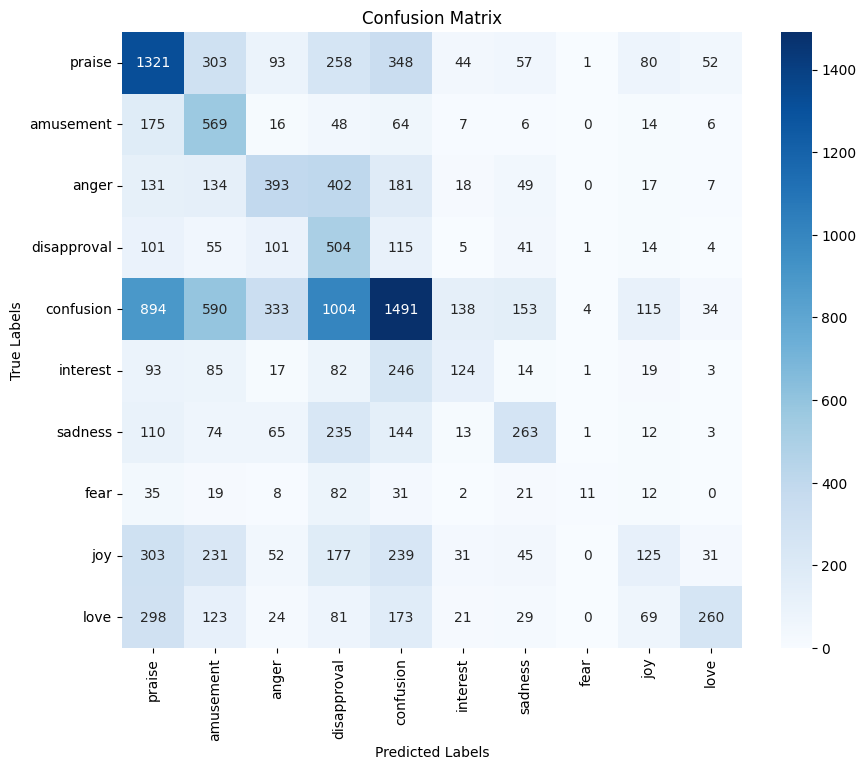

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================================
# Final Evaluation on the Test Set
# ================================
model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

        all_preds.append(preds_binary.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

average_test_loss = test_loss / len(test_loader)
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print(f"Test Loss: {average_test_loss:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# ================================
# Plot Confusion Matrix
# ================================
conf_matrix = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## last moedl with 50% of atual data without under sampling

In [ ]:
import torch
from tqdm import tqdm
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import classification_report, f1_score

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# ================================
# Define Thresholds for Each Emotion (Class)
# ================================
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}
label_names = data_sampled.columns[1:].tolist()
# ================================
# Split Train Data into Train and Validation
# ================================
sampled_test_texts, val_texts, sampled_test_labels, val_labels = train_test_split(
    sampled_test_texts, sampled_test_labels, test_size=0.1, random_state=42
)

# ================================
# Create Dataset and DataLoader for Train, Validation, and Test
# ================================
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=24)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training set size: {len(sampled_train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(sampled_test_texts)}")

# ================================
# Define Optimizer, Criterion, and Early Stopping
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3
best_f1_score = 0.0  # Track the best F1 score
epochs_without_improvement = 0
best_model_state_dict = None

# ================================
# Training Loop with Thresholds
# ================================
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    # ================================
    # Validation Phase
    # ================================
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

            all_preds.append(preds_binary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_avg_loss = val_loss / len(val_loader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Validation Loss: {val_avg_loss:.4f}, Average F1 Score: {f1:.4f}")

    # Early stopping logic based on F1 Score
    if f1 > best_f1_score:
        best_f1_score = f1
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in F1 Score for {patience} epochs.")
        break

# Load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on validation F1 Score.")


Training set size: 90298
Validation set size: 813
Test set size: 7314


Epoch 1: 100%|██████████| 5644/5644 [05:49<00:00, 16.14batch/s, loss=0.24]


Epoch 1, Loss: 0.2402
Validation Loss: 0.2521, Average F1 Score: 0.3087


Epoch 2: 100%|██████████| 5644/5644 [05:50<00:00, 16.08batch/s, loss=0.224]


Epoch 2, Loss: 0.2238
Validation Loss: 0.2557, Average F1 Score: 0.3276


Epoch 3: 100%|██████████| 5644/5644 [05:51<00:00, 16.05batch/s, loss=0.207]


Epoch 3, Loss: 0.2065
Validation Loss: 0.2780, Average F1 Score: 0.3551


Epoch 4: 100%|██████████| 5644/5644 [05:54<00:00, 15.94batch/s, loss=0.191]


Epoch 4, Loss: 0.1910
Validation Loss: 0.2862, Average F1 Score: 0.3366


Epoch 5: 100%|██████████| 5644/5644 [05:54<00:00, 15.94batch/s, loss=0.177]


Epoch 5, Loss: 0.1775
Validation Loss: 0.3029, Average F1 Score: 0.3637


Epoch 6: 100%|██████████| 5644/5644 [05:52<00:00, 16.00batch/s, loss=0.166]


Epoch 6, Loss: 0.1663
Validation Loss: 0.3532, Average F1 Score: 0.3712


Epoch 7: 100%|██████████| 5644/5644 [05:53<00:00, 15.96batch/s, loss=0.157]


Epoch 7, Loss: 0.1569
Validation Loss: 0.3610, Average F1 Score: 0.3445


Epoch 8: 100%|██████████| 5644/5644 [05:53<00:00, 15.99batch/s, loss=0.149]


Epoch 8, Loss: 0.1494
Validation Loss: 0.3784, Average F1 Score: 0.3466


Epoch 9: 100%|██████████| 5644/5644 [05:52<00:00, 16.00batch/s, loss=0.143]


Epoch 9, Loss: 0.1434
Validation Loss: 0.4034, Average F1 Score: 0.3634
Early stopping triggered. No improvement in F1 Score for 3 epochs.
Loaded the best model based on validation F1 Score.


Test Loss: 0.3996

Classification Report:
              precision    recall  f1-score   support

      praise       0.41      0.46      0.44      1187
   amusement       0.28      0.70      0.40       512
       anger       0.40      0.20      0.27       675
 disapproval       0.18      0.65      0.28       566
   confusion       0.37      0.93      0.53      2462
    interest       0.38      0.24      0.29       450
     sadness       0.30      0.61      0.40       589
        fear       0.00      0.00      0.00       150
         joy       0.27      0.49      0.35       936
        love       0.82      0.41      0.54       870

   micro avg       0.34      0.59      0.43      8397
   macro avg       0.34      0.47      0.35      8397
weighted avg       0.39      0.59      0.42      8397
 samples avg       0.39      0.61      0.45      8397



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


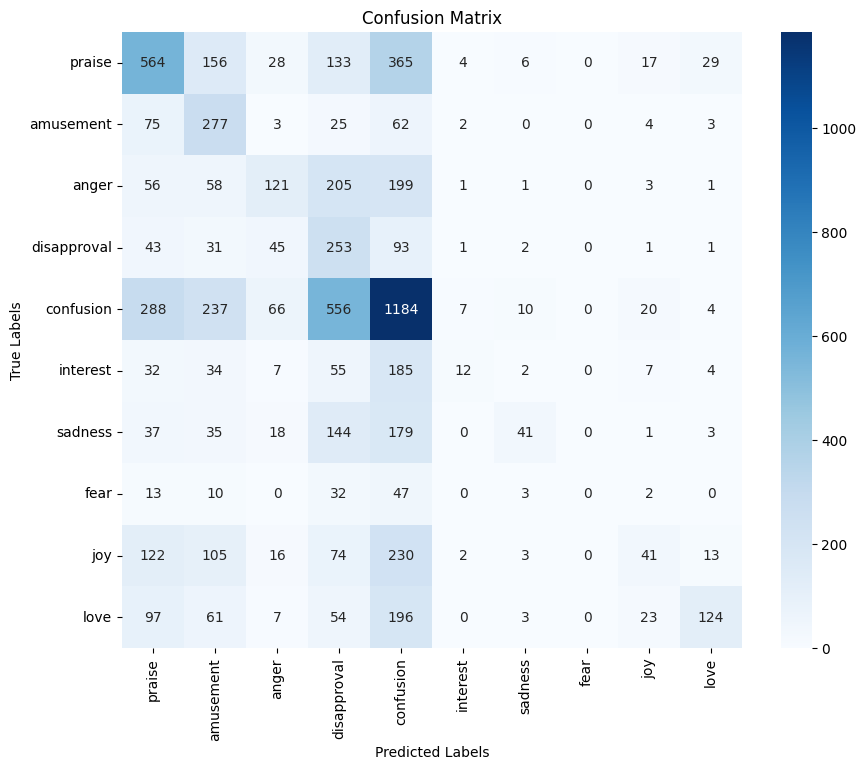

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================================
# Final Evaluation on the Test Set
# ================================
model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

        all_preds.append(preds_binary.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

average_test_loss = test_loss / len(test_loader)
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

print(f"Test Loss: {average_test_loss:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# ================================
# Plot Confusion Matrix
# ================================
conf_matrix = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## model 10 using bert

In [ ]:
import torch
from tqdm import tqdm
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import classification_report, f1_score

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# ================================
# Define Thresholds for Each Emotion (Class)
# ================================
thresholds = {
    "praise": 0.42603936791419983,
    "amusement": 0.025113416835665703,
    "anger": 0.635205090045929,
    "disapproval": 0.026239585131406784,
    "confusion": 0.0037548020482063293,
    "interest": 0.5196812152862549,
    "sadness": 0.11131349205970764,
    "fear": 0.9937723278999329,
    "joy": 0.145309180021286,
    "love": 0.8948039412498474
}
label_names = data_sampled.columns[1:].tolist()
# ================================
# Split Train Data into Train and Validation
# ================================
sampled_test_texts, val_texts, sampled_test_labels, val_labels = train_test_split(
    sampled_test_texts, sampled_test_labels, test_size=0.1, random_state=42
)

# ================================
# Create Dataset and DataLoader for Train, Validation, and Test
# ================================
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=24)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TextDataset(sampled_test_texts, sampled_test_labels, tokenizer, max_len=24)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training set size: {len(sampled_train_texts)}")
print(f"Validation set size: {len(val_texts)}")
print(f"Test set size: {len(sampled_test_texts)}")

# ================================
# Define Optimizer, Criterion, and Early Stopping
# ================================
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 3
best_f1_score = 0.0  # Track the best F1 score
epochs_without_improvement = 0
best_model_state_dict = None

# ================================
# Training Loop with Thresholds
# ================================
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0

    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch + 1}") as pbar:
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    import numpy as np
    from sklearn.metrics import f1_score

    # ================================
    # Validation Phase
    # ================================
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    correct_predictions = 0  # Track number of samples where all labels are correct
    total_samples = 0  # Track total number of samples

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

            all_preds.append(preds_binary.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Count correct predictions (where all labels are correct)
            for i in range(preds_binary.size(0)):  # For each sample in the batch
                total_samples += 1
                if np.array_equal(preds_binary[i].cpu().numpy(), labels[i].cpu().numpy()):
                    correct_predictions += 1

    val_avg_loss = val_loss / len(val_loader)
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Compute F1 Score
    f1 = f1_score(all_labels, all_preds, average='macro')

    # Calculate Accuracy (fraction of samples with all correct labels)
    accuracy = correct_predictions / total_samples

    print(f"Validation Loss: {val_avg_loss:.4f}, Average F1 Score: {f1:.4f}, Validation Accuracy: {accuracy * 100:.2f}%")


    # Early stopping logic based on F1 Score
    if f1 > best_f1_score:
        best_f1_score = f1
        epochs_without_improvement = 0
        best_model_state_dict = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered. No improvement in F1 Score for {patience} epochs.")
        break

# Load the best model
if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print("Loaded the best model based on validation F1 Score.")


Training set size: 18059
Validation set size: 181
Test set size: 1625


Epoch 1: 100%|██████████| 1129/1129 [02:26<00:00,  7.70batch/s, loss=0.287]


Epoch 1, Loss: 0.2866
Validation Loss: 0.2865, Average F1 Score: 0.2305, Validation Accuracy: 4.97%


Epoch 2: 100%|██████████| 1129/1129 [01:58<00:00,  9.56batch/s, loss=0.244]


Epoch 2, Loss: 0.2440
Validation Loss: 0.2784, Average F1 Score: 0.2618, Validation Accuracy: 4.42%


Epoch 3: 100%|██████████| 1129/1129 [01:56<00:00,  9.67batch/s, loss=0.207]


Epoch 3, Loss: 0.2066
Validation Loss: 0.3015, Average F1 Score: 0.3036, Validation Accuracy: 8.29%


Epoch 4: 100%|██████████| 1129/1129 [01:56<00:00,  9.67batch/s, loss=0.165]


Epoch 4, Loss: 0.1651
Validation Loss: 0.3341, Average F1 Score: 0.3505, Validation Accuracy: 9.94%


Epoch 5: 100%|██████████| 1129/1129 [01:56<00:00,  9.66batch/s, loss=0.131]


Epoch 5, Loss: 0.1314
Validation Loss: 0.3592, Average F1 Score: 0.3409, Validation Accuracy: 11.05%


Epoch 6: 100%|██████████| 1129/1129 [01:56<00:00,  9.68batch/s, loss=0.108]


Epoch 6, Loss: 0.1078
Validation Loss: 0.4067, Average F1 Score: 0.3134, Validation Accuracy: 9.94%


Epoch 7: 100%|██████████| 1129/1129 [01:56<00:00,  9.67batch/s, loss=0.0905]


Epoch 7, Loss: 0.0905
Validation Loss: 0.4233, Average F1 Score: 0.3266, Validation Accuracy: 16.57%
Early stopping triggered. No improvement in F1 Score for 3 epochs.
Loaded the best model based on validation F1 Score.


Test Loss: 0.3872
Test Accuracy: 15.45%

Classification Report:
              precision    recall  f1-score   support

      praise       0.47      0.43      0.45       254
   amusement       0.27      0.53      0.35       109
       anger       0.46      0.26      0.34       148
 disapproval       0.19      0.60      0.29       126
   confusion       0.34      0.99      0.51       545
    interest       0.41      0.41      0.41       110
     sadness       0.32      0.51      0.39       136
        fear       0.00      0.00      0.00        34
         joy       0.30      0.41      0.35       217
        love       0.75      0.53      0.62       188

   micro avg       0.34      0.60      0.44      1867
   macro avg       0.35      0.47      0.37      1867
weighted avg       0.39      0.60      0.43      1867
 samples avg       0.38      0.62      0.45      1867



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


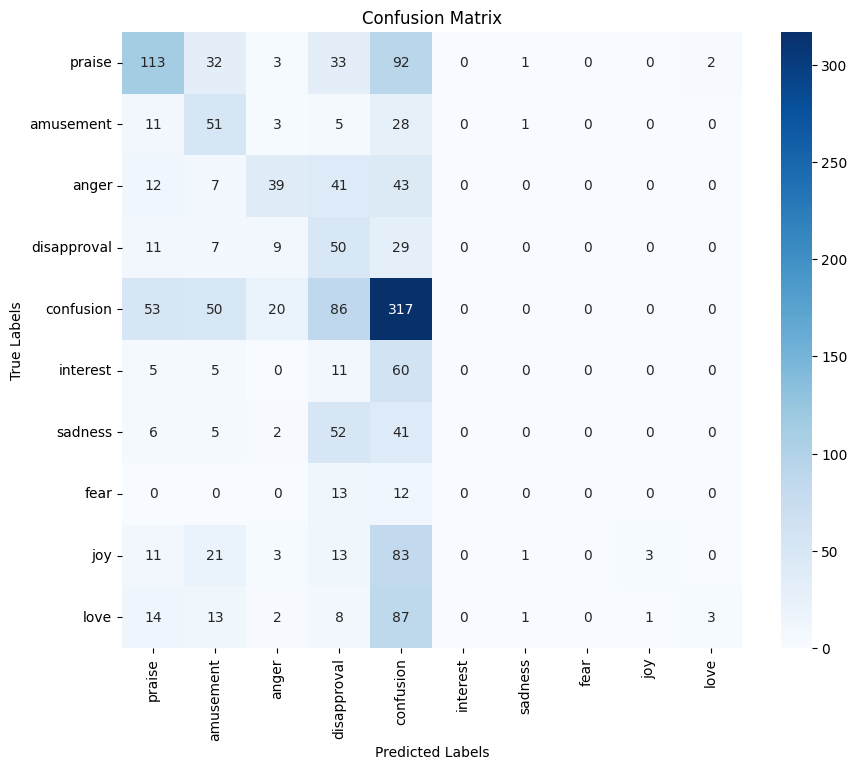

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ================================
# Final Evaluation on the Test Set
# ================================
model.eval()
test_loss = 0
all_preds = []
all_labels = []
correct_predictions = 0  # Track number of samples where all labels are correct
total_samples = 0  # Track total number of samples

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.sigmoid(outputs)
        preds_binary = (preds > torch.tensor([thresholds[label] for label in label_names], device=device)).float()

        all_preds.append(preds_binary.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Count correct predictions (where all labels are correct)
        for i in range(preds_binary.size(0)):  # For each sample in the batch
            total_samples += 1
            if np.array_equal(preds_binary[i].cpu().numpy(), labels[i].cpu().numpy()):
                correct_predictions += 1

# Compute the average test loss
average_test_loss = test_loss / len(test_loader)

# Stack the predictions and labels
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Calculate accuracy (fraction of samples with all correct labels)
accuracy = correct_predictions / total_samples

# Print the results
print(f"Test Loss: {average_test_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")  # Print the accuracy as percentage
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_names))

# ================================
# Plot Confusion Matrix
# ================================
conf_matrix = confusion_matrix(all_labels.argmax(axis=1), all_preds.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


## model 11 trainong 10 different model

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset, DatasetDict


### preprocess

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Tokenizer Setup and Data Preparation

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Accessing the text and label directly using index
        text = str(self.texts.iloc[idx])  # Ensure using iloc for pandas DataFrame for text
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Direct access for numpy array

        # Tokenizing the text
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {key: inputs[key].squeeze(0) for key in inputs.keys()}, label


data_sampled = data_sampled.reset_index(drop=True)

# Define the text and labels
text = data_sampled['text']  # This is the text column
labels = data_sampled.drop('text', axis=1)  # All other columns are the labels

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# Check the shapes to confirm the split
print(f"Training text shape: {X_train.shape}, Test text shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

# Convert to datasets
train_dataset = MultilabelDataset(X_train, y_train.values, tokenizer)
test_dataset = MultilabelDataset(X_test, y_test.values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Training text shape: (16052,), Test text shape: (4014,)
Training labels shape: (16052, 10), Test labels shape: (4014, 10)


In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
print(data_sampled.index)  # Check the indexes
print(y_train.shape)       # Check shape of labels


RangeIndex(start=0, stop=20066, step=1)
(16052, 10)


In [ ]:

# Step 2: Define Model Training Loop

from sklearn.metrics import accuracy_score, f1_score
import torch
from sklearn.metrics import accuracy_score, f1_score
import torch
from tqdm import tqdm  # Progress bar

def train_model_for_label(label_idx, train_loader, val_loader):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Early stopping parameters
    best_val_accuracy = 0
    epochs_without_improvement = 0
    max_epochs_without_improvement = 3

    for epoch in range(10):  # Train for a maximum of 10 epochs
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        # Use tqdm to create a progress bar for batches
        epoch_progress = tqdm(train_loader, desc=f"Training label {label_idx+1}, Epoch {epoch+1}", unit="batch")

        for batch in epoch_progress:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)[:, label_idx]  # Use the current label index for prediction

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels.unsqueeze(1))
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Predicted labels (rounded to binary)
            preds = torch.sigmoid(logits).squeeze().cpu().detach().numpy() >= 0.5
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

            # Update progress bar with the batch loss
            epoch_progress.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)

        # Calculate metrics for the entire epoch
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='micro')

        print(f"\nEpoch {epoch + 1} - Label {label_idx + 1}:")
        print(f"  Average Loss: {avg_loss:.4f}")
        print(f"  Epoch Accuracy: {epoch_accuracy:.4f}")
        print(f"  Epoch F1 Score: {epoch_f1:.4f}")

        # Validation evaluation
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)[:, label_idx]  # Get the current label for validation
                outputs = model(**inputs, labels=labels.unsqueeze(1))
                logits = outputs.logits

                preds = torch.sigmoid(logits).squeeze().cpu().detach().numpy() >= 0.5
                val_preds.append(preds)
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='micro')

        print(f"Validation - Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_improvement:
            print("Early stopping...")
            break

    return model



# Step 3: Train models for each label
# Split your training set into train and validation
X_train, X_val,y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

# Create new dataloaders for validation
val_dataset = MultilabelDataset(X_val, y_val.values, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

models = []
for i in range(10):  # Assuming 10 labels in your dataset
    print(f"Training model for label {i + 1}")
    model = train_model_for_label(i, train_loader, val_loader)
    models.append(model)


Training model for label 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 1, Epoch 1: 100%|██████████| 1004/1004 [05:49<00:00,  2.87batch/s, loss=0.349]



Epoch 1 - Label 1:
  Average Loss: 0.1165
  Epoch Accuracy: 0.2397
  Epoch F1 Score: 0.2397
Validation - Accuracy: 0.1544, F1 Score: 0.1544


Training label 1, Epoch 2: 100%|██████████| 1004/1004 [05:46<00:00,  2.89batch/s, loss=0.0969]



Epoch 2 - Label 1:
  Average Loss: 0.0955
  Epoch Accuracy: 0.2755
  Epoch F1 Score: 0.2755
Validation - Accuracy: 0.1820, F1 Score: 0.1820


Training label 1, Epoch 3: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.137]



Epoch 3 - Label 1:
  Average Loss: 0.0742
  Epoch Accuracy: 0.3263
  Epoch F1 Score: 0.3263
Validation - Accuracy: 0.6162, F1 Score: 0.6162


Training label 1, Epoch 4: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.0104]



Epoch 4 - Label 1:
  Average Loss: 0.0538
  Epoch Accuracy: 0.3765
  Epoch F1 Score: 0.3765
Validation - Accuracy: 0.3012, F1 Score: 0.3012


Training label 1, Epoch 5: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.0002]



Epoch 5 - Label 1:
  Average Loss: 0.0396
  Epoch Accuracy: 0.4173
  Epoch F1 Score: 0.4173
Validation - Accuracy: 0.6529, F1 Score: 0.6529


Training label 1, Epoch 6: 100%|██████████| 1004/1004 [05:46<00:00,  2.89batch/s, loss=0.000882]



Epoch 6 - Label 1:
  Average Loss: 0.0335
  Epoch Accuracy: 0.4330
  Epoch F1 Score: 0.4330
Validation - Accuracy: 0.1865, F1 Score: 0.1865


Training label 1, Epoch 7: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.00367]



Epoch 7 - Label 1:
  Average Loss: 0.0296
  Epoch Accuracy: 0.4349
  Epoch F1 Score: 0.4349
Validation - Accuracy: 0.4113, F1 Score: 0.4113


Training label 1, Epoch 8: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.000631]



Epoch 8 - Label 1:
  Average Loss: 0.0265
  Epoch Accuracy: 0.4470
  Epoch F1 Score: 0.4470
Validation - Accuracy: 0.3211, F1 Score: 0.3211
Early stopping...
Training model for label 2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 2, Epoch 1: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.00632]



Epoch 1 - Label 2:
  Average Loss: 0.0571
  Epoch Accuracy: 0.3185
  Epoch F1 Score: 0.3185
Validation - Accuracy: 0.7385, F1 Score: 0.7385


Training label 2, Epoch 2: 100%|██████████| 1004/1004 [05:45<00:00,  2.90batch/s, loss=0.213]



Epoch 2 - Label 2:
  Average Loss: 0.0479
  Epoch Accuracy: 0.3308
  Epoch F1 Score: 0.3308
Validation - Accuracy: 0.1254, F1 Score: 0.1254


Training label 2, Epoch 3: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.00285]



Epoch 3 - Label 2:
  Average Loss: 0.0422
  Epoch Accuracy: 0.3603
  Epoch F1 Score: 0.3603
Validation - Accuracy: 0.8471, F1 Score: 0.8471


Training label 2, Epoch 4: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.049]



Epoch 4 - Label 2:
  Average Loss: 0.0337
  Epoch Accuracy: 0.3978
  Epoch F1 Score: 0.3978
Validation - Accuracy: 0.5505, F1 Score: 0.5505


Training label 2, Epoch 5: 100%|██████████| 1004/1004 [05:46<00:00,  2.90batch/s, loss=0.00201]



Epoch 5 - Label 2:
  Average Loss: 0.0257
  Epoch Accuracy: 0.4160
  Epoch F1 Score: 0.4160
Validation - Accuracy: 0.6177, F1 Score: 0.6177


Training label 2, Epoch 6: 100%|██████████| 1004/1004 [05:45<00:00,  2.90batch/s, loss=0.0426]



Epoch 6 - Label 2:
  Average Loss: 0.0206
  Epoch Accuracy: 0.4278
  Epoch F1 Score: 0.4278
Validation - Accuracy: 0.0780, F1 Score: 0.0780
Early stopping...
Training model for label 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 3, Epoch 1:   0%|          | 1/1004 [00:00<07:48,  2.14batch/s, loss=0.171]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 10022 has 14.73 GiB memory in use. Of the allocated memory 13.65 GiB is allocated by PyTorch, and 965.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(models)

[BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## using distil bert instead

In [ ]:
import torch

# After each batch in training or testing loop
torch.cuda.empty_cache()


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

data_sampled = data_sampled.reset_index(drop=True)

# Define the text and labels
text = data_sampled['text']  # This is the text column
labels = data_sampled.drop('text', axis=1)  # All other columns are the labels

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# Check the shapes to confirm the split
print(f"Training text shape: {X_train.shape}, Test text shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

# Replace the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=y_train.shape[1]).to(device)
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Tokenizer Setup and Data Preparation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Accessing the text and label directly using index
        text = str(self.texts.iloc[idx])  # Ensure using iloc for pandas DataFrame for text
        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Direct access for numpy array

        # Tokenizing the text
        inputs = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {key: inputs[key].squeeze(0) for key in inputs.keys()}, label

# Assuming data_sampled is already defined as your dataframe

data_sampled = data_sampled.reset_index(drop=True)

# Define the text and labels
text = data_sampled['text']  # This is the text column
labels = data_sampled.drop('text', axis=1)  # All other columns are the labels

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42)

# Check the shapes to confirm the split
print(f"Training text shape: {X_train.shape}, Test text shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

# Convert to datasets
train_dataset = MultilabelDataset(X_train, y_train.values, tokenizer)
test_dataset = MultilabelDataset(X_test, y_test.values, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False,num_workers=4)

# Initialize the DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=y_train.shape[1]).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Training text shape: (8026,), Test text shape: (2007,)
Training labels shape: (8026, 10), Test labels shape: (2007, 10)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training text shape: (8026,), Test text shape: (2007,)
Training labels shape: (8026, 10), Test labels shape: (2007, 10)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm  # Progress bar

# Ensure device is CUDA or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 2: Define Model Training Loop

def train_model_for_label(label_idx, train_loader, val_loader, tokenizer):
    # Use DistilBERT instead of BERT
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1).to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Early stopping parameters
    best_val_accuracy = 0
    epochs_without_improvement = 0
    max_epochs_without_improvement = 3

    for epoch in range(4):  # Train for a maximum of 10 epochs
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        # Use tqdm to create a progress bar for batches
        epoch_progress = tqdm(train_loader, desc=f"Training label {label_idx+1}, Epoch {epoch+1}", unit="batch")

        for batch in epoch_progress:
            inputs, labels = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}
            labels = labels.to(device)[:, label_idx]  # Use the current label index for prediction

            optimizer.zero_grad()
            outputs = model(**inputs, labels=labels.unsqueeze(1))
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Predicted labels (rounded to binary)
            preds = torch.sigmoid(logits).squeeze().cpu().detach().numpy() >= 0.5
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

            # Update progress bar with the batch loss
            epoch_progress.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)

        # Calculate metrics for the entire epoch
        all_preds = np.concatenate(all_preds, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='micro')

        print(f"\nEpoch {epoch + 1} - Label {label_idx + 1}:")
        print(f"  Average Loss: {avg_loss:.4f}")
        print(f"  Epoch Accuracy: {epoch_accuracy:.4f}")
        print(f"  Epoch F1 Score: {epoch_f1:.4f}")

        # Validation evaluation
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = {key: val.to(device) for key, val in inputs.items()}
                labels = labels.to(device)[:, label_idx]  # Get the current label for validation
                outputs = model(**inputs, labels=labels.unsqueeze(1))
                logits = outputs.logits

                preds = torch.sigmoid(logits).squeeze().cpu().detach().numpy() >= 0.5
                val_preds.append(preds)
                val_labels.append(labels.cpu().numpy())

        val_preds = np.concatenate(val_preds, axis=0)
        val_labels = np.concatenate(val_labels, axis=0)

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='micro')

        print(f"Validation - Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= max_epochs_without_improvement:
            print("Early stopping...")
            break

    # Save the model after training
    model_save_path = f"distilbert_model_label_{label_idx+1}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model for label {label_idx+1} saved to {model_save_path}")

    return model


# Step 3: Train models for each label
# Split your training set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

# Create new dataloaders for validation
val_dataset = MultilabelDataset(X_val, y_val.values, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

models = []
for i in range(10):  # Assuming 10 labels in your dataset
    print(f"Training model for label {i + 1}")
    model = train_model_for_label(i, train_loader, val_loader, tokenizer)
    models.append(model)


Training model for label 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 1, Epoch 1: 100%|██████████| 502/502 [01:33<00:00,  5.35batch/s, loss=0.0808]



Epoch 1 - Label 1:
  Average Loss: 0.1164
  Epoch Accuracy: 0.2098
  Epoch F1 Score: 0.2098
Validation - Accuracy: 0.2438, F1 Score: 0.2438


Training label 1, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 1, Epoch 2: 100%|██████████| 502/502 [01:29<00:00,  5.60batch/s, loss=0.123]



Epoch 2 - Label 1:
  Average Loss: 0.0934
  Epoch Accuracy: 0.2807
  Epoch F1 Score: 0.2807
Validation - Accuracy: 0.1791, F1 Score: 0.1791


Training label 1, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 1, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.86batch/s, loss=0.0182]



Epoch 3 - Label 1:
  Average Loss: 0.0666
  Epoch Accuracy: 0.3557
  Epoch F1 Score: 0.3557
Validation - Accuracy: 0.3458, F1 Score: 0.3458


Training label 1, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 1, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.0154]



Epoch 4 - Label 1:
  Average Loss: 0.0421
  Epoch Accuracy: 0.4251
  Epoch F1 Score: 0.4251
Validation - Accuracy: 0.4303, F1 Score: 0.4303
Model for label 1 saved to distilbert_model_label_1.pth
Training model for label 2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 2, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 2:
  Average Loss: 0.0521
  Epoch Accuracy: 0.2756
  Epoch F1 Score: 0.2756
Validation - Accuracy: 0.0721, F1 Score: 0.0721


Training label 2, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 2, Epoch 2: 100%|██████████| 502/502 [01:24<00:00,  5.92batch/s, loss=0.0881]



Epoch 2 - Label 2:
  Average Loss: 0.0441
  Epoch Accuracy: 0.3258
  Epoch F1 Score: 0.3258
Validation - Accuracy: 0.1244, F1 Score: 0.1244


Training label 2, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 2, Epoch 3: 100%|██████████| 502/502 [01:24<00:00,  5.91batch/s, loss=0.00318]



Epoch 3 - Label 2:
  Average Loss: 0.0365
  Epoch Accuracy: 0.3799
  Epoch F1 Score: 0.3799
Validation - Accuracy: 0.4527, F1 Score: 0.4527


Training label 2, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 2, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.00192]



Epoch 4 - Label 2:
  Average Loss: 0.0278
  Epoch Accuracy: 0.4246
  Epoch F1 Score: 0.4246
Validation - Accuracy: 0.9030, F1 Score: 0.9030
Model for label 2 saved to distilbert_model_label_2.pth
Training model for label 3


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 3, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 3:
  Average Loss: 0.0789
  Epoch Accuracy: 0.2106
  Epoch F1 Score: 0.2106
Validation - Accuracy: 0.1070, F1 Score: 0.1070


Training label 3, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 3, Epoch 2: 100%|██████████| 502/502 [01:29<00:00,  5.62batch/s, loss=0.0205]



Epoch 2 - Label 3:
  Average Loss: 0.0636
  Epoch Accuracy: 0.2902
  Epoch F1 Score: 0.2902
Validation - Accuracy: 0.3856, F1 Score: 0.3856


Training label 3, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 3, Epoch 3: 100%|██████████| 502/502 [01:28<00:00,  5.66batch/s, loss=0.00403]



Epoch 3 - Label 3:
  Average Loss: 0.0439
  Epoch Accuracy: 0.3548
  Epoch F1 Score: 0.3548
Validation - Accuracy: 0.2861, F1 Score: 0.2861


Training label 3, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 3, Epoch 4: 100%|██████████| 502/502 [01:28<00:00,  5.65batch/s, loss=0.000955]



Epoch 4 - Label 3:
  Average Loss: 0.0271
  Epoch Accuracy: 0.4044
  Epoch F1 Score: 0.4044
Validation - Accuracy: 0.4478, F1 Score: 0.4478
Model for label 3 saved to distilbert_model_label_3.pth
Training model for label 4


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 4, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 4:
  Average Loss: 0.0697
  Epoch Accuracy: 0.2441
  Epoch F1 Score: 0.2441
Validation - Accuracy: 0.3209, F1 Score: 0.3209


Training label 4, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 4, Epoch 2: 100%|██████████| 502/502 [01:28<00:00,  5.65batch/s, loss=0.00428]



Epoch 2 - Label 4:
  Average Loss: 0.0574
  Epoch Accuracy: 0.3061
  Epoch F1 Score: 0.3061
Validation - Accuracy: 0.1368, F1 Score: 0.1368


Training label 4, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 4, Epoch 3: 100%|██████████| 502/502 [01:26<00:00,  5.79batch/s, loss=0.00154]



Epoch 3 - Label 4:
  Average Loss: 0.0359
  Epoch Accuracy: 0.4000
  Epoch F1 Score: 0.4000
Validation - Accuracy: 0.1642, F1 Score: 0.1642


Training label 4, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 4, Epoch 4: 100%|██████████| 502/502 [01:30<00:00,  5.57batch/s, loss=0.00386]



Epoch 4 - Label 4:
  Average Loss: 0.0199
  Epoch Accuracy: 0.4241
  Epoch F1 Score: 0.4241
Validation - Accuracy: 0.3980, F1 Score: 0.3980
Model for label 4 saved to distilbert_model_label_4.pth
Training model for label 5


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 5, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 5:
  Average Loss: 0.2090
  Epoch Accuracy: 0.3512
  Epoch F1 Score: 0.3512
Validation - Accuracy: 0.3483, F1 Score: 0.3483


Training label 5, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 5, Epoch 2: 100%|██████████| 502/502 [01:26<00:00,  5.79batch/s, loss=0.122]



Epoch 2 - Label 5:
  Average Loss: 0.1734
  Epoch Accuracy: 0.3729
  Epoch F1 Score: 0.3729
Validation - Accuracy: 0.3806, F1 Score: 0.3806


Training label 5, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 5, Epoch 3: 100%|██████████| 502/502 [01:27<00:00,  5.73batch/s, loss=0.112]



Epoch 3 - Label 5:
  Average Loss: 0.1208
  Epoch Accuracy: 0.4198
  Epoch F1 Score: 0.4198
Validation - Accuracy: 0.3781, F1 Score: 0.3781


Training label 5, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 5, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.89batch/s, loss=0.182]



Epoch 4 - Label 5:
  Average Loss: 0.0707
  Epoch Accuracy: 0.4848
  Epoch F1 Score: 0.4848
Validation - Accuracy: 0.3557, F1 Score: 0.3557
Model for label 5 saved to distilbert_model_label_5.pth
Training model for label 6


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 6, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 6:
  Average Loss: 0.0535
  Epoch Accuracy: 0.2973
  Epoch F1 Score: 0.2973
Validation - Accuracy: 0.6368, F1 Score: 0.6368


Training label 6, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 6, Epoch 2: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.00253]



Epoch 2 - Label 6:
  Average Loss: 0.0451
  Epoch Accuracy: 0.3504
  Epoch F1 Score: 0.3504
Validation - Accuracy: 0.0920, F1 Score: 0.0920


Training label 6, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 6, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.88batch/s, loss=0.0468]



Epoch 3 - Label 6:
  Average Loss: 0.0344
  Epoch Accuracy: 0.3879
  Epoch F1 Score: 0.3879
Validation - Accuracy: 0.4900, F1 Score: 0.4900


Training label 6, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 6, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.0199]



Epoch 4 - Label 6:
  Average Loss: 0.0200
  Epoch Accuracy: 0.4550
  Epoch F1 Score: 0.4550
Validation - Accuracy: 0.2786, F1 Score: 0.2786
Early stopping...
Model for label 6 saved to distilbert_model_label_6.pth
Training model for label 7


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 7, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 7:
  Average Loss: 0.0667
  Epoch Accuracy: 0.2565
  Epoch F1 Score: 0.2565
Validation - Accuracy: 0.0896, F1 Score: 0.0896


Training label 7, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 7, Epoch 2: 100%|██████████| 502/502 [01:24<00:00,  5.91batch/s, loss=0.148]



Epoch 2 - Label 7:
  Average Loss: 0.0506
  Epoch Accuracy: 0.3165
  Epoch F1 Score: 0.3165
Validation - Accuracy: 0.4975, F1 Score: 0.4975


Training label 7, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 7, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.89batch/s, loss=0.006]



Epoch 3 - Label 7:
  Average Loss: 0.0343
  Epoch Accuracy: 0.3828
  Epoch F1 Score: 0.3828
Validation - Accuracy: 0.1642, F1 Score: 0.1642


Training label 7, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 7, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.89batch/s, loss=0.00291]



Epoch 4 - Label 7:
  Average Loss: 0.0199
  Epoch Accuracy: 0.4475
  Epoch F1 Score: 0.4475
Validation - Accuracy: 0.1940, F1 Score: 0.1940
Model for label 7 saved to distilbert_model_label_7.pth
Training model for label 8


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 8, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 8:
  Average Loss: 0.0240
  Epoch Accuracy: 0.3278
  Epoch F1 Score: 0.3278
Validation - Accuracy: 0.9328, F1 Score: 0.9328


Training label 8, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 8, Epoch 2: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.00108]



Epoch 2 - Label 8:
  Average Loss: 0.0186
  Epoch Accuracy: 0.3600
  Epoch F1 Score: 0.3600
Validation - Accuracy: 0.0522, F1 Score: 0.0522


Training label 8, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 8, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.00355]



Epoch 3 - Label 8:
  Average Loss: 0.0127
  Epoch Accuracy: 0.4113
  Epoch F1 Score: 0.4113
Validation - Accuracy: 0.0274, F1 Score: 0.0274


Training label 8, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 8, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.089]



Epoch 4 - Label 8:
  Average Loss: 0.0084
  Epoch Accuracy: 0.4139
  Epoch F1 Score: 0.4139
Validation - Accuracy: 0.0249, F1 Score: 0.0249
Early stopping...
Model for label 8 saved to distilbert_model_label_8.pth
Training model for label 9


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 9, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. P


Epoch 1 - Label 9:
  Average Loss: 0.1048
  Epoch Accuracy: 0.1834
  Epoch F1 Score: 0.1834
Validation - Accuracy: 0.1045, F1 Score: 0.1045


Training label 9, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 9, Epoch 2: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.0848]



Epoch 2 - Label 9:
  Average Loss: 0.0906
  Epoch Accuracy: 0.2151
  Epoch F1 Score: 0.2151
Validation - Accuracy: 0.2935, F1 Score: 0.2935


Training label 9, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 9, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.179]



Epoch 3 - Label 9:
  Average Loss: 0.0720
  Epoch Accuracy: 0.3051
  Epoch F1 Score: 0.3051
Validation - Accuracy: 0.1020, F1 Score: 0.1020


Training label 9, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 9, Epoch 4: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.012]



Epoch 4 - Label 9:
  Average Loss: 0.0445
  Epoch Accuracy: 0.3813
  Epoch F1 Score: 0.3813
Validation - Accuracy: 0.1692, F1 Score: 0.1692
Model for label 9 saved to distilbert_model_label_9.pth
Training model for label 10


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training label 10, Epoch 1:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. 


Epoch 1 - Label 10:
  Average Loss: 0.0657
  Epoch Accuracy: 0.3140
  Epoch F1 Score: 0.3140
Validation - Accuracy: 0.1741, F1 Score: 0.1741


Training label 10, Epoch 2:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 10, Epoch 2: 100%|██████████| 502/502 [01:25<00:00,  5.88batch/s, loss=0.0048]



Epoch 2 - Label 10:
  Average Loss: 0.0520
  Epoch Accuracy: 0.3526
  Epoch F1 Score: 0.3526
Validation - Accuracy: 0.4328, F1 Score: 0.4328


Training label 10, Epoch 3:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 10, Epoch 3: 100%|██████████| 502/502 [01:25<00:00,  5.90batch/s, loss=0.104]



Epoch 3 - Label 10:
  Average Loss: 0.0409
  Epoch Accuracy: 0.3948
  Epoch F1 Score: 0.3948
Validation - Accuracy: 0.3134, F1 Score: 0.3134


Training label 10, Epoch 4:   0%|          | 0/502 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training label 10, Epoch 4: 100%|██████████| 502/502 [01:24<00:00,  5.91batch/s, loss=0.108]



Epoch 4 - Label 10:
  Average Loss: 0.0275
  Epoch Accuracy: 0.4292
  Epoch F1 Score: 0.4292
Validation - Accuracy: 0.1990, F1 Score: 0.1990
Model for label 10 saved to distilbert_model_label_10.pth


Making predictions for label 1:   0%|          | 0/126 [00:00<?, ?batch/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Making predictions for label 10: 100%|██████████| 126/126 [00:07<00:00, 17.02batch/s]


Overall Accuracy: 0.0000
Average F1 Score: 0.2312


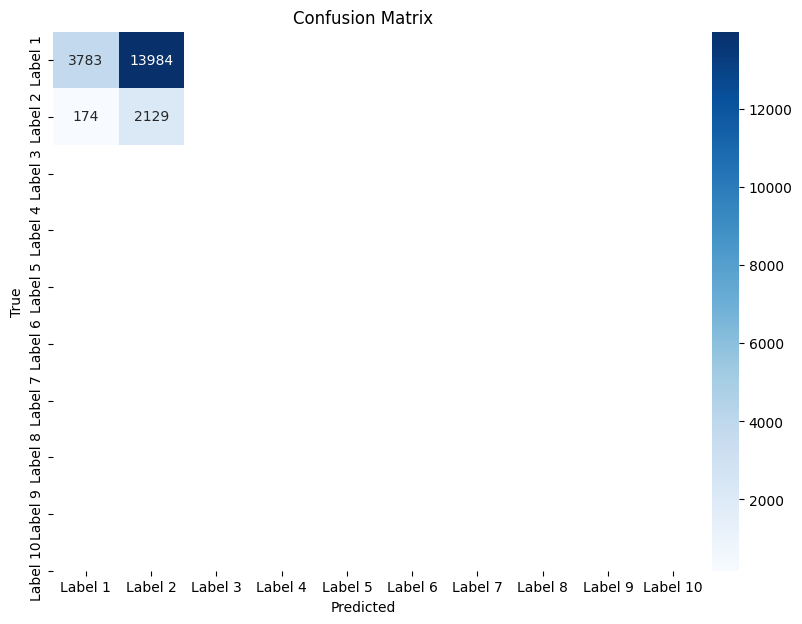

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
from tqdm import tqdm  # For progress bar
import seaborn as sns
import matplotlib.pyplot as plt

# Step 4: Make Predictions

# Initialize prediction array for 10 labels
y_pred = np.zeros((len(X_test), 10))  # Assuming 10 labels
y_test = y_test.values  # Convert the true labels to numpy for compatibility

# Iterate through each model for each label
for i, model in enumerate(models):
    model.eval()  # Set the model to evaluation mode
    all_preds = []

    # Create a progress bar for the prediction loop
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Making predictions for label {i + 1}", unit="batch"):
            inputs, _ = batch
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # Get the model output (logits)
            outputs = model(**inputs)
            logits = outputs.logits

            # Apply sigmoid to get probabilities and threshold them at 0.5 for binary classification
            preds = torch.sigmoid(logits).squeeze().cpu().numpy() >= 0.5
            all_preds.append(preds)

    # Store the predictions for the i-th label
    y_pred[:, i] = np.concatenate(all_preds, axis=0)

# Step 5: Calculate Metrics

# Accuracy for each sample (all labels correct)
sample_accuracy = np.all(y_pred == y_test, axis=1)
accuracy = np.mean(sample_accuracy)
print(f"Overall Accuracy: {accuracy:.4f}")

# Average F1 score (micro-average for multilabel classification)
avg_f1 = f1_score(y_test, y_pred, average='micro')
print(f"Average F1 Score: {avg_f1:.4f}")

# Confusion Matrix (flattened for multilabel classification)
cm = confusion_matrix(y_test.flatten(), y_pred.flatten())

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=[f"Label {i+1}" for i in range(10)], yticklabels=[f"Label {i+1}" for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## using bert

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score

# ======================================
# 1. Prepare Your Data from the DataFrame
# ======================================

# Assume your DataFrame 'data_sampled' has:
# - The first column (index 0) as text
# - All remaining columns (index 1 onward) as emotion labels with values 0 or 1
# For example, your DataFrame columns might be:
# ['text', 'praise', 'amusement', 'anger', 'disapproval', 'confusion',
#  'interest', 'sadness', 'fear', 'joy', 'love']

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:-1])

# Convert the emotion columns to float (if not already) to ensure proper type.
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
# Each row in "labels" will be a list of floats (one for each emotion).
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Now, select only the columns that match your schema: "text" and "labels"
data_sampled = data_sampled[['text', 'labels']]

# (Optional) If your DataFrame has an index column like "__index_level_0__" from a previous operation,
# you can reset the index to remove it:
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that the "labels" column is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset with the defined features.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# The splits are available as split_dataset['train'] and split_dataset['test']

# ======================================
# 2. Tokenization
# ======================================
model_name = "bert-base-uncased"  # or another model of your choice
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Fixed-length padding for consistency
        max_length=128         # Adjust max_length as needed
    )

# Tokenize the dataset (the "labels" column remains untouched)
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

# ======================================
# 3. Prepare the Model for Multi-Label Classification
# ======================================
NUM_LABELS = len(emotion_cols)  # should be 10 if you have 10 emotion columns

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ======================================
# 4. Training Arguments and Metrics
# ======================================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,       # Adjust based on your GPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid, then threshold at 0.5
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy().astype(int)
    micro_f1 = f1_score(labels, predictions, average="micro")
    macro_f1 = f1_score(labels, predictions, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

# ======================================
# 5. Initialize Trainer and Train
# ======================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],  # Using the test split as validation
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


Map:   0%|          | 0/9029 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.324000,0.276831,0.316883,0.173840
2,0.261900,0.264784,0.373786,0.270173
3,0.234300,0.264414,0.412162,0.297415


TrainOutput(global_step=1695, training_loss=0.2680618601211053, metrics={'train_runtime': 645.7371, 'train_samples_per_second': 41.947, 'train_steps_per_second': 2.625, 'total_flos': 1781850268058112.0, 'train_loss': 0.2680618601211053, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions on the test set using the trained model.
# 'tokenized_datasets["test"]' is our test dataset.
pred_output = trainer.predict(tokenized_datasets["test"])
logits, labels, _ = pred_output

# Convert logits to probabilities with sigmoid, then threshold at 0.5 for binary predictions.
probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
predictions = (probabilities > 0.5).astype(int)

# Compute metrics for micro and macro averages.
precision_micro = precision_score(labels, predictions, average="micro")
recall_micro = recall_score(labels, predictions, average="micro")
f1_micro = f1_score(labels, predictions, average="micro")

precision_macro = precision_score(labels, predictions, average="macro")
recall_macro = recall_score(labels, predictions, average="macro")
f1_macro = f1_score(labels, predictions, average="macro")

print("Evaluation on Test Set:")
print("Micro Precision: {:.4f}".format(precision_micro))
print("Micro Recall:    {:.4f}".format(recall_micro))
print("Micro F1:        {:.4f}".format(f1_micro))
print("Macro Precision: {:.4f}".format(precision_macro))
print("Macro Recall:    {:.4f}".format(recall_macro))
print("Macro F1:        {:.4f}".format(f1_macro))


Evaluation on Test Set:
Micro Precision: 0.5819
Micro Recall:    0.3191
Micro F1:        0.4122
Macro Precision: 0.4636
Macro Recall:    0.2412
Macro F1:        0.2974


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## bert with balancin

In [ ]:
dataa=data_sampled

In [ ]:
data_sampled=dataa

In [ ]:
data_sampled.T

,24679,156634,107263,3382,65689,159824,174211,40951,61054,28686,...,97234,107221,12886,98894,18813,43975,35390,91344,190767,56412
text,Some drown. Others look to the sky. I thought ...,"What a very ""centrist"" thing to say.","I’d give this comment a gold if I could!! Yes,...",And it's stopped. Training cancelled :-),im actually really pumped to see how [NAME] do...,I’m sorry friend. I actually used to be pretty...,"Well you wrote out this big comment, and it re...",Yup. I don't want to soil the paper unless I h...,Weird flex but ok,"I do, in fact, want more from OP’s work history",...,ah dang sorry. in that case idk.,"[NAME] was good in ""My Love from the Star"".","Dude, you're being gaslit right now by someone...",Oh man that hurt to watch,It’s rebranded as the ‘Quarter Note Hotel’. Fo...,Or it could have just never happened because n...,"Thanks, totally makes sense, just need to get ...",You should have gone and joined her for a drin...,Pls provide a timestamp to their antimigration...,WON ME 1K LAST GAME IN PARLAY!!
praise,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
amusement,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
anger,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
disapproval,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
confusion,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
interest,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
sadness,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
fear,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
joy,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score

# ======================================
# 1. Prepare Your Data from the DataFrame
# ======================================

# Assume your DataFrame 'data_sampled' has:
# - The first column (index 0) as text
# - All remaining columns (index 1 onward) as emotion labels with values 0 or 1
# For example, the DataFrame columns might be:
# ['text', 'praise', 'amusement', 'anger', 'disapproval', 'confusion',
#  'interest', 'sadness', 'fear', 'joy', 'love']

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already) to ensure proper type.
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
# Each row in "labels" will be a list of floats (one for each emotion).
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Now, select only the columns that match your schema: "text" and "labels"
data_sampled = data_sampled[['text', 'labels']]

# (Optional) If your DataFrame has an index column like "__index_level_0__" from a previous operation,
# you can reset the index to remove it:
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that the "labels" column is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset with the defined features.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# ======================================
# 2. Tokenization
# ======================================
model_name = "bert-base-uncased"  # or another model of your choice
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Fixed-length padding for consistency
        max_length=128         # Adjust max_length as needed
    )

# Tokenize the dataset (the "labels" column remains untouched)
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

# ======================================
# 3. Prepare the Model for Multi-Label Classification
# ======================================
NUM_LABELS = len(emotion_cols)  # should match the number of emotion columns

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ======================================
# 4. Training Arguments and Metrics
# ======================================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,       # Adjust based on your GPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid, then threshold at 0.5
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy().astype(int)
    micro_f1 = f1_score(labels, predictions, average="micro")
    macro_f1 = f1_score(labels, predictions, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

# ======================================
# 5. Compute Per-Class Positive Weights for Imbalanced Data
# ======================================
# For each label, pos_weight = (# negatives) / (# positives)
train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

# ======================================
# 6. Create a Custom Trainer with Weighted Loss
# ======================================
class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        # Use BCEWithLogitsLoss with pos_weight for imbalanced multi-label classification.
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ======================================
# 7. Initialize Trainer and Train
# ======================================
trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# Train the model (the progress bar will be displayed in your console)
trainer.train()


Map:   0%|          | 0/9029 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.3854, 13.7052,  9.6474, 11.9170,  2.0187, 14.9805, 11.7348, 40.2283,
         6.8106,  7.1489])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.079800,0.931963,0.389498,0.361609
2,0.887300,0.903771,0.413931,0.394664
3,0.766200,0.903720,0.430538,0.402274


TrainOutput(global_step=1695, training_loss=0.8936470234288578, metrics={'train_runtime': 659.9258, 'train_samples_per_second': 41.046, 'train_steps_per_second': 2.568, 'total_flos': 1781850268058112.0, 'train_loss': 0.8936470234288578, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Get predictions on the test set using the trained model.
# 'tokenized_datasets["test"]' is our test dataset.
pred_output = trainer.predict(tokenized_datasets["test"])
logits, labels, _ = pred_output

# Convert logits to probabilities with sigmoid, then threshold at 0.5 for binary predictions.
probabilities = torch.sigmoid(torch.tensor(logits)).numpy()
predictions = (probabilities > 0.5).astype(int)

# Compute metrics for micro and macro averages.
precision_micro = precision_score(labels, predictions, average="micro")
recall_micro = recall_score(labels, predictions, average="micro")
f1_micro = f1_score(labels, predictions, average="micro")

precision_macro = precision_score(labels, predictions, average="macro")
recall_macro = recall_score(labels, predictions, average="macro")
f1_macro = f1_score(labels, predictions, average="macro")

print("Evaluation on Test Set:")
print("Micro Precision: {:.4f}".format(precision_micro))
print("Micro Recall:    {:.4f}".format(recall_micro))
print("Micro F1:        {:.4f}".format(f1_micro))
print("Macro Precision: {:.4f}".format(precision_macro))
print("Macro Recall:    {:.4f}".format(recall_macro))
print("Macro F1:        {:.4f}".format(f1_macro))


Evaluation on Test Set:
Micro Precision: 0.3066
Micro Recall:    0.7228
Micro F1:        0.4305
Macro Precision: 0.2881
Macro Recall:    0.7220
Macro F1:        0.4023


## tf-idf with logistic regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ======================================
# 1. Prepare Your Data
# ======================================
# Assume your DataFrame 'data_sampled' has two columns: 'text' and 'labels'.
# Each entry in 'labels' is a list (or array) of 10 binary values,
# for example: [0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
X = data_sampled['text']

# Convert the labels column into a NumPy array of shape (n_samples, 10)
# (This assumes that each entry in data_sampled['labels'] is already a list/array of length 10.)
y_binary = np.array(data_sampled['labels'].tolist())

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.1, random_state=42
)

# ======================================
# 2. Build the Pipeline for Multi-Label Classification
# ======================================
# Since this is a multi-label classification task with 10 classes,
# we use OneVsRestClassifier to wrap LogisticRegression.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', OneVsRestClassifier(LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )))
])

# ======================================
# 3. Train the Model
# ======================================
pipeline.fit(X_train, y_train)

# ======================================
# 4. Evaluate the Model
# ======================================
y_pred = pipeline.predict(X_test)

# Define target names for the 10 classes.
# (Modify these names as needed, or use simple class labels "Class 0" to "Class 9".)
target_names = [f"Class {i}" for i in range(10)]

print("Classification Report (Multi-Label Logistic Regression):\n")
print(classification_report(y_test, y_pred, target_names=target_names))

# ======================================
# 5. Print Some Sample Predictions
# ======================================
def binary_to_labels(binary_array, classes):
    """
    Convert a binary indicator row to a list of class names.

    Parameters:
      binary_array : array-like of shape (n_samples, n_classes)
      classes      : list of class names
    Returns:
      A list of lists, where each inner list contains the class names for which the value is 1.
    """
    return [
        [classes[i] for i, val in enumerate(row) if val == 1]
        for row in binary_array
    ]

# Convert the binary indicator arrays to human-readable label lists.
true_labels = binary_to_labels(y_test, target_names)
pred_labels = binary_to_labels(y_pred, target_names)

# Create a DataFrame to display some sample predictions.
sample_results = pd.DataFrame({
    "Text": X_test,
    "True Label(s)": true_labels,
    "Predicted Label(s)": pred_labels
})

print("\nSome sample predictions:")
print(sample_results.sample(5, random_state=42))


Classification Report (Multi-Label Logistic Regression):

              precision    recall  f1-score   support

     Class 0       0.35      0.44      0.39       169
     Class 1       0.37      0.49      0.42        74
     Class 2       0.30      0.44      0.36        98
     Class 3       0.14      0.33      0.20        63
     Class 4       0.45      0.64      0.53       319
     Class 5       0.23      0.46      0.31        56
     Class 6       0.30      0.45      0.36        91
     Class 7       0.29      0.24      0.26        29
     Class 8       0.33      0.44      0.38       137
     Class 9       0.59      0.75      0.66       122

   micro avg       0.36      0.52      0.43      1158
   macro avg       0.34      0.47      0.39      1158
weighted avg       0.38      0.52      0.44      1158
 samples avg       0.39      0.52      0.42      1158


Some sample predictions:
                                                   Text       True Label(s)  \
6982  made my first redd

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## finding best hyper parameters

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.3 MB/s eta 0:00:00


In [ ]:
data_sampled=dataa

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score

# ======================================
# 1. Prepare Your Data from the DataFrame
# ======================================

emotion_cols = list(data_sampled.columns[1:-1])
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})
dataset = Dataset.from_pandas(data_sampled, features=features)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# ======================================
# 2. Tokenization
# ======================================
model_name = "bert-base-uncased"  # or another model of your choice
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_datasets = split_dataset.map(tokenize_function, batched=True)

# ======================================
# 3. Prepare the Model for Multi-Label Classification
# ======================================
NUM_LABELS = len(emotion_cols)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification"
    )

# ======================================
# 4. Training Arguments and Metrics
# ======================================
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,                   # baseline; will be tuned
    per_device_train_batch_size=16,       # baseline; will be tuned
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,                    # baseline; will be tuned
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy().astype(int)
    micro_f1 = f1_score(labels, predictions, average="micro")
    macro_f1 = f1_score(labels, predictions, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

# ======================================
# 5. Compute Per-Class Positive Weights for Imbalanced Data
# ======================================
train_labels = np.array(tokenized_datasets["train"]["labels"])
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

# ======================================
# 6. Create a Custom Trainer with Weighted Loss
# ======================================
class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ======================================
# 7. Initialize Trainer with model_init for Hyperparameter Search
# ======================================
trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

# ======================================
# 8. Define the Hyperparameter Search Space using updated suggestion functions
# ======================================
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32])
    }

# ======================================
# 9. Run Hyperparameter Search with the Optuna backend
# ======================================
best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    backend="optuna",  # ensures an Optuna trial is provided
    n_trials=10,
    direction="maximize",
    compute_objective=lambda metrics: metrics["eval_macro_f1"],  # Note the "eval_" prefix
)


print("Best hyperparameters found:")
print(best_run.hyperparameters)
print("Best macro_f1:", best_run.objective)

# ======================================
# 10. (Optional) Re-train the Model with the Best Hyperparameters
# ======================================
for key, value in best_run.hyperparameters.items():
    setattr(trainer.args, key, value)

best_model = model_init()
trainer.model = best_model

print("\nStarting training with best hyperparameters...")
trainer.train()


Map:   0%|          | 0/9029 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Per-class pos_weight: tensor([ 5.3854, 13.7052,  9.6474, 11.9170,  2.0187, 14.9805, 11.7348, 40.2283,
         6.8106,  7.1489])


[I 2025-02-03 10:34:33,074] A new study created in memory with name: no-name-b4326664-0bba-4a16-8891-500c9deac9ac
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,▁
eval/macro_f1,▁
eval/micro_f1,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁
train/global_step,▁
eval/loss,1.14278
eval/macro_f1,0.24666
eval/micro_f1,0.25857


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,1.124424,0.265458,0.252873
2,1.147100,1.063478,0.310357,0.282468
3,1.147100,1.038054,0.331272,0.297446


[I 2025-02-03 10:44:35,345] Trial 0 finished with value: 0.29744617954715613 and parameters: {'learning_rate': 8.992203559230869e-06, 'weight_decay': 0.03039411788875137, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.29744617954715613.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,█▃▁
eval/macro_f1,▁▆█
eval/micro_f1,▁▆█
eval/runtime,█▆▁
eval/samples_per_second,▁▃█
eval/steps_per_second,▁▃█
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.922059,0.400289,0.382116
2,0.951900,0.881970,0.421025,0.401336
3,0.951900,0.909289,0.445564,0.420692


[I 2025-02-03 10:54:29,720] Trial 1 finished with value: 0.4206924450299284 and parameters: {'learning_rate': 4.7194702827278034e-05, 'weight_decay': 0.21065850069444927, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.4206924450299284.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,█▁▆
eval/macro_f1,▁▄█
eval/micro_f1,▁▄█
eval/runtime,▆█▁
eval/samples_per_second,▃▁█
eval/steps_per_second,▃▁█
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,1.216214,0.213996,0.183462
2,1.226500,1.208734,0.221550,0.195169


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,1.216214,0.213996,0.183462
2,1.226500,1.208734,0.221550,0.195169
3,1.226500,1.205837,0.219993,0.194072


[I 2025-02-03 11:04:18,811] Trial 2 finished with value: 0.1940721549096669 and parameters: {'learning_rate': 1.2055585251851935e-06, 'weight_decay': 0.01513274941184619, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.4206924450299284.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/loss,█▃▁
eval/macro_f1,▁█▇
eval/micro_f1,▁█▇
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▄▅██
train/global_step,▁▄▅██
train/grad_norm,▁
train/learning_rate,▁
train/loss,▁


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.079700,0.923083,0.407425,0.381066
2,0.865800,0.885558,0.425103,0.403479


{'learning_rate': 4.7194702827278034e-05,
 'weight_decay': 0.21065850069444927,
 'per_device_train_batch_size': 32}


## finding best treshholds

In [ ]:
def find_best_thresholds_per_label(trainer, dataset, step=0.05):
    """
    Searches for the best threshold for each label independently.

    Args:
        trainer: The Hugging Face Trainer that has been trained.
        dataset: The tokenized dataset on which to evaluate (e.g., the validation set).
        step: Step size for threshold search (default: 0.05).

    Returns:
        best_thresholds: A list of best thresholds for each label.
        best_f1s: A list of the corresponding F1 scores for each label.
    """
    result = trainer.predict(dataset)
    logits = result.predictions
    true_labels = result.label_ids

    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)
    num_labels = probabilities.shape[1]

    best_thresholds = []
    best_f1s = []

    # Iterate over each label (column)
    for i in range(num_labels):
        best_thresh = 0.5
        best_f1 = 0.0
        for thresh in np.arange(0.0, 1.0, step):
            preds_bin = (probabilities[:, i] > thresh).astype(int)
            f1 = f1_score(true_labels[:, i], preds_bin)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
        best_thresholds.append(best_thresh)
        best_f1s.append(best_f1)

    return best_thresholds, best_f1s

# Example usage:
# IMPORTANT: Ensure you pass the tokenized validation dataset, not the raw one.
best_thresholds, best_f1s = find_best_thresholds_per_label(trainer, tokenized_datasets["test"], step=0.05)
for idx, (thresh, f1_val) in enumerate(zip(best_thresholds, best_f1s)):
    print(f"Label {idx}: Best threshold = {thresh}, F1 = {f1_val}")


Label 0: Best threshold = 0.7000000000000001, F1 = 0.4652777777777778
Label 1: Best threshold = 0.8500000000000001, F1 = 0.5757575757575758
Label 2: Best threshold = 0.65, F1 = 0.4
Label 3: Best threshold = 0.8, F1 = 0.34831460674157305
Label 4: Best threshold = 0.55, F1 = 0.5894206549118388
Label 5: Best threshold = 0.8, F1 = 0.40993788819875776
Label 6: Best threshold = 0.8500000000000001, F1 = 0.43209876543209874
Label 7: Best threshold = 0.9, F1 = 0.45901639344262296
Label 8: Best threshold = 0.6000000000000001, F1 = 0.3956639566395664
Label 9: Best threshold = 0.8500000000000001, F1 = 0.6351931330472103


## applying hyoer parameters and the balanced data i had

In [ ]:
sampled_dataa=sampled_data

In [ ]:
testtt=sampled_test

In [ ]:
sampled_data.T

,0,1,2,3,4,5,6,7,8,9,...,93857,93858,93859,93860,93861,93862,93863,93864,93865,93866
text,"But you do know it, so that's good","fyi, straight men also use dildos. Also, your ...","Good for you, maybe some day you'll come to an...",This is the best thing I've ever seen on Reddit,You can't. It's best you go see a professional...,THEY ARE SO CUTE TOGETHER!!,She has major SB😖,"It was balanced by also adding relics , you co...",Such a great actor because he can play so many...,@ the corner in Litchfield is really good and ...,...,"oof okay, thanks for the info. Hopefully he fa...",Thank you.,"Lol, I’m surprised more people didn’t catch th...",It's good if you hate workers and love pollution,THANK YOU [NAME],You need to talk to her openly about this... w...,thank u for bein a friend,"Thanks so much for the precious advice, that i...","I appreciate your post, I’m just nervous is al...","Mmh, I love the smell of thought policing in t..."
label_0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,1,0
label_1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
label_2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
label_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label_6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label_7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
label_8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrames
##############################################

# --- For the Training DataFrame: sampled_data ---
# Assume sampled_data has columns: "text", "label_0", "label_1", ..., "label_9"
emotion_cols = list(sampled_data.columns[1:])  # All columns except "text"

# Ensure the label columns are floats.
sampled_data[emotion_cols] = sampled_data[emotion_cols].astype(float)

# Combine the label columns into a single "labels" column (each row becomes a list of floats).
sampled_data["labels"] = sampled_data[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Keep only the columns required: "text" and "labels".
sampled_data = sampled_data[['text', 'labels']]
sampled_data = sampled_data.reset_index(drop=True)

# --- For the Test DataFrame: sampled_test ---
# Assume sampled_test has the same structure as sampled_data.
emotion_cols_test = list(sampled_test.columns[1:])
sampled_test[emotion_cols_test] = sampled_test[emotion_cols_test].astype(float)
sampled_test["labels"] = sampled_test[emotion_cols_test].apply(lambda row: row.tolist(), axis=1)
sampled_test = sampled_test[['text', 'labels']]
sampled_test = sampled_test.reset_index(drop=True)

##############################################
# 2. Convert DataFrames to Hugging Face Datasets
##############################################

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrames to datasets.
train_dataset = Dataset.from_pandas(sampled_data, features=features)
test_dataset = Dataset.from_pandas(sampled_test, features=features)

##############################################
# 3. Tokenization
##############################################

model_name = "bert-base-uncased"  # or another pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Fixed-length padding for consistency
        max_length=128         # Adjust max_length as needed
    )

# Tokenize the training and test datasets separately.
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

##############################################
# 4. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should be 10 in your case

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

##############################################
# 5. Training Arguments and Metrics
##############################################

# Best hyperparameters from your search
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # You can adjust this if needed
    num_train_epochs=3,
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid, then threshold at 0.5
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy().astype(int)
    micro_f1 = f1_score(labels, predictions, average="micro")
    macro_f1 = f1_score(labels, predictions, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 6. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

# Extract the "labels" from the tokenized training dataset.
train_labels = np.array(tokenized_train["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 7. Create a Custom Trainer with Weighted Loss
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        # Use BCEWithLogitsLoss with pos_weight for imbalanced multi-label classification.
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,  # Using the test dataset for evaluation
    compute_metrics=compute_metrics,
)

##############################################
# 8. Train the Model
##############################################

trainer.train()


Map:   0%|          | 0/10322 [00:00<?, ? examples/s]

Map:   0%|          | 0/1004 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 4.2988, 10.7295,  8.4524,  9.9575,  2.1701, 11.5115,  9.2604, 33.0660,
         5.0047,  5.6896])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.840108,0.391235,0.368305
2,0.896400,0.860242,0.418235,0.394075
3,0.896400,0.893181,0.439791,0.415223


TrainOutput(global_step=969, training_loss=0.7536930363736778, metrics={'train_runtime': 698.7799, 'train_samples_per_second': 44.314, 'train_steps_per_second': 1.387, 'total_flos': 2037020541244416.0, 'train_loss': 0.7536930363736778, 'epoch': 3.0})

## using distil bert instead

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Fixed-length padding for consistency
        max_length=128         # Adjust max_length as needed
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=3,                   # Increase epochs if needed; early stopping is enabled
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=4,             # Use 4 worker processes for data loading (adjust as needed)
    fp16=True                             # Enable mixed precision training (FP16)
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/9029 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1004 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.3854, 13.7052,  9.6474, 11.9170,  2.0187, 14.9805, 11.7348, 40.2283,
         6.8106,  7.1489])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,No log,0.918018,0.439769,0.394629
2,0.948900,0.893972,0.456338,0.450763
3,0.948900,0.919304,0.468504,0.450901


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

TrainOutput(global_step=849, training_loss=0.8560317975191402, metrics={'train_runtime': 106.6546, 'train_samples_per_second': 253.969, 'train_steps_per_second': 7.96, 'total_flos': 897164085772800.0, 'train_loss': 0.8560317975191402, 'epoch': 3.0})

## balanced bert and tf-idf with half data

### tf-idf

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# ======================================
# 1. Prepare Your Data
# ======================================
# Assume your DataFrame 'data_sampled' has two columns: 'text' and 'labels'.
# Each entry in 'labels' is a list (or array) of 10 binary values,
# for example: [0, 1, 0, 0, 1, 0, 0, 0, 0, 1]

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already) to ensure proper type.
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
# Each row in "labels" will be a list of floats (one for each emotion).
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Now, select only the columns that match your schema: "text" and "labels"
data_sampled = data_sampled[['text', 'labels']]

# (Optional) If your DataFrame has an index column like "__index_level_0__" from a previous operation,
# you can reset the index to remove it:
data_sampled = data_sampled.reset_index(drop=True)

X = data_sampled['text']

# Convert the labels column into a NumPy array of shape (n_samples, 10)
# (This assumes that each entry in data_sampled['labels'] is already a list/array of length 10.)
y_binary = np.array(data_sampled['labels'].tolist())

# Split the dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.1, random_state=42
)

# ======================================
# 2. Build the Pipeline for Multi-Label Classification
# ======================================
# Since this is a multi-label classification task with 10 classes,
# we use OneVsRestClassifier to wrap LogisticRegression.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', OneVsRestClassifier(LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )))
])

# ======================================
# 3. Train the Model
# ======================================
pipeline.fit(X_train, y_train)

# ======================================
# 4. Evaluate the Model
# ======================================
y_pred = pipeline.predict(X_test)

# Define target names for the 10 classes.
# (Modify these names as needed, or use simple class labels "Class 0" to "Class 9".)
target_names = [f"Class {i}" for i in range(10)]

print("Classification Report (Multi-Label Logistic Regression):\n")
print(classification_report(y_test, y_pred, target_names=target_names))

# ======================================
# 5. Print Some Sample Predictions
# ======================================
def binary_to_labels(binary_array, classes):
    """
    Convert a binary indicator row to a list of class names.

    Parameters:
      binary_array : array-like of shape (n_samples, n_classes)
      classes      : list of class names
    Returns:
      A list of lists, where each inner list contains the class names for which the value is 1.
    """
    return [
        [classes[i] for i, val in enumerate(row) if val == 1]
        for row in binary_array
    ]

# Convert the binary indicator arrays to human-readable label lists.
true_labels = binary_to_labels(y_test, target_names)
pred_labels = binary_to_labels(y_pred, target_names)

# Create a DataFrame to display some sample predictions.
sample_results = pd.DataFrame({
    "Text": X_test,
    "True Label(s)": true_labels,
    "Predicted Label(s)": pred_labels
})

print("\nSome sample predictions:")
print(sample_results.sample(5, random_state=42))


Classification Report (Multi-Label Logistic Regression):

              precision    recall  f1-score   support

     Class 0       0.36      0.62      0.46      1614
     Class 1       0.30      0.72      0.42       664
     Class 2       0.25      0.63      0.36       957
     Class 3       0.20      0.67      0.31       741
     Class 4       0.48      0.68      0.56      3305
     Class 5       0.22      0.67      0.33       650
     Class 6       0.26      0.64      0.37       800
     Class 7       0.16      0.60      0.25       219
     Class 8       0.26      0.59      0.36      1285
     Class 9       0.51      0.75      0.61      1220

   micro avg       0.32      0.66      0.43     11455
   macro avg       0.30      0.66      0.40     11455
weighted avg       0.36      0.66      0.45     11455
 samples avg       0.37      0.66      0.44     11455


Some sample predictions:
                                                    Text True Label(s)  \
9314   July 15, 1996: Yanks t

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### bert

It  takes 3 hours for 50% of data each epoch-___-

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

model_name = "bert-base-uncased"  # or another model of your choice
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Fixed-length padding for consistency
        max_length=128         # Adjust max_length as needed
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=20,                   # Increase epochs if needed; early stopping is enabled
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=4,             # Use 4 worker processes for data loading (adjust as needed)
    fp16=True                           # Enable mixed precision training (FP16)
)

import numpy as np
import torch
from sklearn.metrics import f1_score

# Define your best thresholds (one per label)
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds:
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}


##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,  # <-- Updated function here!
    callbacks=[early_stopping_callback]
)


##############################################
# 7. Train the Model
##############################################

trainer.train()


## distil bert

In [ ]:
import psutil

cpu_cores = psutil.cpu_count(logical=False)  # For physical cores
logical_cores = psutil.cpu_count(logical=True) # For logical cores (including hyperthreading)
print("Physical CPU cores:", cpu_cores)
print("Logical CPU cores:", logical_cores)


Physical CPU cores: 1
Logical CPU cores: 2


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here
        max_length=20
    )


# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=20,                   # Increase epochs if needed; early stopping is enabled
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,             # Use 4 worker processes for data loading (adjust as needed)
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator  # Add this line
)


##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/90298 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10034 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.2642, 13.4062,  9.4608, 11.9293,  2.0111, 14.6387, 11.5240, 45.2119,
         6.8418,  7.3811])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.900100,0.894105,0.473355,0.456550
2,0.830300,0.913427,0.482528,0.458412
3,0.715800,0.941385,0.473584,0.450855
4,0.630800,1.088408,0.469542,0.440618


TrainOutput(global_step=11288, training_loss=0.7727942355214746, metrics={'train_runtime': 691.8038, 'train_samples_per_second': 2610.509, 'train_steps_per_second': 81.584, 'total_flos': 1869257453232000.0, 'train_loss': 0.7727942355214746, 'epoch': 4.0})

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here
        max_length=64
    )


# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=20,                   # Increase epochs if needed; early stopping is enabled
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,             # Use 4 worker processes for data loading (adjust as needed)
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator  # Add this line
)


##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/90298 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10034 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.2642, 13.4062,  9.4608, 11.9293,  2.0111, 14.6387, 11.5240, 45.2119,
         6.8418,  7.3811])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.847900,0.831379,0.487878,0.473631
2,0.785300,0.844576,0.496568,0.474039


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.847900,0.831379,0.487878,0.473631
2,0.785300,0.844576,0.496568,0.474039
3,0.678100,0.917831,0.483390,0.464929
4,0.603900,1.043733,0.485806,0.458422


TrainOutput(global_step=11288, training_loss=0.7328819123504011, metrics={'train_runtime': 736.7178, 'train_samples_per_second': 2451.359, 'train_steps_per_second': 76.61, 'total_flos': 3398823144565200.0, 'train_loss': 0.7328819123504011, 'epoch': 4.0})

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here
        max_length=128
    )


# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=20,                   # Increase epochs if needed; early stopping is enabled
    weight_decay=best_hyperparams["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,             # Use 4 worker processes for data loading (adjust as needed)
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator  # Add this line
)


##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/90298 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10034 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.2642, 13.4062,  9.4608, 11.9293,  2.0111, 14.6387, 11.5240, 45.2119,
         6.8418,  7.3811])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.850700,0.831324,0.488121,0.473257
2,0.784900,0.847217,0.493674,0.473005
3,0.677400,0.912741,0.483391,0.460806


TrainOutput(global_step=8466, training_loss=0.7802692920694727, metrics={'train_runtime': 550.5771, 'train_samples_per_second': 3280.122, 'train_steps_per_second': 102.511, 'total_flos': 2556109374532200.0, 'train_loss': 0.7802692920694727, 'epoch': 3.0})

##higher drop out

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here
        max_length=128
    )


# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.3

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

# Increase dropout rates further (if allowed by the model's config)
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

# Adjust training arguments: lower number of epochs or change early stopping
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Consider reducing epochs if overfitting is severe
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increase weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,
    dataloader_pin_memory=True
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator  # Add this line
)


##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/90298 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10034 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.2642, 13.4062,  9.4608, 11.9293,  2.0111, 14.6387, 11.5240, 45.2119,
         6.8418,  7.3811])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.851100,0.830310,0.493336,0.474952
2,0.780700,0.839827,0.501089,0.474966
3,0.674900,0.913473,0.487716,0.465558
4,0.596000,1.069025,0.486769,0.459494


TrainOutput(global_step=11288, training_loss=0.730603070059708, metrics={'train_runtime': 741.6997, 'train_samples_per_second': 1217.447, 'train_steps_per_second': 38.048, 'total_flos': 3407037295016400.0, 'train_loss': 0.730603070059708, 'epoch': 4.0})

## adding warmup

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here so that we use dynamic padding later via the data collator.
        max_length=128
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
# Increase dropout rates further (if allowed by the model's config)
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

# Define training arguments with warmup
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=10,                   # Consider reducing epochs if overfitting is severe
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increase weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Create data collator to handle dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/90298 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/10034 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.2642, 13.4062,  9.4608, 11.9293,  2.0111, 14.6387, 11.5240, 45.2119,
         6.8418,  7.3811])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.854100,0.832790,0.487994,0.472462
2,0.787900,0.844212,0.494231,0.474584
3,0.681300,0.907317,0.489171,0.466776


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.854100,0.832790,0.487994,0.472462
2,0.787900,0.844212,0.494231,0.474584
3,0.681300,0.907317,0.489171,0.466776
4,0.599700,1.069377,0.480708,0.456188


TrainOutput(global_step=11288, training_loss=0.7402383302814314, metrics={'train_runtime': 801.4744, 'train_samples_per_second': 1126.649, 'train_steps_per_second': 35.21, 'total_flos': 3407037295016400.0, 'train_loss': 0.7402383302814314, 'epoch': 4.0})

## with hole data

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here so that we use dynamic padding later via the data collator.
        max_length=128
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
# Increase dropout rates further (if allowed by the model's config)
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

# Define training arguments with warmup
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=10,                   # Consider reducing epochs if overfitting is severe
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increase weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Create data collator to handle dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/180597 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20067 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.3294, 13.3604,  9.3947, 11.9192,  1.9992, 14.8822, 11.3968, 45.1767,
         6.8252,  7.4222])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.838600,0.813878,0.493416,0.479370
2,0.783600,0.808976,0.499750,0.481428
3,0.735500,0.838605,0.512468,0.484693
4,0.659700,0.927543,0.485218,0.471573
5,0.607900,1.083281,0.493207,0.468959


TrainOutput(global_step=28220, training_loss=0.7195943906744856, metrics={'train_runtime': 1885.2179, 'train_samples_per_second': 957.964, 'train_steps_per_second': 29.938, 'total_flos': 8515770774662100.0, 'train_loss': 0.7195943906744856, 'epoch': 5.0})

In [ ]:


# Define the directory where you want to save the model and tokenizer.
model_save_path = "./final_model"

# Save the final model, its configuration, and the tokenizer.
trainer.save_model(model_save_path)         # Saves the model and its configuration
tokenizer.save_pretrained(model_save_path)    # Saves the tokenizer

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to ./final_model


## using whole data and balanced data

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here so that we use dynamic padding later via the data collator.
        max_length=128
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
# Increase dropout rates further (if allowed by the model's config)
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

# Define training arguments with warmup
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=10,                   # Consider reducing epochs if overfitting is severe
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increase weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Create data collator to handle dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/180597 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20067 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.3294, 13.3604,  9.3947, 11.9192,  1.9992, 14.8822, 11.3968, 45.1767,
         6.8252,  7.4222])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.837600,0.816333,0.495662,0.479579
2,0.785000,0.810917,0.495602,0.479422
3,0.733000,0.836544,0.514986,0.487879
4,0.657800,0.914802,0.487060,0.473357
5,0.606200,1.039375,0.488518,0.466867


TrainOutput(global_step=28220, training_loss=0.7206194157806548, metrics={'train_runtime': 1860.0131, 'train_samples_per_second': 970.945, 'train_steps_per_second': 30.344, 'total_flos': 8515770774662100.0, 'train_loss': 0.7206194157806548, 'epoch': 5.0})

In [ ]:


# Define the directory where you want to save the model and tokenizer.
model_save_path = "./final_model"

# Save the final model, its configuration, and the tokenizer.
trainer.save_model(model_save_path)         # Saves the model and its configuration
tokenizer.save_pretrained(model_save_path)    # Saves the tokenizer

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to ./final_model


In [ ]:
# If using Google Colab, mount your Google Drive first.
from google.colab import drive
drive.mount('/content/drive')

# Define the path on your Google Drive where you want to save the model.
# For example, this will save the model in a folder named 'final_model' in your MyDrive.
model_save_path = "/content/drive/MyDrive/final_model"


trainer.save_model(model_save_path)         # Saves the model and its configuration
tokenizer.save_pretrained(model_save_path)    # Saves the tokenizer

print(f"Model and tokenizer have been saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer have been saved to /content/drive/MyDrive/final_model


## bert  without early stopping

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrames
##############################################

# Assume you have two DataFrames:
# - sampled_data: training data with "text" and emotion label columns.
# - sampled_test: testing data with the same columns.

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(sampled_data.columns[1:])

# Ensure the emotion columns are floats.
sampled_data[emotion_cols] = sampled_data[emotion_cols].astype(float)
sampled_test[emotion_cols] = sampled_test[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
sampled_data["labels"] = sampled_data[emotion_cols].apply(lambda row: row.tolist(), axis=1)
sampled_test["labels"] = sampled_test[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
sampled_data = sampled_data[['text', 'labels']].reset_index(drop=True)
sampled_test = sampled_test[['text', 'labels']].reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrames to Hugging Face Datasets.
train_dataset = Dataset.from_pandas(sampled_data, features=features)
test_dataset = Dataset.from_pandas(sampled_test, features=features)

# Split the test dataset into validation and final test sets (e.g., 50% each).
split_test = test_dataset.train_test_split(test_size=0.9, seed=42)
val_dataset = split_test["train"]
final_test_dataset = split_test["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use BERT instead of DistilBERT.
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128  # adjust as needed
    )

# Tokenize the datasets.
tokenized_train = train_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_val = val_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_test = final_test_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Number of emotion labels

# Load BERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# Increase dropout rates for more regularization.
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increased weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label.
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_train["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 6 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=6)

# Create data collator to handle dynamic padding.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()

# After training, you can evaluate on the final test dataset:
results = trainer.evaluate(eval_dataset=tokenized_test)
print("Final test set evaluation results:", results)


Map (num_proc=4):   0%|          | 0/93867 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/18061 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 4.9602,  6.4121,  6.0108,  6.2183,  6.0260,  6.5444,  6.0795, 18.4342,
         4.7868,  5.4576])


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parmissyousefii (parmissyousefii-beheshti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.797800,0.764016,0.488611,0.473884
2,0.708100,0.783211,0.486639,0.468541
3,0.623100,0.815311,0.473712,0.447048
4,0.534800,0.923330,0.454545,0.436394
5,0.458200,1.063640,0.431022,0.419211
6,0.414700,1.258360,0.425777,0.415722
7,0.370200,1.388587,0.427225,0.414836


Final test set evaluation results: {'eval_loss': 0.7643734812736511, 'eval_micro_f1': 0.4939759036144578, 'eval_macro_f1': 0.4788601151958945, 'eval_runtime': 21.2343, 'eval_samples_per_second': 850.558, 'eval_steps_per_second': 53.169, 'epoch': 7.0}


In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    TrainerCallback
)
from sklearn.metrics import f1_score

##############################################
# 0. (Optional) Set a Seed for Reproducibility
##############################################
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##############################################
# 1. Prepare Your Data from the DataFrames
##############################################

# Assume you have two DataFrames:
# - sampled_data: training data with "text" and emotion label columns.
# - sampled_test: testing data with the same columns.

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(sampled_data.columns[1:])

# Ensure the emotion columns are floats.
sampled_data[emotion_cols] = sampled_data[emotion_cols].astype(float)
sampled_test[emotion_cols] = sampled_test[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
sampled_data["labels"] = sampled_data[emotion_cols].apply(lambda row: row.tolist(), axis=1)
sampled_test["labels"] = sampled_test[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
sampled_data = sampled_data[['text', 'labels']].reset_index(drop=True)
sampled_test = sampled_test[['text', 'labels']].reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrames to Hugging Face Datasets.
train_dataset = Dataset.from_pandas(sampled_data, features=features)
test_dataset = Dataset.from_pandas(sampled_test, features=features)

# Split the test dataset into validation and final test sets (e.g., 10% for validation, 90% for final test).
split_test = test_dataset.train_test_split(test_size=0.9, seed=seed)
val_dataset = split_test["train"]
final_test_dataset = split_test["test"]

##############################################
# 2. Data Augmentation and Tokenization
##############################################

# We define a simple data augmentation function that randomly drops words.
def augment_text(text, drop_prob=0.1):
    words = text.split()
    # Randomly drop each word with probability drop_prob
    if len(words) == 0:
        return text
    augmented_words = [word for word in words if random.random() > drop_prob]
    # Avoid returning an empty string
    return " ".join(augmented_words) if augmented_words else text

# Set the probability with which to use the augmented version.
augmentation_prob = 0.3

# Use BERT instead of DistilBERT.
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Modify the tokenize function to apply data augmentation on the fly.
def tokenize_function(examples):
    augmented_texts = []
    for text in examples["text"]:
        # With probability augmentation_prob, use an augmented version of the text.
        if random.random() < augmentation_prob:
            augmented_texts.append(augment_text(text, drop_prob=0.1))
        else:
            augmented_texts.append(text)
    return tokenizer(
        augmented_texts,
        truncation=True,
        max_length=128  # adjust as needed
    )

# Tokenize the datasets. Use multiprocessing if available.
tokenized_train = train_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_val = val_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_test = final_test_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Number of emotion labels

# Load BERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# Increase dropout rates for more regularization.
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

# ---------------------------------------------
# Layer Freezing: Freeze the lower half of BERT.
# For BERT-base (12 layers), freeze embeddings and layers 0-5.
# ---------------------------------------------
# Freeze embeddings
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

# Freeze first 6 encoder layers
for layer in model.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False

##############################################
# 4. Training Arguments and Metrics (with FP16 and Gradient Clipping)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increased weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500,                      # Number of warmup steps (adjust as needed)
    max_grad_norm=1.0                      # Gradient clipping for extra regularization
)

# --- Dynamic Thresholds ---
# Start with an initial threshold for each label.
# (These will be updated during training by the callback.)
DYNAMIC_THRESHOLDS = np.array([0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the dynamically updated per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(DYNAMIC_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_train["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 6 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=6)

##############################################
# 7. Callback for Dynamically Updating Thresholds
##############################################

class DynamicThresholdCallback(TrainerCallback):
    """
    After each evaluation, this callback computes the best threshold for each label
    on the validation set by grid-searching over a range of threshold values.
    """
    def on_evaluate(self, args, state, control, **kwargs):
        global DYNAMIC_THRESHOLDS  # update the global thresholds used in compute_metrics
        # Run predictions on the validation set.
        # Note: kwargs['eval_dataloader'] is available in some versions, but here we use trainer.predict().
        trainer = kwargs.get("model")  # Not used here; we use trainer via state.
        # Instead, we access the trainer via the callback’s self; to keep it simple,
        # we assume the trainer is available via kwargs['trainer'].
        trainer_instance = kwargs.get("trainer")
        if trainer_instance is None:
            return control

        predictions_output = trainer_instance.predict(tokenized_val)
        logits, labels, _ = predictions_output
        probs = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)
        labels = np.array(labels)

        new_thresholds = []
        # For each label, grid search thresholds between 0.1 and 0.9.
        grid = np.linspace(0.1, 0.9, 17)
        for i in range(NUM_LABELS):
            best_thresh = 0.5
            best_f1 = 0.0
            for thresh in grid:
                preds = (probs[:, i] > thresh).astype(int)
                f1 = f1_score(labels[:, i], preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = thresh
            new_thresholds.append(best_thresh)
        DYNAMIC_THRESHOLDS = np.array(new_thresholds)
        print(f"\nEpoch {state.epoch:.2f} - Updated Dynamic Thresholds: {DYNAMIC_THRESHOLDS}")
        return control

# We need to pass the trainer instance to our callback.
# One way is to add it later in the trainer initialization; here, we add the callback to the list.
dynamic_threshold_callback = DynamicThresholdCallback()

# Create data collator to handle dynamic padding.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, dynamic_threshold_callback],
    data_collator=data_collator
)

##############################################
# 8. Train the Model
##############################################

trainer.train()

# After training, evaluate on the final test dataset.
results = trainer.evaluate(eval_dataset=tokenized_test)
print("Final test set evaluation results:", results)


Map (num_proc=4):   0%|          | 0/93867 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/18061 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 4.9602,  6.4121,  6.0108,  6.2183,  6.0260,  6.5444,  6.0795, 18.4342,
         4.7868,  5.4576])


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.822900,0.774131,0.481346,0.458238
2,0.753800,0.793620,0.469926,0.454078
3,0.688000,0.781398,0.483063,0.456319
4,0.615500,0.851482,0.466089,0.445115


In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrames
##############################################

# Assume you have two DataFrames:
# - sampled_data: training data with "text" and emotion label columns.
# - sampled_test: testing data with the same columns.

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(sampled_data.columns[1:])

# Ensure the emotion columns are floats.
sampled_data[emotion_cols] = sampled_data[emotion_cols].astype(float)
sampled_test[emotion_cols] = sampled_test[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
sampled_data["labels"] = sampled_data[emotion_cols].apply(lambda row: row.tolist(), axis=1)
sampled_test["labels"] = sampled_test[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
sampled_data = sampled_data[['text', 'labels']].reset_index(drop=True)
sampled_test = sampled_test[['text', 'labels']].reset_index(drop=True)

##############################################
# 1.a Data Augmentation for Training Data
##############################################
# Here we define a simple augmentation function that randomly drops words from the text.
def augment_text(text, dropout_prob=0.1):
    words = text.split()
    if len(words) <= 1:
        return text
    # Randomly drop words with probability dropout_prob.
    new_words = [word for word in words if np.random.rand() > dropout_prob]
    # If all words are dropped, use the original text.
    if len(new_words) == 0:
        new_words = words
    return " ".join(new_words)

# Create an augmented copy of the training data.
augmented_data = sampled_data.copy()
augmented_data["text"] = augmented_data["text"].apply(augment_text)

# Concatenate the original and augmented training data.
augmented_sampled_data = pd.concat([sampled_data, augmented_data]).reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrames to Hugging Face Datasets.
train_dataset = Dataset.from_pandas(augmented_sampled_data, features=features)
test_dataset = Dataset.from_pandas(sampled_test, features=features)

# Split the test dataset into validation and final test sets (e.g., 50% each).
split_test = test_dataset.train_test_split(test_size=0.9, seed=42)
val_dataset = split_test["train"]
final_test_dataset = split_test["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128  # adjust as needed
    )

# Tokenize the datasets.
tokenized_train = train_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_val = val_dataset.map(tokenize_function, batched=True, num_proc=4)
tokenized_test = final_test_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Number of emotion labels

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# Increase dropout rates for additional regularization.
# For DistilBERT, use the config keys 'dropout' and 'attention_dropout'.
model.config.dropout = 0.4
model.config.attention_dropout = 0.4
# If a classifier dropout exists, update it as well.
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increased weight decay for more regularization
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label.
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_train["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 3 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

# Create data collator to handle dynamic padding.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()

# After training, you can evaluate on the final test dataset:
results = trainer.evaluate(eval_dataset=tokenized_test)
print("Final test set evaluation results:", results)


Map (num_proc=4):   0%|          | 0/187734 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2006 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/18061 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 4.9742,  6.4244,  6.0055,  6.2172,  6.0066,  6.5468,  6.0784, 18.4624,
         4.7885,  5.4839])


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parmissyousefii (parmissyousefii-beheshti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.751100,0.797450,0.490255,0.478275
2,0.619600,0.861735,0.471553,0.466737
3,0.495800,1.101211,0.459961,0.449406
4,0.421200,1.237371,0.454545,0.440198


Final test set evaluation results: {'eval_loss': 0.806128203868866, 'eval_micro_f1': 0.4723657885961987, 'eval_macro_f1': 0.4571693001459437, 'eval_runtime': 14.1928, 'eval_samples_per_second': 1272.547, 'eval_steps_per_second': 79.547, 'epoch': 4.0}


## best model

### base model without fine tuning

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset, Features, Sequence, Value
from sklearn.metrics import classification_report, accuracy_score, hamming_loss, jaccard_score, roc_auc_score, average_precision_score, label_ranking_loss

# ------------------------------------------------------
# 1. Data Preparation (Assuming data_sampled exists)
# ------------------------------------------------------
# data_sampled should have a "text" column and multiple emotion label columns (e.g., 'praise', 'amusement', etc.)
emotion_columns = list(data_sampled.columns[1:])
data_sampled[emotion_columns] = data_sampled[emotion_columns].astype(float)
data_sampled["labels"] = data_sampled[emotion_columns].apply(lambda row: row.tolist(), axis=1)
data_sampled = data_sampled[['text', 'labels']].reset_index(drop=True)
feature_schema = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})
full_dataset = Dataset.from_pandas(data_sampled, features=feature_schema)
split_full = full_dataset.train_test_split(test_size=0.1, seed=42)
train_split = split_full["train"]
test_split = split_full["test"]

# ------------------------------------------------------
# 2. Tokenization (using multiprocessing)
# ------------------------------------------------------
base_model_name = "distilbert-base-uncased"
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)

def tokenize_texts(example_batch):
    return base_tokenizer(
        example_batch["text"],
        truncation=True,
        max_length=128
    )

# Tokenize the full split dataset (train and test)
tokenized_splits = split_full.map(tokenize_texts, batched=True, num_proc=4)

# ------------------------------------------------------
# 3. Load the Base Model (Without Fine Tuning)
# ------------------------------------------------------
NUM_LABELS = len(emotion_columns)
base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)
# (You can leave dropout configurations as-is for the base model evaluation.)

# ------------------------------------------------------
# 4. Setup Trainer for Inference
# ------------------------------------------------------
base_collator = DataCollatorWithPadding(tokenizer=base_tokenizer)
base_eval_args = TrainingArguments(
    output_dir="./base_results",
    per_device_eval_batch_size=16,
    fp16=True,             # Use mixed precision if supported; set False otherwise
    do_train=False,
    do_eval=False,
    logging_steps=10,
    report_to=None         # Disable external logging (e.g., WandB)
)

base_trainer = Trainer(
    model=base_model,
    args=base_eval_args,
    eval_dataset=tokenized_splits["test"],
    data_collator=base_collator,
)

# ------------------------------------------------------
# 5. Inference and Thresholding
# ------------------------------------------------------
# Define per-label thresholds (example values)
thresholds_per_label = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

# Run prediction on the test set
base_predictions = base_trainer.predict(tokenized_splits["test"])
logit_values = base_predictions.predictions  # Shape: (num_samples, NUM_LABELS)
ground_truth = base_predictions.label_ids

# Convert logits to probabilities with sigmoid
probs = torch.sigmoid(torch.tensor(logit_values)).numpy()

# Apply thresholds to get binary predictions
binary_preds = np.zeros(probs.shape, dtype=int)
for idx, thr in enumerate(thresholds_per_label):
    binary_preds[:, idx] = (probs[:, idx] > thr).astype(int)

# ------------------------------------------------------
# 6. Compute and Print Metrics
# ------------------------------------------------------
# 6.1 Per-Class Classification Report
class_report = classification_report(
    ground_truth, binary_preds, target_names=emotion_columns, zero_division=0
)
print("Per-class Precision, Recall, F1-score, and Support:")
print(class_report)

# 6.2 Subset Accuracy (Exact match ratio)
subset_accuracy = accuracy_score(ground_truth, binary_preds)
print("Subset Accuracy:", subset_accuracy)

# 6.3 Hamming Loss
h_loss = hamming_loss(ground_truth, binary_preds)
print("Hamming Loss:", h_loss)

# 6.4 Jaccard Score (Samples Average)
# Warning: If some samples have no labels, a warning may appear.
jaccard = jaccard_score(ground_truth, binary_preds, average="samples")
print("Jaccard Score (Samples Average):", jaccard)

# 6.5 ROC AUC Score (Macro) using probabilities
try:
    roc_auc = roc_auc_score(ground_truth, probs, average="macro")
    print("ROC AUC Score (Macro):", roc_auc)
except ValueError as error:
    print("ROC AUC Score (Macro) could not be computed:", error)

# 6.6 Average Precision Score (Macro)
avg_precision = average_precision_score(ground_truth, probs, average="macro")
print("Average Precision Score (Macro):", avg_precision)

# 6.7 Label Ranking Loss
lr_loss = label_ranking_loss(ground_truth, probs)
print("Label Ranking Loss:", lr_loss)


Map (num_proc=4):   0%|          | 0/180597 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20067 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Per-class Precision, Recall, F1-score, and Support:
              precision    recall  f1-score   support

      praise       0.00      0.00      0.00      3155
   amusement       0.00      0.00      0.00      1428
       anger       0.00      0.00      0.00      1924
 disapproval       0.00      0.00      0.00      1456
   confusion       0.00      0.00      0.00      6763
    interest       0.00      0.00      0.00      1273
     sadness       0.00      0.00      0.00      1644
        fear       0.00      0.00      0.00       386
         joy       0.00      0.00      0.00      2525
        love       0.00      0.00      0.00      2309

   micro avg       0.00      0.00      0.00     22863
   macro avg       0.00      0.00      0.00     22863
weighted avg       0.00      0.00      0.00     22863
 samples avg       0.00      0.00      0.00     22863

Subset Accuracy: 0.01579707978272786
Hamming Loss: 0.11393332336672149
Jaccard Score (Samples Average): 0.0
ROC AUC Score (Macro): 0.49

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Precision Score (Macro): 0.11738129617691355
Label Ranking Loss: 0.4686187759102246


### with fine tuning

In [17]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from sklearn.metrics import f1_score

##############################################
# 1. Prepare Your Data from the DataFrame
##############################################

# Assume your DataFrame 'data_sampled' has:
# - Column 0: "text"
# - Columns 1 onward: emotion labels (e.g., 'praise', 'amusement', 'anger', etc.)

# Automatically get the emotion columns from index 1 onward.
emotion_cols = list(data_sampled.columns[1:])

# Convert the emotion columns to float (if not already).
data_sampled[emotion_cols] = data_sampled[emotion_cols].astype(float)

# Combine the emotion columns into a single "labels" column.
data_sampled["labels"] = data_sampled[emotion_cols].apply(lambda row: row.tolist(), axis=1)

# Select only the "text" and "labels" columns.
data_sampled = data_sampled[['text', 'labels']]
data_sampled = data_sampled.reset_index(drop=True)

# Define a features schema so that "labels" is treated as a sequence of float32 values.
features = Features({
    "text": Value("string"),
    "labels": Sequence(Value("float32"))
})

# Convert the DataFrame to a Hugging Face Dataset.
dataset = Dataset.from_pandas(data_sampled, features=features)

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# Remove duplicate split if not needed.
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

##############################################
# 2. Tokenization (with multiprocessing for speed)
##############################################

# Use DistilBERT instead of BERT.
model_name = "distilbert-base-uncased"  # using DistilBERT
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        # Remove padding here so that we use dynamic padding later via the data collator.
        max_length=128
    )

# Use num_proc to speed up tokenization; adjust num_proc based on your CPU cores.
tokenized_datasets = split_dataset.map(tokenize_function, batched=True, num_proc=4)

##############################################
# 3. Prepare the Model for Multi-Label Classification
##############################################

NUM_LABELS = len(emotion_cols)  # Should match the number of emotion columns

# Load DistilBERT for sequence classification with multi-label settings.
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)

# ----- Apply Dropout modifications for regularization -----
# Increase dropout rates further (if allowed by the model's config)
model.config.hidden_dropout_prob = 0.4
model.config.attention_probs_dropout_prob = 0.4
if hasattr(model.config, "classifier_dropout"):
    model.config.classifier_dropout = 0.4

##############################################
# 4. Training Arguments and Metrics (Using Best Hyperparameters and FP16)
##############################################

# Best hyperparameters from your search.
best_hyperparams = {
    'learning_rate': 4.7194702827278034e-05,
    'weight_decay': 0.21065850069444927,
    'per_device_train_batch_size': 32
}

# Define training arguments with warmup
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",        # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save checkpoint at the end of each epoch
    save_total_limit=3,                   # Limit the total number of saved checkpoints
    learning_rate=best_hyperparams["learning_rate"],
    per_device_train_batch_size=best_hyperparams["per_device_train_batch_size"],
    per_device_eval_batch_size=16,         # Adjust as needed
    num_train_epochs=3,                   # Consider reducing epochs if overfitting is severe
    weight_decay=best_hyperparams["weight_decay"] * 1.2,  # Slightly increase weight decay
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    disable_tqdm=False,
    dataloader_num_workers=2,
    fp16=True,                             # Enable mixed precision training (FP16)
    dataloader_pin_memory=True,
    warmup_steps=500                       # Number of warmup steps (adjust as needed)
)

# Define best thresholds per label
BEST_THRESHOLDS = [0.7, 0.85, 0.65, 0.8, 0.55, 0.8, 0.85, 0.9, 0.6, 0.85]

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to probabilities using sigmoid.
    probabilities = torch.sigmoid(torch.tensor(logits)).numpy()  # shape: (num_samples, num_labels)

    # Apply the per-label thresholds.
    preds_bin = np.zeros(probabilities.shape, dtype=int)
    for i, thresh in enumerate(BEST_THRESHOLDS):
        preds_bin[:, i] = (probabilities[:, i] > thresh).astype(int)

    # Compute F1 scores using the binary predictions.
    micro_f1 = f1_score(labels, preds_bin, average="micro")
    macro_f1 = f1_score(labels, preds_bin, average="macro")
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}

##############################################
# 5. Compute Per-Class Positive Weights for Imbalanced Data
##############################################

train_labels = np.array(tokenized_datasets["train"]["labels"])  # shape: (num_samples, NUM_LABELS)
n_samples = train_labels.shape[0]
pos_weights = []
for i in range(NUM_LABELS):
    positives = np.sum(train_labels[:, i])
    negatives = n_samples - positives
    pos_weight = negatives / positives if positives > 0 else 1.0
    pos_weights.append(pos_weight)
pos_weights = torch.tensor(pos_weights, dtype=torch.float)
print("Per-class pos_weight:", pos_weights)

##############################################
# 6. Create a Custom Trainer with Weighted Loss and Early Stopping
##############################################

class WeightedTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        super().__init__(**kwargs)
        self.pos_weight = pos_weight  # Tensor of shape [NUM_LABELS]

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (batch_size, NUM_LABELS)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Create early stopping callback with a patience of 2 epochs.
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Create data collator to handle dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = WeightedTrainer(
    pos_weight=pos_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
    data_collator=data_collator
)

##############################################
# 7. Train the Model
##############################################

trainer.train()


Map (num_proc=4):   0%|          | 0/180597 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/20067 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Per-class pos_weight: tensor([ 5.3294, 13.3604,  9.3947, 11.9192,  1.9992, 14.8822, 11.3968, 45.1767,
         6.8252,  7.4222])


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: parmissyousefii (parmissyousefii-beheshti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.833000,0.807996,0.497841,0.480447
2,0.762100,0.803457,0.503615,0.486530
3,0.682500,0.843657,0.508666,0.489816


TrainOutput(global_step=16932, training_loss=0.7693352197998105, metrics={'train_runtime': 1140.5052, 'train_samples_per_second': 475.045, 'train_steps_per_second': 14.846, 'total_flos': 5109194852826600.0, 'train_loss': 0.7693352197998105, 'epoch': 3.0})

In [18]:
# Define the path in your Google Drive to save the model
save_path = "/content/drive/MyDrive/saved_model"

# Save the model, tokenizer, and training configuration
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/saved_model


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Specify the saved model path
saved_model_path = "/content/drive/MyDrive/saved_model"

# Reload the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(saved_model_path)
model = AutoModelForSequenceClassification.from_pretrained(saved_model_path)

print("Model and tokenizer reloaded successfully!")


Model and tokenizer reloaded successfully!


In [ ]:
import numpy as np
import torch
from sklearn.metrics import (precision_recall_fscore_support, accuracy_score,
                             hamming_loss, jaccard_score, roc_auc_score,
                             average_precision_score, label_ranking_loss)

# Assume 'pred_output', 'BEST_THRESHOLDS', and 'emotion_cols' are defined as before.

# Run predictions on the test set.
pred_output = trainer.predict(tokenized_datasets["test"])
logits = pred_output.predictions
true_labels = pred_output.label_ids

# Convert logits to probabilities using sigmoid.
probs = torch.sigmoid(torch.tensor(logits)).numpy()

# Apply thresholds to get binary predictions.
preds_bin = np.zeros(probs.shape, dtype=int)
for i, thresh in enumerate(BEST_THRESHOLDS):
    preds_bin[:, i] = (probs[:, i] > thresh).astype(int)

# Compute precision, recall, F1-score, and support.
precisions, recalls, f1s, supports = precision_recall_fscore_support(true_labels, preds_bin, average=None)
print("\nPer-class Precision, Recall, F1-score, and Support:")
for i, label in enumerate(emotion_cols):
    print(f"Class '{label}': Precision={precisions[i]:.3f}, Recall={recalls[i]:.3f}, F1-score={f1s[i]:.3f}, Support={supports[i]}")

# Compute subset (exact match) accuracy.
subset_accuracy = accuracy_score(true_labels, preds_bin)
print(f"\nSubset Accuracy: {subset_accuracy:.3f}")

# Compute Hamming loss.
h_loss = hamming_loss(true_labels, preds_bin)
print(f"Hamming Loss: {h_loss:.3f}")

# Compute Jaccard score (samples average).
jaccard = jaccard_score(true_labels, preds_bin, average='samples')
print(f"Jaccard Score (Samples Average): {jaccard:.3f}")

# Compute ROC AUC Score (macro-average).
roc_auc = roc_auc_score(true_labels, probs, average='macro')
print(f"ROC AUC Score (Macro): {roc_auc:.3f}")

# Compute Average Precision Score (macro-average).
avg_precision = average_precision_score(true_labels, probs, average='macro')
print(f"Average Precision Score (Macro): {avg_precision:.3f}")

# Compute Label Ranking Loss.
ranking_loss = label_ranking_loss(true_labels, probs)
print(f"Label Ranking Loss: {ranking_loss:.3f}")



Per-class Precision, Recall, F1-score, and Support:
Class 'praise': Precision=0.497, Recall=0.563, F1-score=0.528, Support=3155
Class 'amusement': Precision=0.496, Recall=0.595, F1-score=0.541, Support=1428
Class 'anger': Precision=0.319, Recall=0.652, F1-score=0.429, Support=1924
Class 'disapproval': Precision=0.294, Recall=0.472, F1-score=0.363, Support=1456
Class 'confusion': Precision=0.559, Recall=0.599, F1-score=0.578, Support=6763
Class 'interest': Precision=0.354, Recall=0.692, F1-score=0.468, Support=1273
Class 'sadness': Precision=0.527, Recall=0.499, F1-score=0.513, Support=1644
Class 'fear': Precision=0.297, Recall=0.593, F1-score=0.396, Support=386
Class 'joy': Precision=0.318, Recall=0.567, F1-score=0.407, Support=2525
Class 'love': Precision=0.696, Recall=0.674, F1-score=0.685, Support=2309

Subset Accuracy: 0.285
Hamming Loss: 0.130
Jaccard Score (Samples Average): 0.447
ROC AUC Score (Macro): 0.858
Average Precision Score (Macro): 0.482


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Label Ranking Loss: 0.151



Overall (flattened) Confusion Matrix:
[[160937  16870]
 [  9343  13520]]


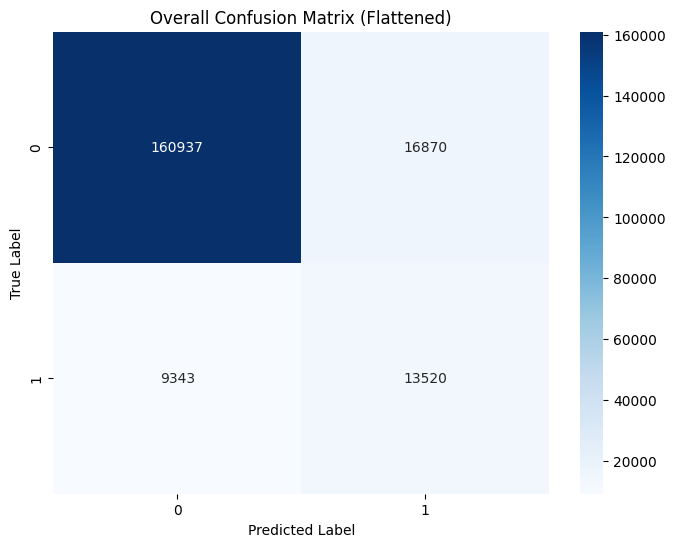


Confusion Matrix per Class:

Class 'praise':
[[15125  1787]
 [ 1395  1760]]


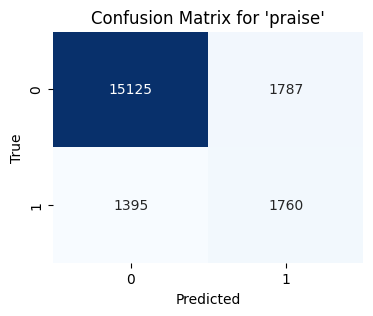


Class 'amusement':
[[17756   883]
 [  579   849]]


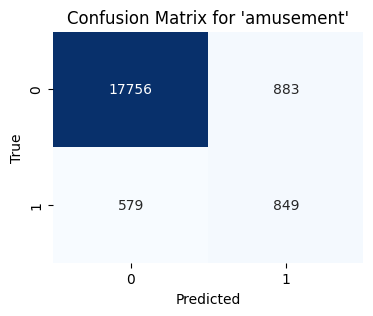


Class 'anger':
[[15536  2607]
 [  686  1238]]


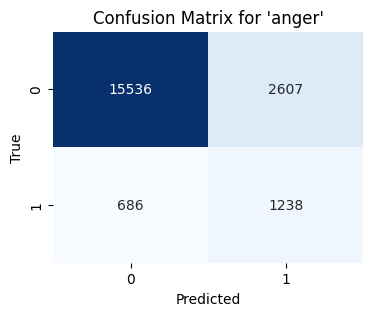


Class 'disapproval':
[[16966  1645]
 [  778   678]]


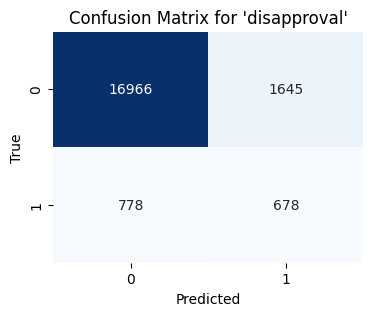


Class 'confusion':
[[10074  3230]
 [ 2702  4061]]


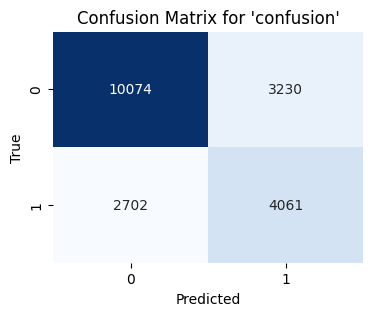


Class 'interest':
[[17155  1639]
 [  393   880]]


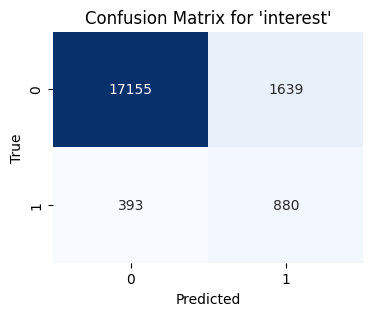


Class 'sadness':
[[17639   784]
 [  829   815]]


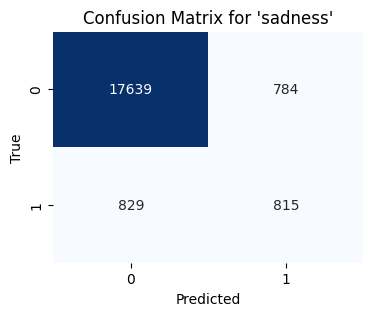


Class 'fear':
[[19140   541]
 [  158   228]]


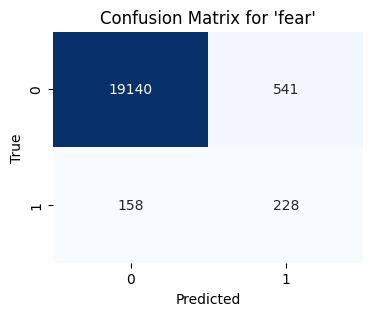


Class 'joy':
[[14493  3049]
 [ 1077  1448]]


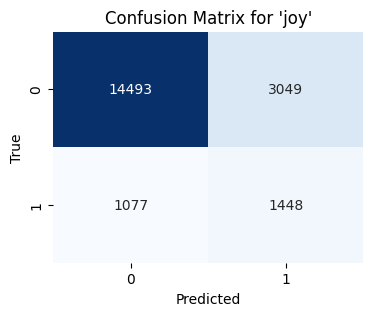


Class 'love':
[[17053   705]
 [  746  1563]]


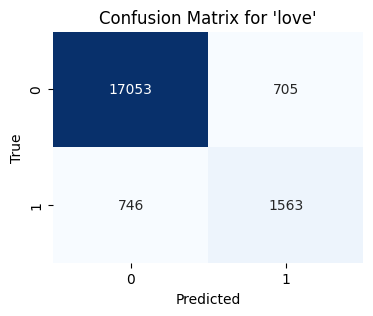


Sample Predictions:

Text: [NAME] goes to insults when you have nothing smart to say. goodbye
True Labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Predicted Labels: [0 0 1 0 0 0 0 0 0 0]

Text: lol, you dieded
True Labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted Labels: [0 1 0 0 0 0 0 0 0 0]

Text: Good for you, [NAME]! You deserved a nice drink to end a year where you made an impact in peoples lives! Cheers!
True Labels: [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Predicted Labels: [1 0 0 0 0 0 0 0 1 1]

Text: They come to your house and rob you at gun point. Be honest. What are some ways that this could be resolved?
True Labels: [0. 0. 0. 0. 1. 0. 0. 1. 0. 0.]
Predicted Labels: [0 0 1 0 1 1 0 0 0 0]

Text: It's to bad I live in a society that only wants my continual existence.
True Labels: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Predicted Labels: [0 0 0 0 0 0 1 0 0 0]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Compute overall confusion matrix by flattening the labels ---
overall_cm = confusion_matrix(true_labels.flatten(), preds_bin.flatten())
print("\nOverall (flattened) Confusion Matrix:")
print(overall_cm)

# Plot overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Overall Confusion Matrix (Flattened)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# --- Compute and plot confusion matrix for each class ---
print("\nConfusion Matrix per Class:")
for i, label in enumerate(emotion_cols):
    cm = confusion_matrix(true_labels[:, i], preds_bin[:, i])
    print(f"\nClass '{label}':")
    print(cm)

    # Plot confusion matrix for the current class
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for '{label}'")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# --- Print a few sample predictions with their true labels and predicted labels ---
# Here, we use the original (non-tokenized) test dataset to print the raw text.
# Note: tokenized_datasets["test"] contains the "text" column as well.
test_texts = tokenized_datasets["test"]["text"]

num_samples_to_show = 5  # adjust as desired
print("\nSample Predictions:")
sample_indices = np.random.choice(len(test_texts), size=num_samples_to_show, replace=False)
for idx in sample_indices:
    print(f"\nText: {test_texts[idx]}")
    print(f"True Labels: {np.array(true_labels[idx])}")
    print(f"Predicted Labels: {preds_bin[idx]}")


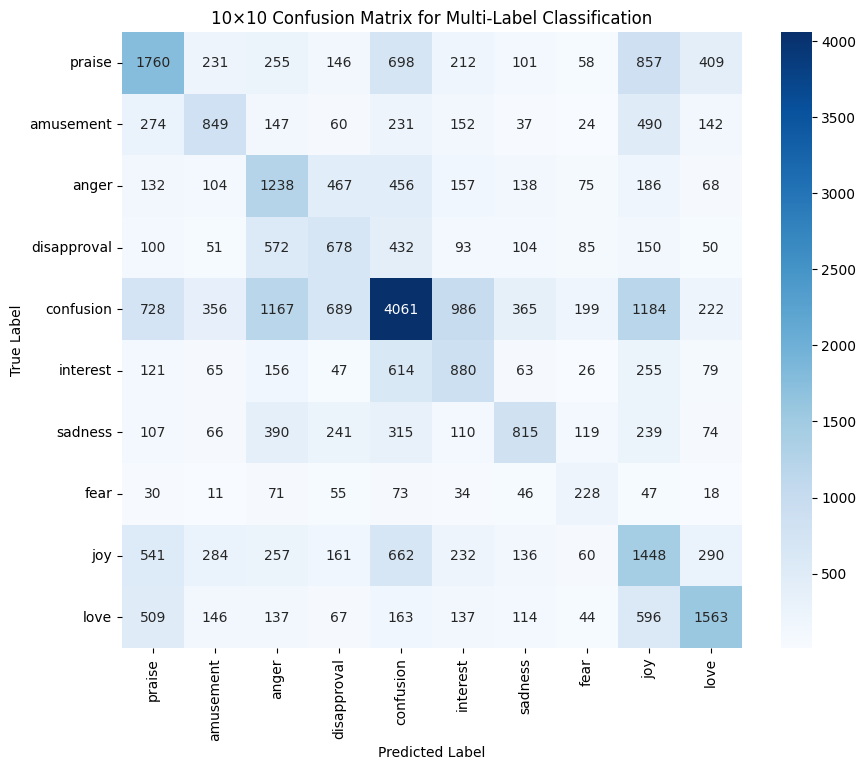

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

NUM_LABELS = preds_bin.shape[1]  # should be 10 for your case

# Initialize a 10x10 confusion matrix.
# For each sample, for each true label i, for each predicted label j,
# we increment the (i, j) cell if label i is present in true labels and label j is predicted.
cm = np.zeros((NUM_LABELS, NUM_LABELS), dtype=int)

# Loop over each sample.
for sample in range(true_labels.shape[0]):
    # Get indices for which the true label is 1.
    true_indices = np.where(true_labels[sample] == 1)[0]
    # Get indices for which the predicted label is 1.
    pred_indices = np.where(preds_bin[sample] == 1)[0]
    # For every true label in this sample, count all predicted labels.
    for i in true_indices:
        for j in pred_indices:
            cm[i, j] += 1

# Optionally, define your label names (should correspond to your emotion_cols)
# For example, if emotion_cols is defined as follows:
# emotion_cols = ['praise', 'amusement', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'trust', 'anticipation', 'joy']
# Otherwise, replace emotion_cols with your list of label names.
# emotion_cols = [...]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_cols, yticklabels=emotion_cols)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("10×10 Confusion Matrix for Multi-Label Classification")
plt.show()


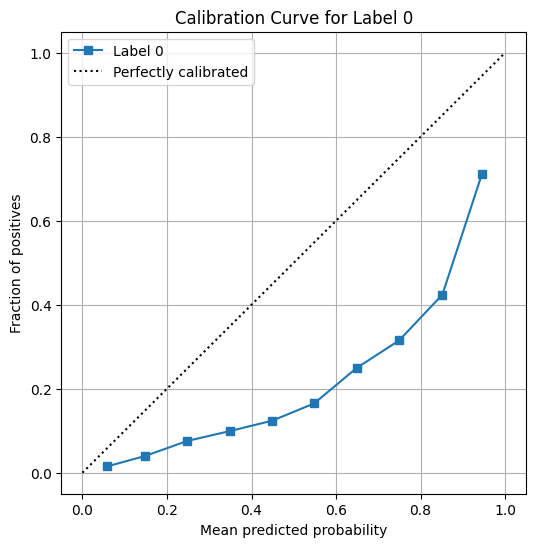

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Assume `probs` is a numpy array of shape (num_samples, num_labels) from your sigmoid outputs,
# and `true_labels` is an array of the same shape with binary ground truth labels.
# For demonstration, we use the first label (index 0).

probs_label = probs[:, 0]      # predicted probabilities for label 0
true_label = true_labels[:, 0]  # true binary labels for label 0

# Compute calibration curve data.
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, probs_label, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Label 0")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve for Label 0")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## UI

In [28]:
%pip install fastapi uvicorn pyngrok nest_asyncio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 7.4 MB/s eta 0:00:00


In [29]:
%pip install python-multipart


In [44]:
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
from pydantic import BaseModel
import uvicorn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import nest_asyncio

# Apply nest_asyncio for notebook/Colab environments
nest_asyncio.apply()

# Create a Hugging Face pipeline for text classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Initialize the FastAPI app
app = FastAPI()

class TextInput(BaseModel):
    text: str

@app.get("/", response_class=HTMLResponse)
async def read_root():
    # HTML page with improved styling using CSS and a Google Font.
    html_content = """
    <html>
      <head>
         <title>Text Classification UI</title>
         <link href="https://fonts.googleapis.com/css?family=Roboto" rel="stylesheet">
         <style>
            body {
                font-family: 'Roboto', sans-serif;
                background: linear-gradient(135deg, #e09, #d0e);
                margin: 0;
                padding: 0;
                display: flex;
                align-items: center;
                justify-content: center;
                height: 100vh;
            }
            .container {
                background: rgba(255, 255, 255, 0.95);
                border-radius: 10px;
                padding: 2rem;
                box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
                text-align: center;
                width: 90%;
                max-width: 500px;
            }
            h2 {
                color: #6a1b9a;
            }
            input[type="text"] {
                width: 80%;
                padding: 0.8rem;
                margin: 1rem 0;
                border: 1px solid #ccc;
                border-radius: 5px;
                font-size: 1rem;
            }
            button {
                padding: 0.8rem 1.5rem;
                font-size: 1rem;
                background: #6a1b9a;
                color: white;
                border: none;
                border-radius: 5px;
                cursor: pointer;
                transition: background 0.3s;
            }
            button:hover {
                background: #4a148c;
            }
            .result {
                margin-top: 1rem;
                padding: 1rem;
                background: #f1f1f1;
                border-radius: 5px;
                font-size: 1.1rem;
                color: #333;
            }
         </style>
         <script>
            async function submitText(event) {
               event.preventDefault();
               const textValue = document.getElementById("text").value;
               const response = await fetch('/predict', {
                   method: 'POST',
                   headers: {
                       'Content-Type': 'application/json'
                   },
                   body: JSON.stringify({ text: textValue })
               });
               const result = await response.text();
               document.getElementById("result").innerHTML = result;
            }
         </script>
      </head>
      <body>
         <div class="container">
             <h2>Text Classification</h2>
             <form onsubmit="submitText(event)">
                 <input type="text" id="text" name="text" placeholder="Enter text here">
                 <br>
                 <button type="submit">Predict</button>
             </form>
             <div id="result" class="result"></div>
         </div>
      </body>
    </html>
    """
    return HTMLResponse(content=html_content, status_code=200)

@app.post("/predict", response_class=HTMLResponse)
async def predict(data: TextInput):
    text = data.text
    result = classifier(text)

    # Extract the predicted label (expected format: "LABEL_4")
    raw_label = result[0]['label']

    try:
        # Split the label by '_' and take the second element as an integer index.
        label_num = int(raw_label.split('_')[1])
        mapped_label = emotion_cols[label_num] if 0 <= label_num < len(emotion_cols) else raw_label
    except (IndexError, ValueError):
        mapped_label = raw_label

    html_content = f"""
    <html>
      <head>
         <title>Prediction Result</title>
         <link href="https://fonts.googleapis.com/css?family=Roboto" rel="stylesheet">
         <style>
            body {{
                font-family: 'Roboto', sans-serif;
                background: linear-gradient(135deg, #e09, #d0e);
                margin: 0;
                padding: 0;
                display: flex;
                align-items: center;
                justify-content: center;
                height: 100vh;
            }}
            .container {{
                background: rgba(255, 255, 255, 0.95);
                border-radius: 10px;
                padding: 2rem;
                box-shadow: 0 4px 15px rgba(0, 0, 0, 0.2);
                text-align: center;
                width: 90%;
                max-width: 500px;
            }}
            h2 {{
                color: #6a1b9a;
            }}
            a {{
                display: inline-block;
                margin-top: 1rem;
                text-decoration: none;
                color: #6a1b9a;
                font-weight: bold;
            }}
            a:hover {{
                text-decoration: underline;
            }}
         </style>
      </head>
      <body>
         <div class="container">
             <h2>Prediction Result</h2>
             <p><strong>Input:</strong> {text}</p>
             <p><strong>Predicted Emotion:</strong> {mapped_label}</p>
             <p><strong>Raw Output:</strong> {result}</p>
             <a href="/">Try Another</a>
         </div>
      </body>
    </html>
    """
    return HTMLResponse(content=html_content, status_code=200)

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8001)


Device set to use cuda:0
INFO:     Started server process [759]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO:     77.77.114.10:0 - "GET / HTTP/1.1" 200 OK
INFO:     77.77.114.10:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     77.77.114.10:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     77.77.114.10:0 - "GET / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [759]


In [21]:
%pip install pyngrok

In [42]:
from pyngrok import ngrok
import threading

# Define a function to run the Uvicorn server
def run_app():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Set up a tunnel to the server
public_url = ngrok.connect(8001)
print(" * ngrok tunnel available at:", public_url)


# Run the app in a separate thread so that the cell doesn't block
thread = threading.Thread(target=run_app)
thread.start()


 * ngrok tunnel available at: NgrokTunnel: "https://d057-34-16-150-211.ngrok-free.app" -> "http://localhost:8001"


INFO:     Started server process [759]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
ERROR:    [Errno 98] error while attempting to bind on address ('0.0.0.0', 8000): address already in use
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
